# Co-binding Motif Analysis

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantaotao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import networkx as nx
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
sys.path.append("/home/jtao/code/seq_merge_pipe/")
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/cobinding_motif_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
%env PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin


env: PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin


## Generate Score Files

### Convert motif files

In [5]:
# # convert MEME motif database text file into individual motifs
# converted_motifs_dir = '/home/jtao/analysis/cobinding_motif_analysis/fimo_motifs/'
# currentLines = []
# with open('JASPAR_CORE_2016_vertebrates.meme') as f:
#     data = f.readlines()
    
# currentLines = [data[9]]
# for line in data[9:]:
#     if 'MOTIF' in line:
#         motifName = currentLines[0].strip().split()[-1]
#         outFile = open(converted_motifs_dir + '/' + motifName + '.fimo', 'w')
#         outFile.write('MEME version 4.4\n\nALPHABET= ACGT\n\nstrands: + -\n\nBackground letter frequencies (from uniform background):\nA 0.25000 C 0.25000 G 0.25000 T 0.25000 ')
#         for cl in currentLines:
#             outFile.write(cl)
#         outFile.close()
#         currentLines = [line]
#     else:
#         currentLines.append(line)

In [46]:
# convert MEME motif file to homer compatible format
outFile = open('jaspar.motif', 'w')


currentLines = []
with open('JASPAR_CORE_2016_vertebrates.meme') as f:
    data = f.readlines()
    
currentLines = []
for line in data[9:]:
    if 'MOTIF' in line and len(currentLines) > 0:
        motifName = currentLines[0].strip().split()[-1]
        outFile.write('>' + motifName + '\t' + motifName + '\n')
        for cl in currentLines[3:]:
            if not 'URL' in cl:
                outFile.write('\t'.join(cl.strip().split()) + '\n')
        currentLines = [line]
    else:
        currentLines.append(line)
        
outFile.close()



In [77]:
### convert homer motif files into a MEME compatible format
# homer motifs should come from the Homer motif database
homerMotifDir = '/home/jtao/analysis/cobinding_motif_analysis/jaspar_2016_curated_homerFormat'
outDir = '/home/jtao/analysis/cobinding_motif_analysis/homer_motifs_converted'


for f in os.listdir(homerMotifDir):
    if os.path.isfile(homerMotifDir + '/' +f):
        out_file = open(outDir + '/' + f.replace('motif','fimo'), 'w')
        with open(homerMotifDir + '/' + f) as i:
            data = i.readlines()
        out_file.write('MEME version 4.4\n\nALPHABET= ACGT\n\nstrands: + -\n\n' +
                       'Background letter frequencies (from uniform background):\nA 0.25000 C 0.25000 G 0.25000 T 0.25000\n' +
                       'MOTIF '+ f.split('.')[0] + ' ' +data[0].split()[1] + '\n')
        out_file.write('letter-probability matrix: nsites= 20 alength= 4 w= '+str(len(data)-1)+' E= 0 \n')
        for line in data[1:]:
            out_file.write('  ' + line)
        out_file.write('\n')
        out_file.close()
    

### Copy Peak Files from AP-1 Analysis Directory

In [2]:

for ft in [
 'atf3_kla',
 'atf3_veh',
 'cebpa_kla',
 'cebpa_veh',
 'cjun_kla',
 'cjun_veh',
 'fos_kla',
 'fos_veh',
 'junb_kla',
 'junb_veh',
 'jund_kla',
 'jund_veh',
 'p65_kla',
 'p65_veh',
 'pu1_kla',
 'pu1_veh']:
    c57bl6_path = '/home/jtao/analysis/ap1_analysis/idrPeaks/c57bl6_' + ft + '_peaks.tsv'
    balbc_path = '/home/jtao/analysis/ap1_analysis/idrPeaks_strains/balbc_' + ft + '_peaks.tsv'
    ! cp $c57bl6_path ./peak_files/
    ! cp $balbc_path ./peak_files
    

cp: cannot stat ‘/home/jtao/analysis/ap1_analysis/idrPeaks_strains/balbc_cebpa_kla_peaks.tsv’: No such file or directory
cp: cannot stat ‘/home/jtao/analysis/ap1_analysis/idrPeaks_strains/balbc_cebpa_veh_peaks.tsv’: No such file or directory


### Resize Peak Files

In [132]:
target_peak_size = 100

if not os.path.isdir('./resized_peak_files'):
    os.mkdir('./resized_peak_files')
else:
    for rpf in os.listdir('./resized_peak_files'):
        os.remove('./resized_peak_files/' + rpf)

for pf in os.listdir('./peak_files/'):
    current_peak_frame = pd.read_csv('./peak_files/' + pf, sep='\t' )
    peakCenters = (current_peak_frame['start'] + current_peak_frame['end']) /2
    int_peakCenters = np.ceil(peakCenters).astype(int)
    new_starts = int_peakCenters - int(target_peak_size/2)
    new_ends = int_peakCenters + int(target_peak_size/2)
    current_peak_frame['start'] = new_starts
    current_peak_frame['end'] = new_ends
    current_peak_frame.to_csv('./resized_peak_files/' + pf, sep='\t', index=False)

### Create group summary file

In [175]:
%%capture
! mergePeaks -d given -venn venn.txt ./resized_peak_files/* > ./merged_peaks.tsv



In [180]:
merged_frame = pd.read_csv('./merged_peaks.tsv', sep='\t')

# filter away peaks in unused chromsomes
filtered_frame = merged_frame[
             ~(merged_frame['chr'].str.contains('chrY')) & 
             ~(merged_frame['chr'].str.contains('chrM')) &
             ~(merged_frame['chr'].str.contains('random')) &
             ~(merged_frame['chr'].str.contains('Un'))]

# resize peaks
target_peak_size = 200
peakCenters = (filtered_frame['start'] + filtered_frame['end']) /2
int_peakCenters = np.ceil(peakCenters).astype(int)
new_starts = int_peakCenters - int(target_peak_size/2)
new_ends = int_peakCenters + int(target_peak_size/2)
filtered_frame['start'] = new_starts
filtered_frame['end'] = new_ends
filtered_frame.to_csv('./merged_peaks_filtered_resized.tsv', sep='\t', index=False)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

In [183]:
! makeSummaryFile.py ./merged_peaks_filtered_resized.tsv ./group_summary.tsv ./resized_peak_files/*

sys:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
Finished reading merged peak file...
Integrating scores for balbc_atf3_kla
Integrating scores for balbc_atf3_veh
Integrating scores for balbc_cjun_kla
Integrating scores for balbc_cjun_veh
Integrating scores for balbc_fos_kla
Integrating scores for balbc_fos_veh
Integrating scores for balbc_junb_kla
Integrating scores for balbc_junb_veh
Integrating scores for balbc_jund_kla
Integrating scores for balbc_jund_veh
Integrating scores for balbc_p65_kla
Integrating scores for balbc_p65_veh
Integrating scores for balbc_pu1_kla
Integrating scores for balbc_pu1_veh
Integrating scores for c57bl6_atac_kla
Integrating scores for c57bl6_atac_veh
Integrating scores for c57bl6_atf3_kla
Integrating scores for c57bl6_atf3_veh
Integrating scores for c57bl6_cebpa_kla
Integrating scores for c57bl6_cebpa_veh
Integrating scores for c57bl6_cjun_kla
Integrating scores for c57bl6_cjun_veh
Integrating sco

### Annotate with AP-1 Tag Counts

In [30]:
! annotatePeaks.pl ./merged_peaks_filtered.tsv mm10 -d /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_ATF3_KLA-1h_GJF_16-04-21 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_ATF3_KLA-1h_GJF_16-08-16 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_ATF3_Veh_GJF_16-04-21 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_ATF3_Veh_GJF_16-07-23 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_CEBPa_KLA-1h_GFEW_15-11-18 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_CEBPa_KLA-1h_SH_11-05-12 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_CEBPa_Veh_GFEW_15-11-18 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_CEBPa_Veh_SH_11-05-12 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_cJun_KLA-1h_GFEW_15-11-18 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_cJun_KLA-1h_GJF_16-04-21 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_cJun_Veh_GJF_16-04-21 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_cJun_Veh_GJF_16-06-14 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_Fos_KLA-1h_GJF_15-02-06 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_Fos_KLA-1h_GJF_16-04-21 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_Fos_Veh_GJF_14-03-17 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_Fos_Veh_GJF_15-02-06 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_Fra2_Veh_GJF_14-03-17 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_Fra2_Veh_GJF_16-04-21 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_Fra2_KLA-1h_GJF_16-04-21 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_Fra2_KLA-1h_GJF_16-08-16 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_JunB_KLA-1h_GJF_14-03-17 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_JunB_KLA-1h_GJF_15-02-06 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_JunB_Veh_GJF_14-03-17 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_JunB_Veh_GJF_16-04-21 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_JunD_KLA-1h_GFEW_15-11-18 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_JunD_KLA-1h_GJF_16-04-21 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_JunD_Veh_GJF_16-04-21 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_JunD_Veh_GJF_16-07-23 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_p65_KLA-1h_SH_11-07-21 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_p65_KLA-1h_TKS_15-06-02 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_p65_Veh_SH_11-07-21 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_p65_Veh_TKS_15-06-02 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_PU1_KLA-1h_SH_11-05-12 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_PU1_KLA-1h_TKS_12-01-14 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_PU1_Veh-1h_SH_11-05-12 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_PU1_Veh_GJF_16-06-14 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_ATF3_KLA-1h_GJF_16-07-25 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_ATF3_KLA-1h_GJF_16-08-16-rep1 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_ATF3_Veh_GJF_16-08-16 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_ATF3_Veh_GJF_16-08-16-rep1 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_cJun_KLA-1h_GFEW_10-19-15 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_cJun_KLA-1h_GJF_16-06-12 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_cJun_Veh_GFEW_10-19-15 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_cJun_Veh_GJF_16-06-12 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_Fos_KLA-1h_GFEW_10-19-15 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_Fos_KLA-1h_GJF_16-07-22 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_Fos_Veh_GFEW_10-19-15 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_Fos_Veh_GJF_16-07-22 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_JunB_KLA-1h_GFEW_10-19-15 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_JunB_KLA-1h_GJF_16-10-13 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_JunB_Veh_GFEW_10-19-15 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_JunB_Veh_GJF_16-07-22 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_JunD_KLA-1h_GFEW_10-19-15 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_JunD_KLA-1h_GJF_16-10-13 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_JunD_Veh_GFEW_10-19-15 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_JunD_Veh_GJF_16-06-12 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_p65_KLA-1h_GJF_16-07-25-rep1 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_p65_KLA-1h_GJF_16-08-16 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_p65_Veh_GJF_16-07-22-rep1 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_p65_Veh_GJF_16-07-22-rep2 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_PU1_KLA-1h_GFEW_10-19-15 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_PU1_KLA-1h_GJF_16-06-12 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_PU1_Veh_GFEW_10-19-15 /gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories_strains/Balbc_Thiomac_ChIP_PU1_Veh_GJF_16-06-12 > merged_annotated_peaks_ap1TagCounts.tsv 


	Peak file = ./merged_peaks_filtered.tsv
	Genome = mm10
	Organism = mouse
	Tag Directories:
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_ATF3_KLA-1h_GJF_16-04-21
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_ATF3_KLA-1h_GJF_16-08-16
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_ATF3_Veh_GJF_16-04-21
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_ATF3_Veh_GJF_16-07-23
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_CEBPa_KLA-1h_GFEW_15-11-18
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_CEBPa_KLA-1h_SH_11-05-12
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_CEBPa_Veh_GFEW_15-11-18
		/gpfs/data01/glasslab/home/jtao/analysis/ap1_analysis/tag_directories/C57Bl6_Thiomac_ChIP_C

In [33]:
%%bash
annotatePeaks.pl ./merged_peaks_filtered.tsv mm10 -size 1000 -strand + -d ./tag_directories_enhancerMarks/* > merged_annotated_peaks_sense.tsv &
annotatePeaks.pl ./merged_peaks_filtered.tsv mm10 -size 1000 -strand - -d ./tag_directories_enhancerMarks/* > merged_annotated_peaks_antisense.tsv &
annotatePeaks.pl ./merged_peaks_filtered.tsv mm10 -hist 20 -size 1000 -strand both -d ./tag_directories_enhancerMarks/* > hist.tsv &




	Peak file = ./merged_peaks_filtered.tsv
	Genome = mm10
	Organism = mouse
	Peak Region set to 1000
	Will count tags on strand: +
	Tag Directories:
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_5GRO_KLA_12-03-09
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_5GRO_Veh_12-03-09
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_Gro_KLA_mk_11-06-08
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_Gro_KLA_mk_11-08-26
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_Gro_Veh_mk_11-06-08
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_Gro_Veh_mk_11-08-26
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_H3K27Ac_KLA_CR_12-07-06
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_H3K27Ac_KLA_DGO_14-08-18
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_H3K27Ac_Veh_CR_12-07-06
		./tag_directories_enhancerMarks/C57Bl6_Thiomac_H3K27Ac_Veh_DGO_14-08-18

	Peak file = ./merged_peaks_filtered.tsv
	Genome = mm10
	Organism = mouse
	Peak Region set to 1000
	Will count tags on strand: -
	Tag Directories:


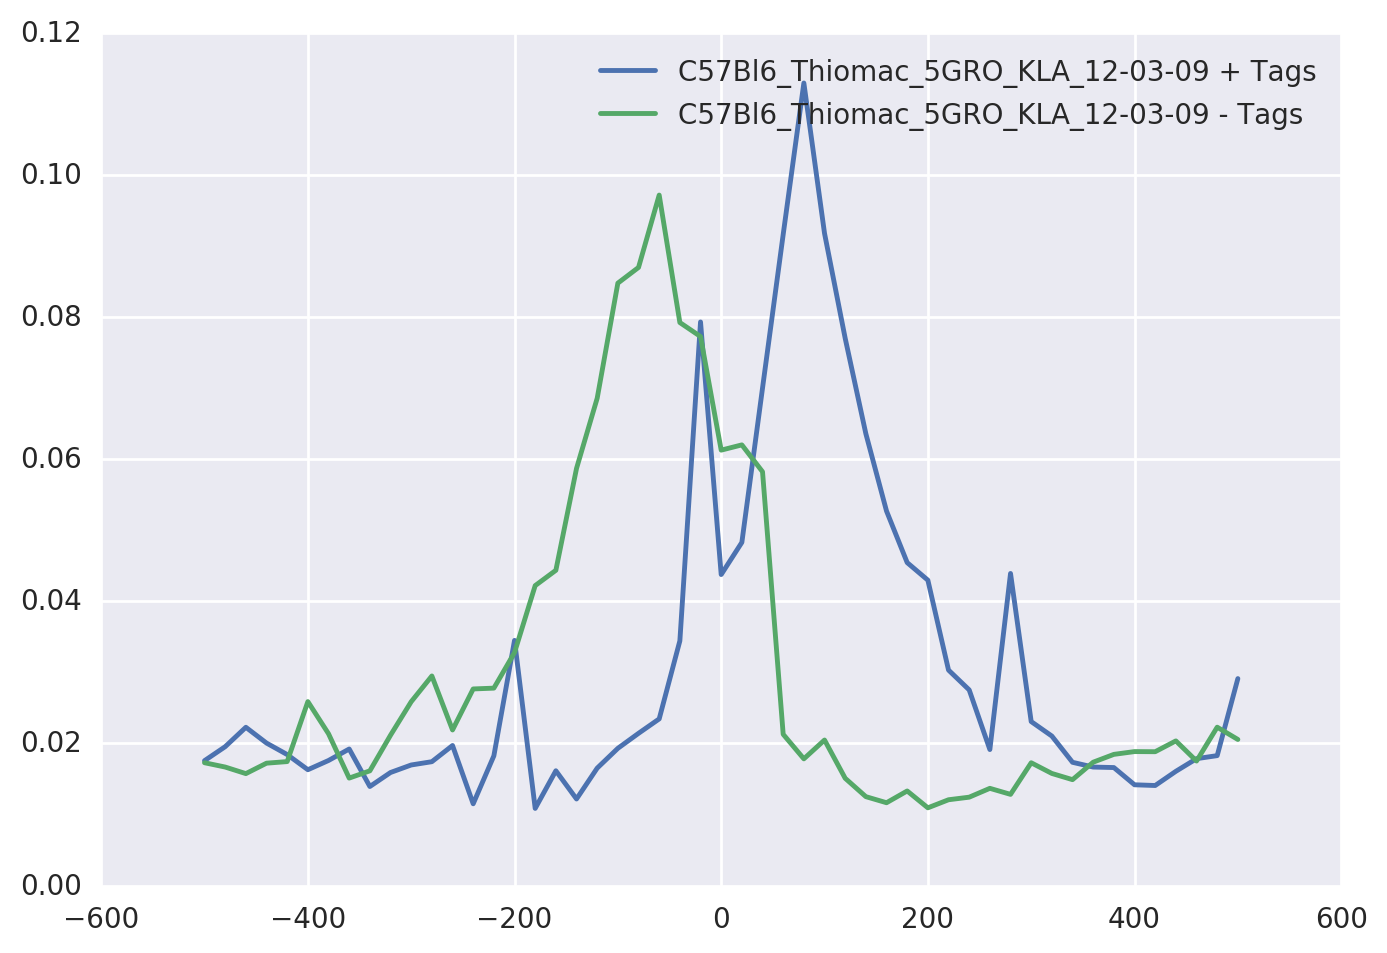

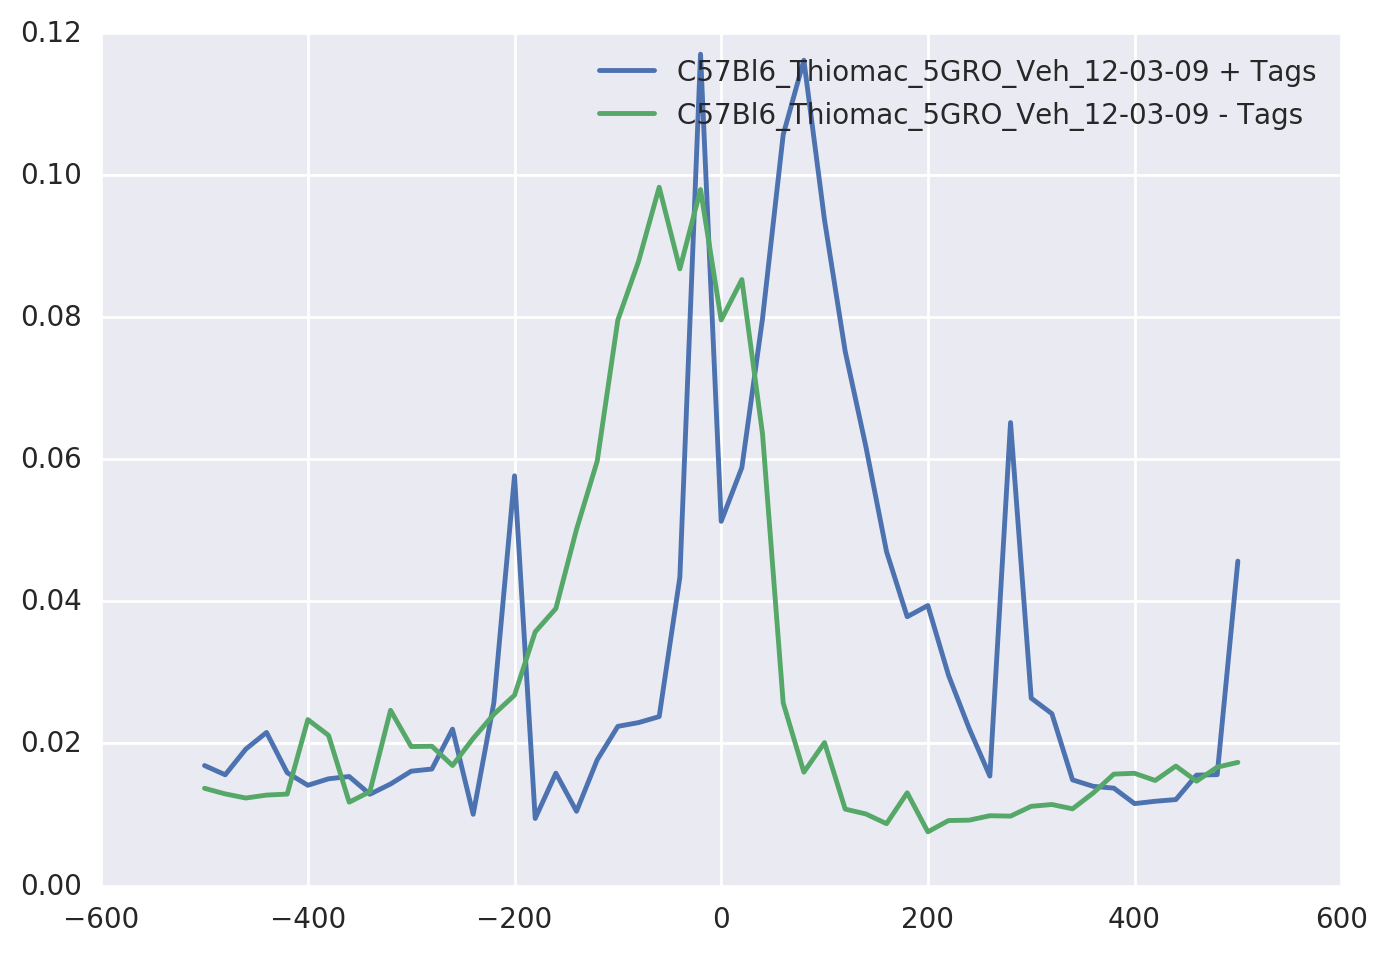

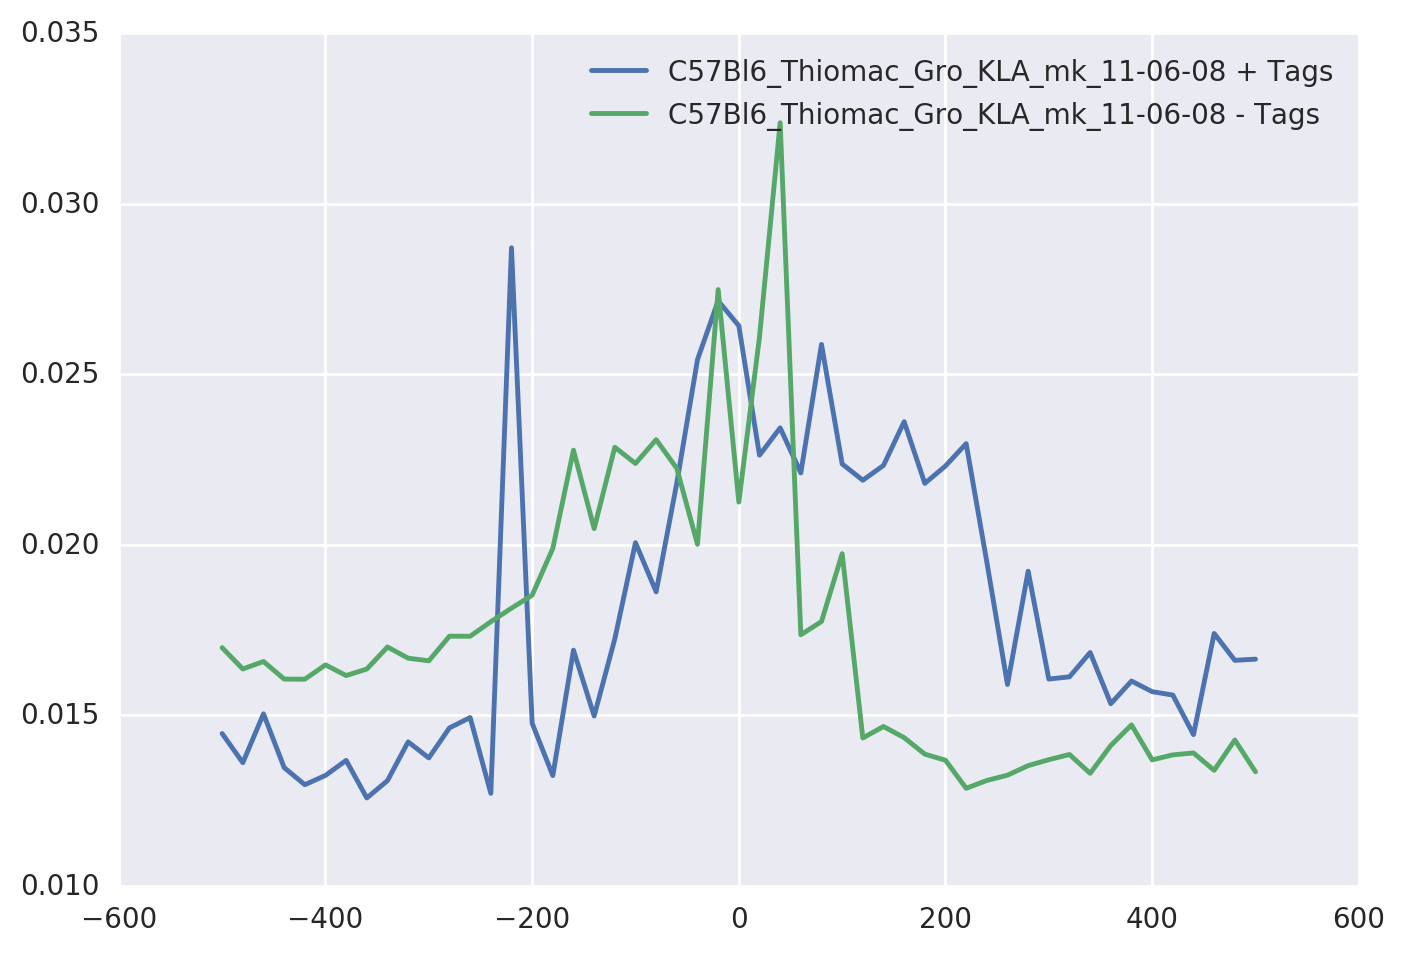

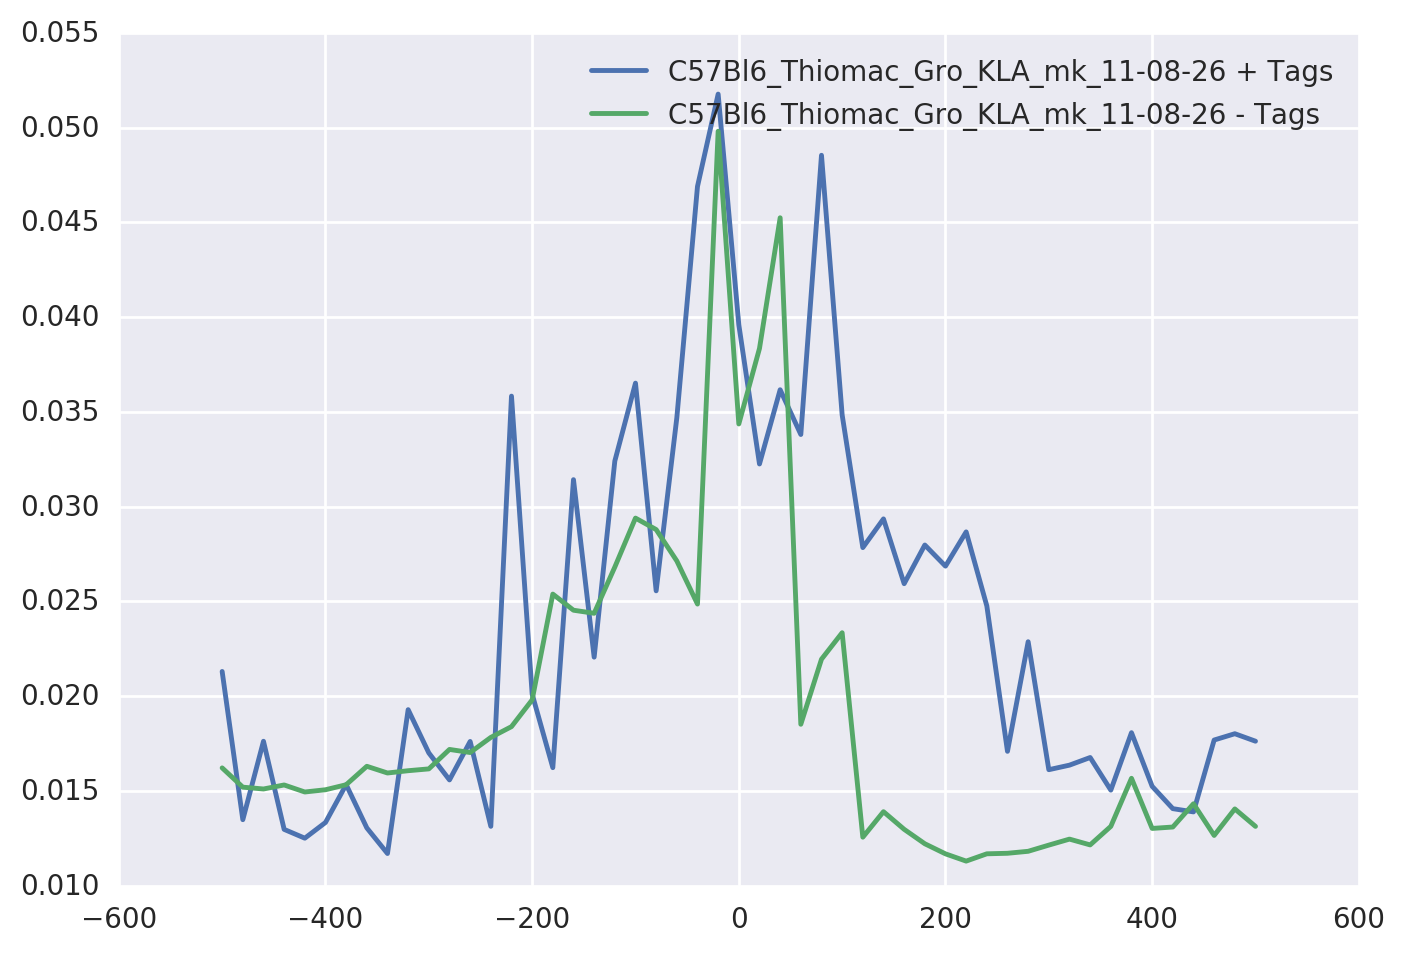

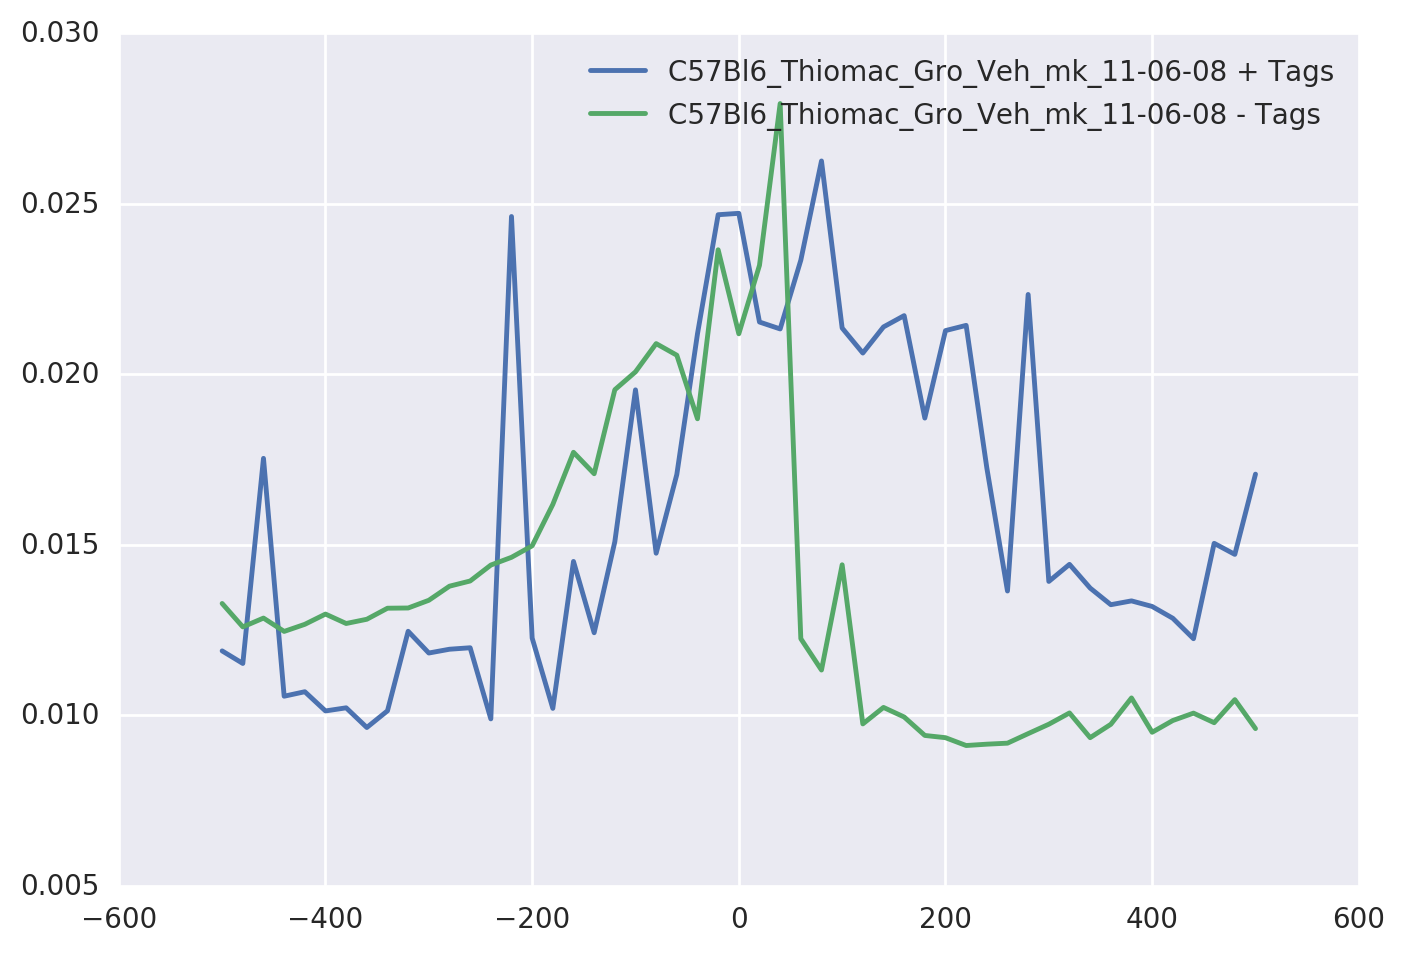

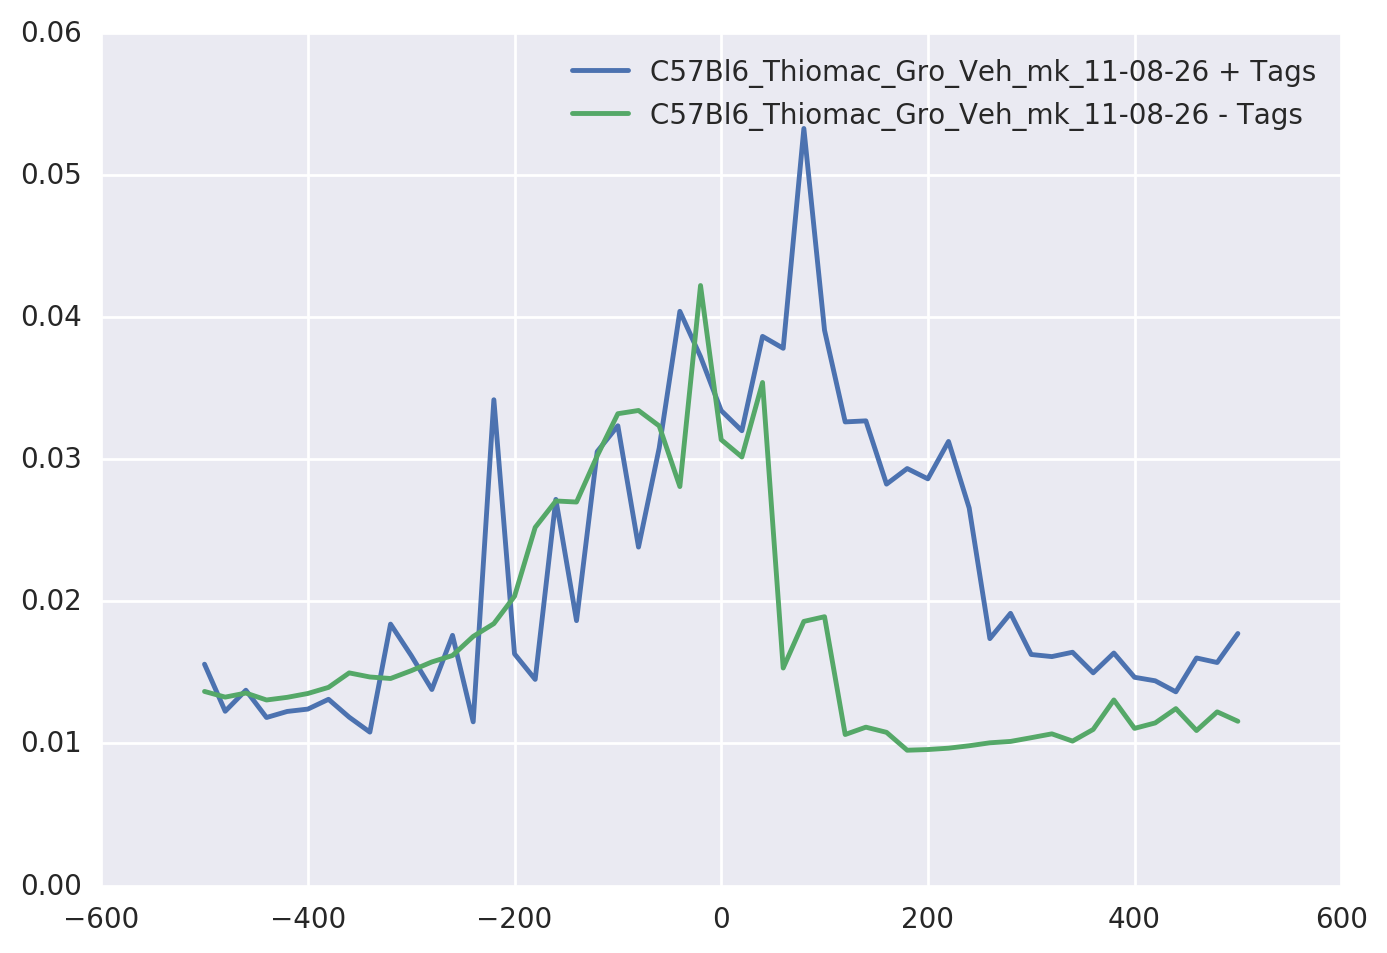

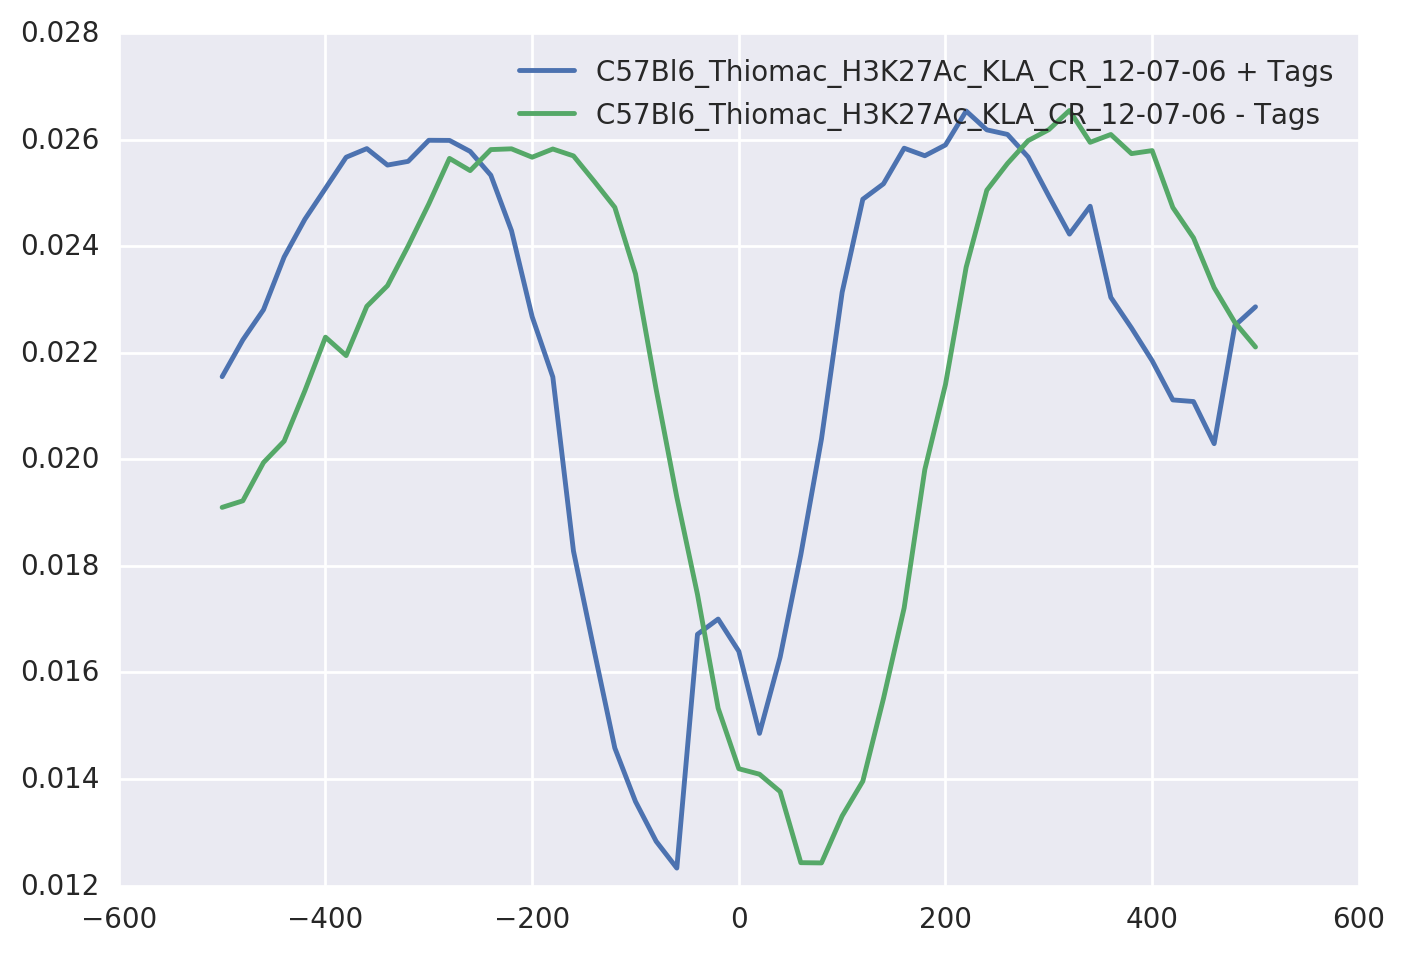

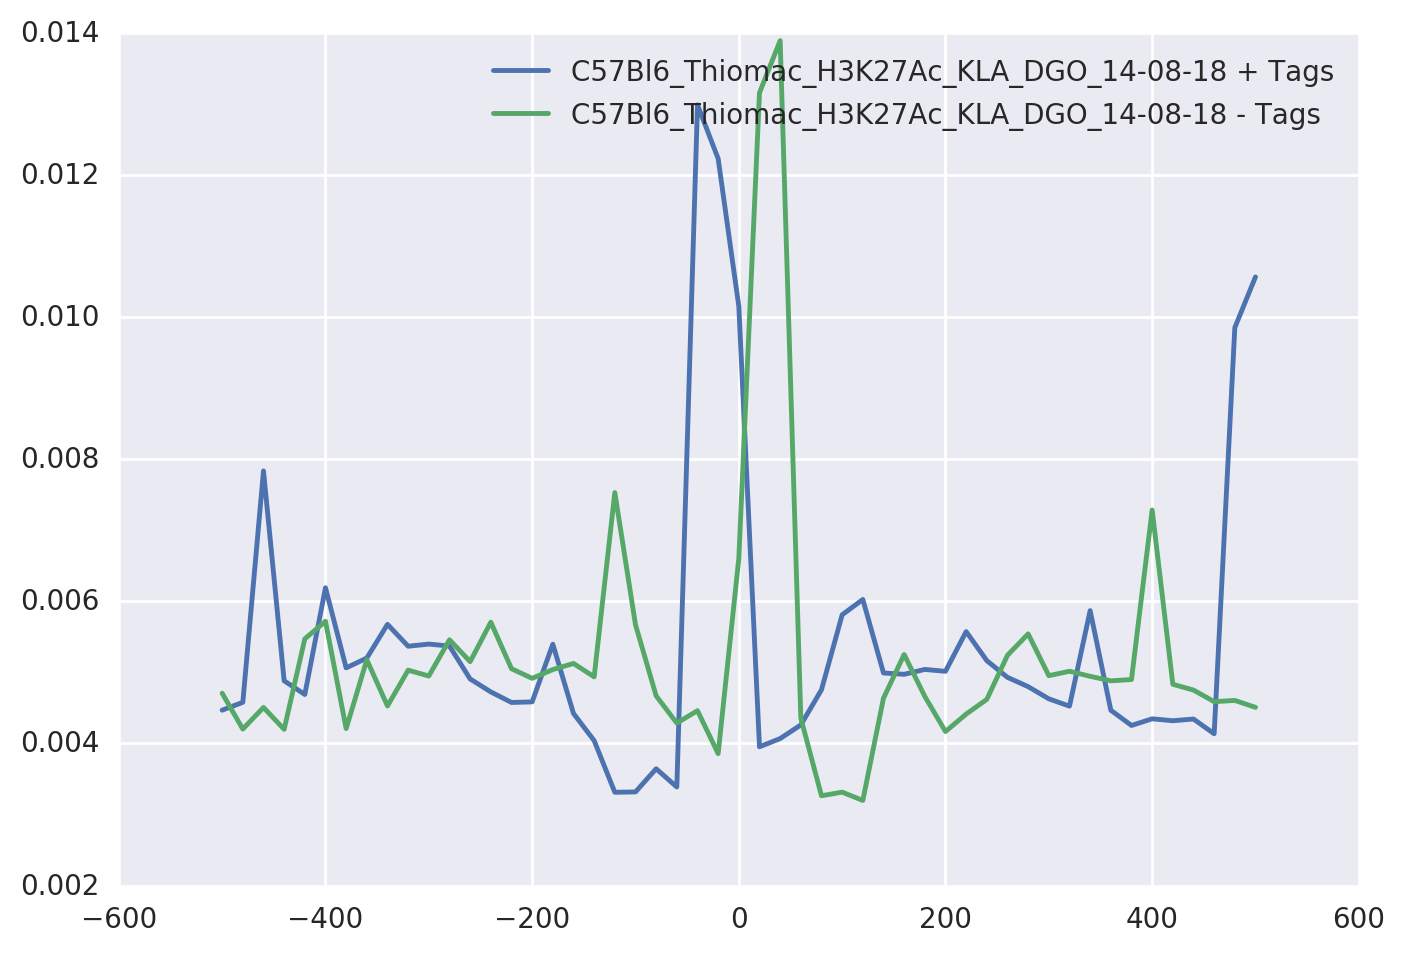

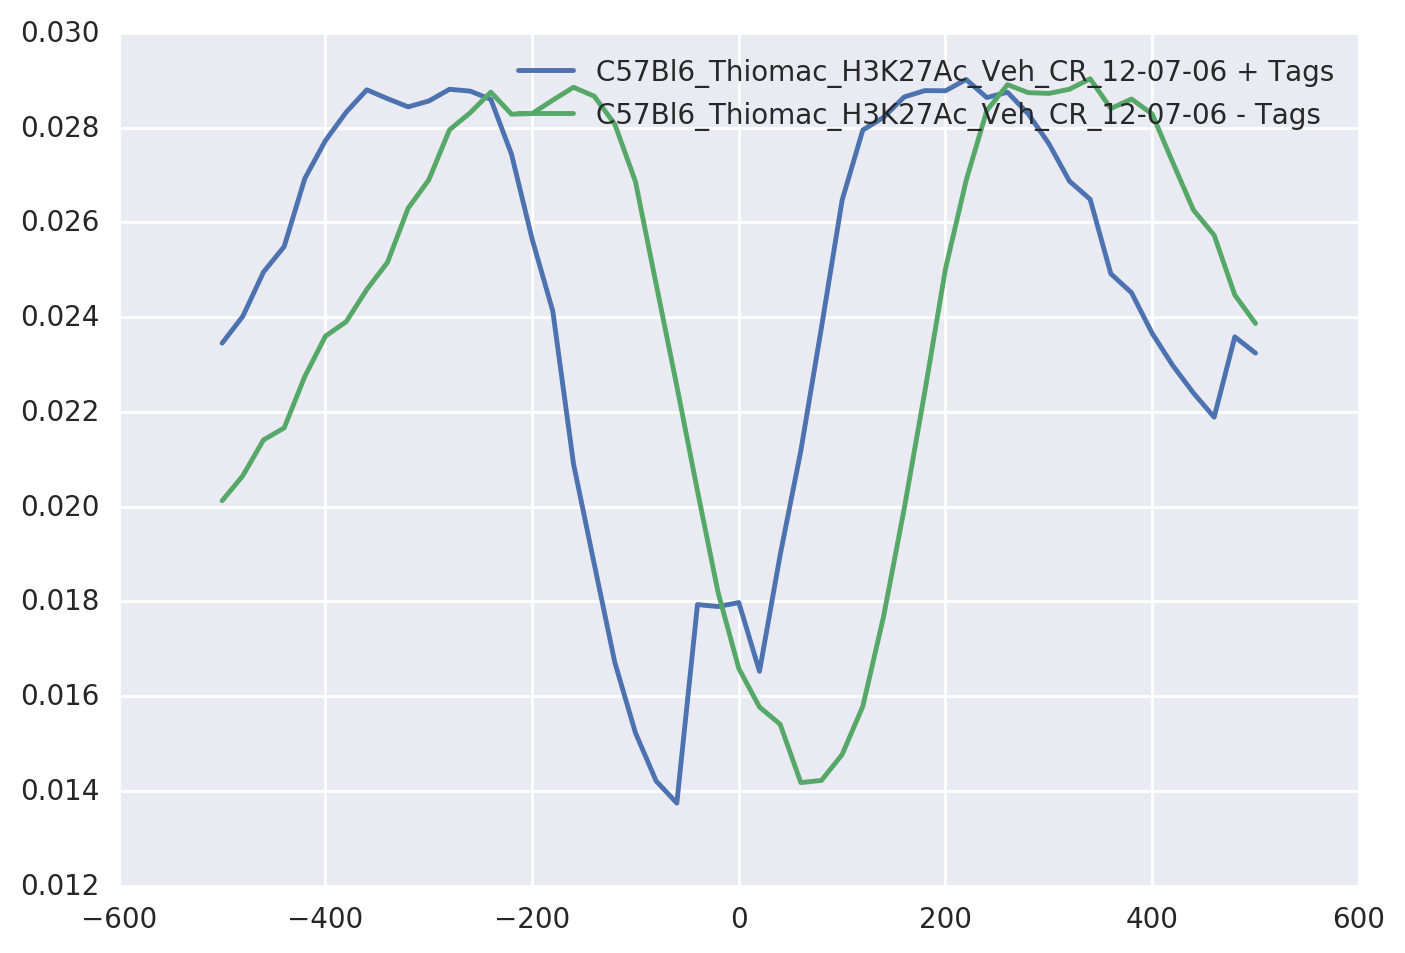

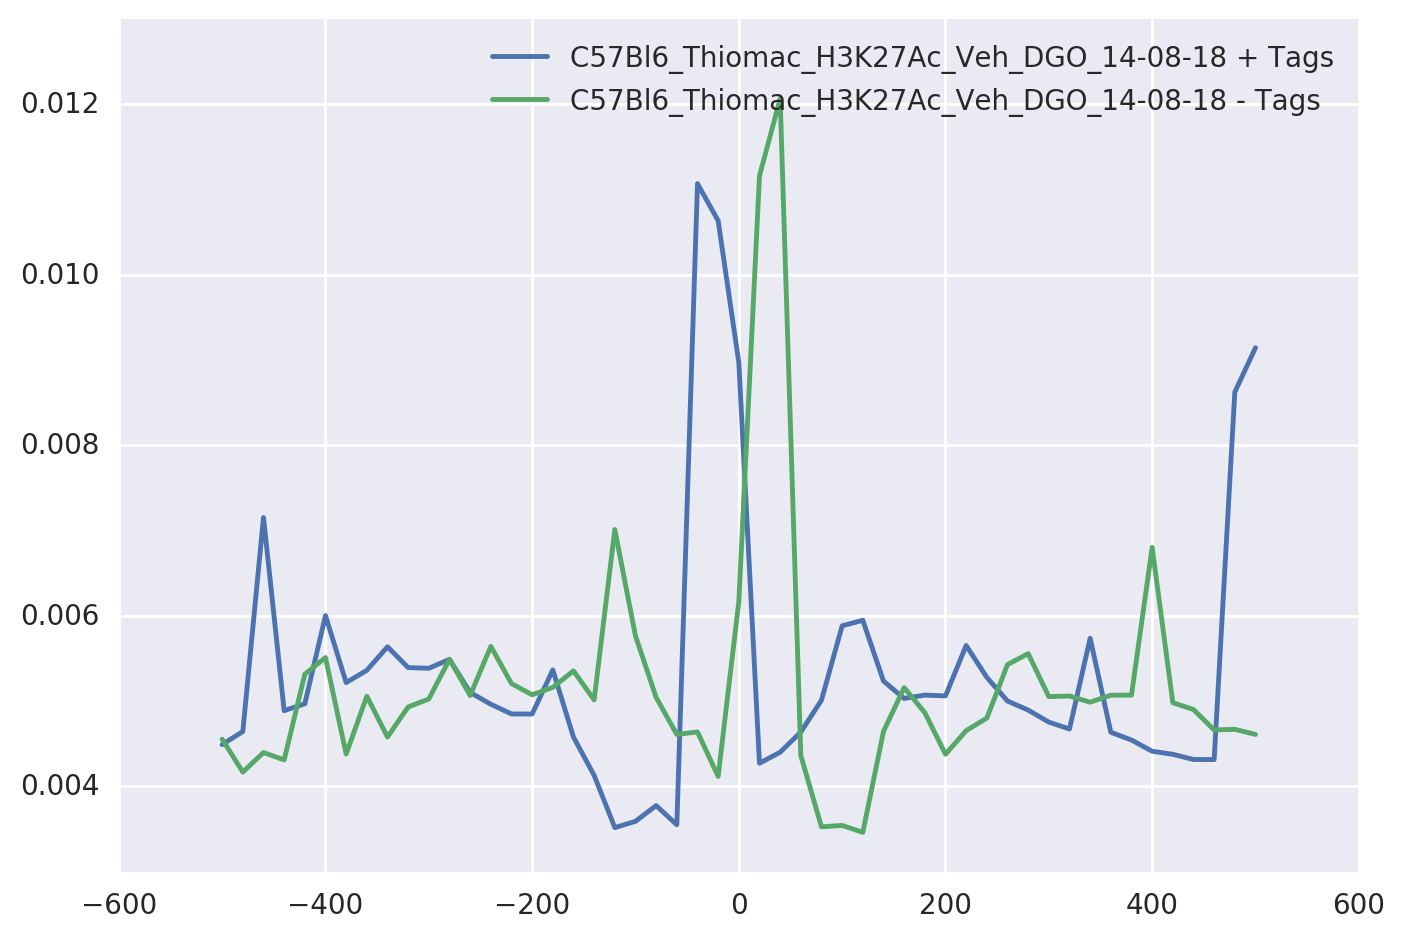

In [34]:
frame =pd.read_csv('hist.tsv',sep='\t')
columns = frame.columns.values
for i in range(int((frame.shape[1]-1)/3)):
    plt.plot(frame.ix[:,0],frame[columns[3*i+2]])
    plt.plot(frame.ix[:,0],frame[columns[3*i+3]])
    plt.legend([columns[3*i+2].split('/')[-1], columns[3*i+3].split('/')[-1]])
    plt.show()

### Retrieve sequences under peaks for finding motifs

In [35]:
%%bash
if [ ! -d ./peak_sequences ] ;
    then mkdir ./peak_sequences
else
    rm ./peak_sequences/*
fi

In [36]:
# %%capture
# # get sequences to scan for motifs

# !homerTools extract ./merged_peaks.tsv /bioinformatics/homer/data/genomes/mm10 -fa > ./peak_sequences/c57bl6.fa

In [37]:
%%bash
perl /home/vlink/mouse_strains/marge/analysis/extract_seq_from_peakfiles.pl -strains C57BL6J -file ./merged_peaks_filtered.tsv -output ./peak_sequences/C57BL6J_marge.fa
perl /home/vlink/mouse_strains/marge/analysis/extract_seq_from_peakfiles.pl -strains BALBCJ -file ./merged_peaks_filtered.tsv -output ./peak_sequences/BALBCJ_marge.fa
# perl /home/vlink/mouse_strains/marge/analysis/extract_seq_from_peakfiles.pl -strains NODSHILTJ -file ./merged_peaks_filtered.tsv -output ./peak_sequences/NODSHILTJ_marge.fa




Saving peaks
Loading shift vectors
Saving peaks
Loading shift vectors


In [ ]:
# reformat fastq files to use homer peak IDs

coordinate_peakID_dict = {} # {chr_start_end:homerID}
with open ('./merged_peaks_filtered.tsv') as f:
    data = f.readlines()
for line in data[1:]:
    tokens = line.split('\t')
    coordinate = '_'.join(tokens[1:4])
    peakID = tokens[0].strip()
    coordinate_peakID_dict[coordinate] = tokens[0]


In [ ]:
for fastaFile in os.listdir('./peak_sequences/'):
    if 'marge' in fastaFile:
        strain = fastaFile.split('_')[0]
        outFile = open('./peak_sequences/' + fastaFile.replace('_marge',''), 'w')
        print(fastaFile)
        with open('./peak_sequences/' + fastaFile) as f:
            data = f.readlines()
        for line in data:
            if '>' in line:
                coordinate = line[1:].replace('_'+strain,'').strip()
                
                peakID = coordinate_peakID_dict[coordinate]
                outFile.write('>' + peakID + '\n')
               
            else:
                outFile.write(line)
        outFile.close()

In [40]:
### read in sequences as dictionary {peakID: sequence}
with open('./peak_sequences/C57BL6J.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()
        

### Scan for motifs using FIMO

In [41]:
# create a script to scan for motifs using FIMO
! if [ ! -d /home/jtao/analysis/cobinding_motif_analysis/fimo_out/ ]; then mkdir /home/jtao/analysis/cobinding_motif_analysis/fimo_out/; fi
! rm -rf fimo_out/*
! rm -rf fimo_result/*


pthresh = 0.01
motif_dir = '/home/jtao/analysis/cobinding_motif_analysis/fimo_motifs/'

fimo_results_dir = './fimo_results'

for fastaFile in os.listdir('./peak_sequences/'):
    if not 'marge' in fastaFile:
        print(fastaFile)
        strain = fastaFile.split('.')[0]
        count = 0
        scriptFile = open('scanMotifs_'+ strain +'.sh','w')
        for m in os.listdir(motif_dir):
            if 'fimo' in m:
                fimo_out_dir = './fimo_out/' + strain + '_' +m.replace('.fimo','')
                outPath = fimo_results_dir + '/' +strain + '_' + m.replace('.fimo','') +'.txt'
                scriptFile.write(
        #             '(sleep ' + str(15 * count) + 
                    '(sleep ' + str(0 * count) + 
                    's; fimo --text --max-stored-scores 2000000 --output-pthresh ' + 
                    str(pthresh) +' --oc ' + fimo_out_dir + ' ' +
                    motif_dir + '/' + m + ' ./peak_sequences/' + fastaFile +
                    '> ' + outPath + ' ) & \n')
                count+=1
        scriptFile.close()



C57BL6J.fa
BALBCJ.fa


In [42]:
%%bash
chmod a+x ./scanMotifs*
./scanMotifs_C57BL6J.sh
./scanMotifs_BALBCJ.sh
# ./scanMotifs_NODSHILTJ.sh

Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Read 1 motifs.
Using motif +znf410 of width 17.
Using motif -znf410 of width 17.
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Read 1 motifs.
Using motif +znf354c of width 6.
Using motif -znf354c of width 6.
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Read 1 motifs.
Using motif +znf423 of width 15.
Using motif -znf423 of width 15.
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Reading txt file vmajor: 4, vminor: 4, vbug: 0
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using nucleotide alphabet (ACGTURYKMSWBDHVN).
Using background frequencies from NR sequence database.
Using background frequencies from NR sequence database.
Reading txt 

## Read in Score Files

### Read in Peak scores as floating point values

In [184]:
# read in peak data data
summary_frame = pd.read_csv('/home/jtao/analysis/cobinding_motif_analysis/group_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
summary_frame.index = summary_frame['ID'].values

# remove peaks in unknown/random chromosomes
summary_frame = summary_frame[~summary_frame['chr'].str.contains('random')]
summary_frame = summary_frame[~summary_frame['chr'].str.contains('Un')]


_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
summary_frame.to_pickle('summary_frame.pickle')

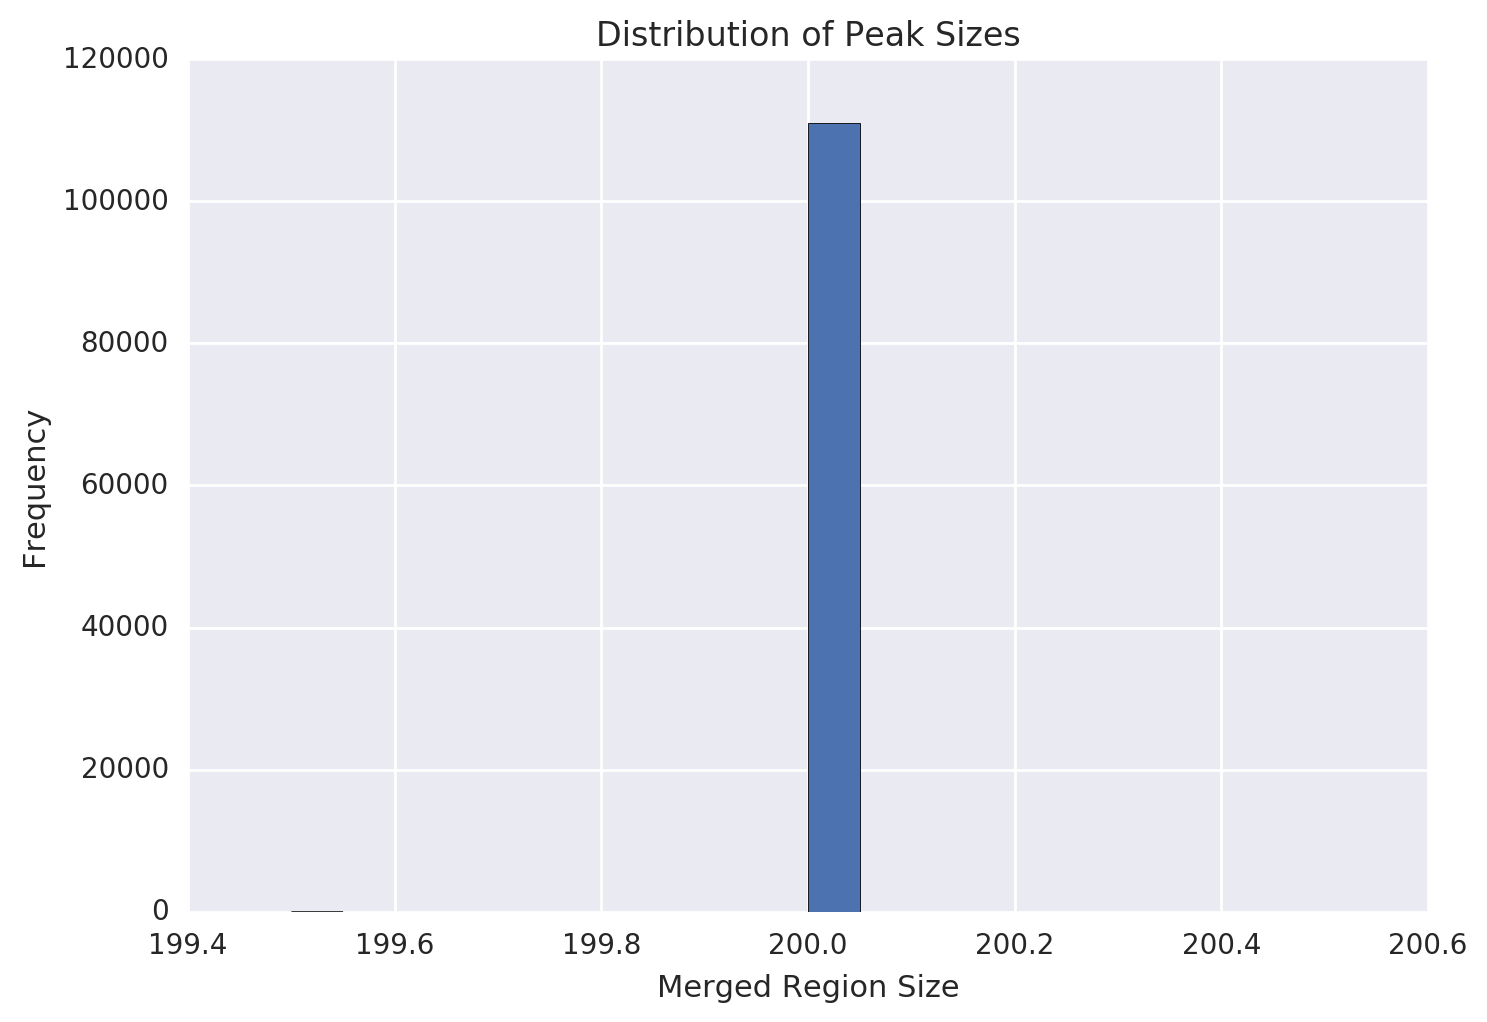

In [185]:
# plot motif positions to make sure that nothing went wrong with the merging
sizes = summary_frame['end'] - summary_frame['start']
plt.hist(sizes, bins = 20);
plt.xlabel('Merged Region Size')
plt.ylabel('Frequency')
plt.title('Distribution of Peak Sizes')

### Read in Enhancer Marks

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

5GRO_KLA
5GRO_Veh
Gro_KLA
Gro_Veh
H3K27Ac_KLA
H3K27Ac_Veh


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

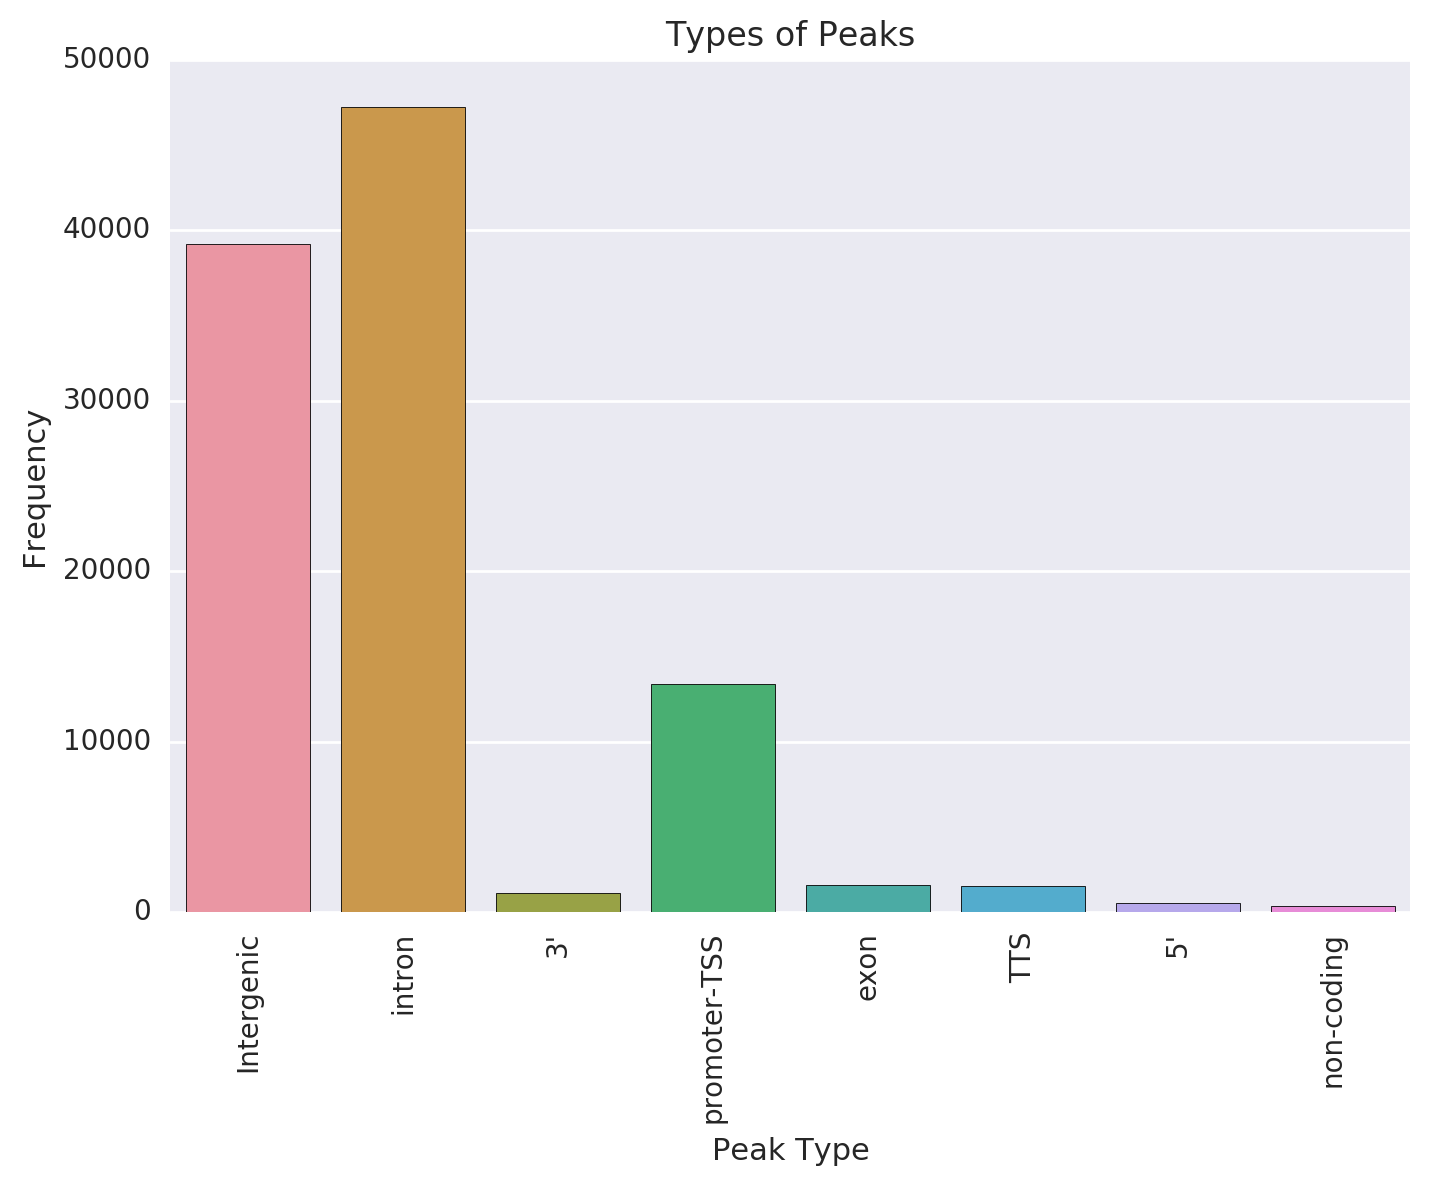

In [45]:
### read in GRO and H3K27Ac scores

sense_frame = pd.read_csv('merged_annotated_peaks_sense.tsv', sep='\t')

antisense_frame = pd.read_csv('merged_annotated_peaks_antisense.tsv', sep='\t')

sense_frame.index=sense_frame.ix[:,0].values
columns = sense_frame.columns.values
columns[0] = 'ID'
columns = [x.split('/')[-1].split()[0] if '/' in x else x for x in columns]
sense_frame.columns = columns

antisense_frame.index=antisense_frame.ix[:,0].values
columns = antisense_frame.columns.values
columns[0] = 'ID'
columns = [x.split('/')[-1].split()[0] if '/' in x else x for x in columns]
antisense_frame.columns = columns

tagDirectories = sense_frame.columns[19:].values
experiment_tagDir_dict = {}
for td in tagDirectories:
    tokens = td.split('_')
    experiment = '_'.join(tokens[2:4])
    if experiment in experiment_tagDir_dict:
        experiment_tagDir_dict[experiment].append(td)
    else:
        experiment_tagDir_dict[experiment] = [td]

_enhancerMarks = sorted(experiment_tagDir_dict.keys())

annotation_frame = sense_frame[['Chr', 'Start', 'End', 'Strand']]
annotation_frame['Annotation'] = [str(x).split()[0] for x in sense_frame['Annotation'].values]

for experiment in _enhancerMarks:
    current_sense_frame = sense_frame[experiment_tagDir_dict[experiment]]
    current_antisense_frame = antisense_frame[experiment_tagDir_dict[experiment]]


    annotation_frame[experiment + ' +'] = np.mean(current_sense_frame, axis=1)
    annotation_frame[experiment + ' -'] = np.mean(current_antisense_frame, axis=1)
    print(experiment)

#     log_frame = np.log2(current_sense_frame+1)
#     log_frame.columns = [x + ' +' for x in log_frame.columns.values]
#     sns.pairplot(log_frame, size=7, kind= 'reg')
#     plt.savefig(experiment+'_sense_pairplot.png')
#     plt.close()
# #     plt.show()
    
#     log_frame = np.log2(current_antisense_frame+1)
#     log_frame.columns = [x + ' -' for x in log_frame.columns.values]
#     sns.pairplot(log_frame, size=7, kind= 'reg')
#     plt.savefig(experiment+'_antisense_pairplot.png')
#     plt.close()
# #     plt.show()
    


nonStrandSpecificExperiments = ['H3K27Ac_KLA', 'H3K27Ac_Veh']
for experiment in nonStrandSpecificExperiments:
    annotation_frame[experiment] = annotation_frame[experiment + ' +'] + annotation_frame[experiment + ' -']
    annotation_frame.drop(experiment + ' +', axis=1, inplace=True)
    annotation_frame.drop(experiment + ' -', axis=1, inplace=True)
    
# remove outlier GRO-seq values
# annotation_frame.loc[annotation_frame['Gro_Veh +'] > 10000, 'Gro_Veh +' ] = 0
# annotation_frame.loc[annotation_frame['Gro_KLA +'] > 10000, 'Gro_KLA +' ] = 0
# annotation_frame.loc[annotation_frame['Gro_Veh -'] > 10000, 'Gro_Veh -' ] = 0
# annotation_frame.loc[annotation_frame['Gro_KLA -'] > 10000, 'Gro_KLA -' ] = 0


sns.countplot(annotation_frame['Annotation'])
plt.title('Types of Peaks')
plt.xlabel('Peak Type')
plt.ylabel('Frequency')
plt.xticks(rotation=90);

annotation_frame.to_pickle('annotation_frame.pickle')


## Classifying Enhancers

In [ ]:
sns.distplot(np.log2(annotation_frame['Gro_Veh -']+1))
plt.show()
sns.distplot(np.log2(annotation_frame['Gro_Veh +']+1))
plt.show()
sns.distplot(np.log2(annotation_frame['Gro_KLA -']+1))
plt.show()
sns.distplot(np.log2(annotation_frame['Gro_KLA +']+1))
plt.show()
sns.distplot(np.log2(annotation_frame['H3K27Ac_KLA']+1))
plt.show()
sns.distplot(np.log2(annotation_frame['H3K27Ac_Veh']+1))
plt.show()

In [ ]:
numClusters = 3
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
features = annotation_frame[[x for x in annotation_frame.columns.values if 'KLA' in x and not 'Active' in x]]
features = features[features.index.isin(intergenic_ids)]
scaler = preprocessing.MinMaxScaler()
normed_features = pd.DataFrame(scaler.fit_transform(np.log2(features + 1)))
normed_features.columns = features.columns
colorDict = dict(zip(range(numClusters+1),sns.color_palette("Set1") + sns.color_palette("Set2") + sns.color_palette("colorblind")))

cg = sns.clustermap(normed_features,yticklabels=False, col_cluster=False)
plt.close()
row_linkage = cg.dendrogram_row.linkage
            
row_flatCluster = scipy.cluster.hierarchy.fcluster(row_linkage, numClusters, criterion="maxclust")
            
row_colors = [colorDict[row_flatCluster[i]] for i in range(len(cg.data.index))]
sns.clustermap(normed_features,
             row_linkage = row_linkage,
             row_colors = row_colors,
             col_cluster=False,
             cmap="Blues",
             yticklabels = False
             )

In [ ]:
numClusters = 3
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
features = annotation_frame[[x for x in annotation_frame.columns.values if 'Veh' in x and not 'Active' in x]]
features = features[features.index.isin(intergenic_ids)]
scaler = preprocessing.MinMaxScaler()
normed_features = pd.DataFrame(scaler.fit_transform(np.log2(features + 1)))
normed_features.columns = features.columns
colorDict = dict(zip(range(numClusters+1),sns.color_palette("Set1") + sns.color_palette("Set2") + sns.color_palette("colorblind")))

cg = sns.clustermap(normed_features,yticklabels=False, col_cluster=False)
plt.close()
row_linkage = cg.dendrogram_row.linkage
            
row_flatCluster = scipy.cluster.hierarchy.fcluster(row_linkage, numClusters, criterion="maxclust")
            
row_colors = [colorDict[row_flatCluster[i]] for i in range(len(cg.data.index))]
sns.clustermap(normed_features,
             row_linkage = row_linkage,
             row_colors = row_colors,
             col_cluster=False,
             cmap="Blues",
             yticklabels = False
             )

In [ ]:
### Assign active versus inactive for KLA enhancers ###
numColors = 20
colorDict = dict(zip(range(numColors),sns.color_palette("Set2") + sns.color_palette("colorblind")))

# calculate k-means cluster for use in coloring
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
features = annotation_frame[[x for x in annotation_frame.columns.values if 'KLA ' in x]]
features = features[features.index.isin(intergenic_ids)]
normed_features = np.log2(features + 1)

print(features.shape)
# normed_features = sklearn.preprocessing.normalize(features, axis=1)
est = KMeans(n_clusters=2, n_jobs=4)
est.fit(normed_features)
colors = [colorDict[x] for x in est.labels_]

sns.jointplot(normed_features['Gro_KLA +'],
           normed_features['Gro_KLA -'],
           alpha=0.4, c=colors)


# sns.jointplot(normed_features['Gro_KLA +'],
#            normed_features['H3K27Ac_KLA'],
#            alpha=0.4, c=colors)


# sns.jointplot(normed_features['Gro_KLA -'],
#            normed_features['H3K27Ac_KLA'],
#            alpha=0.4, c=colors)


clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(normed_features.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_kla_sense = list(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA +'].values)
    gro_kla_antisense = list(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA -'].values)
    h3k27ac_kla = list(annotation_frame[annotation_frame.index.isin(current_indices)]['H3K27Ac_KLA'].values)
   
        
    reads = reads + gro_kla_sense
    treatments = treatments + len(current_indices) * ['Gro +'] 
        
    reads = reads + gro_kla_antisense
        
    treatments = treatments + len(current_indices) * ['Gro -'] 
        
    reads = reads + h3k27ac_kla

    treatments = treatments + len(current_indices) * ['H3K27Ac']

    clusters = clusters + 3 * len(current_indices) * [str(cluster)]
        
reads = np.log2(np.array(reads) + 1)
data_frame = pd.DataFrame({'reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})
print('cluster 0:',np.sum(data_frame['cluster']=='0')/3,
     'cluster 1:',np.sum(data_frame['cluster']=='1')/3)
sns.factorplot(x='cluster',y='reads', hue='treatment', 
                data= data_frame, 
                kind='box',
                size=10,
                width=0.4,
                whis=1,
                showfliers=False)
# plt.ylim([0,12])
plt.show()

### assign activity according to the mean H3K27Ac value of each cluster ###
cluster_mean_0 = np.mean(data_frame[(data_frame['cluster']=='0') & (data_frame['treatment']=='H3K27Ac')]['reads'])
cluster_mean_1 = np.mean(data_frame[(data_frame['cluster']=='1') & (data_frame['treatment']=='H3K27Ac')]['reads'])
if cluster_mean_0 < cluster_mean_1:
    # cluster 1 is considered the active cluster
    index_activity_dict = dict(zip(normed_features.index.values,
                                     [True if x == 1 else False for x in est.labels_]))
else:
    # cluster 0 is considered the active cluster
    index_activity_dict = dict(zip(normed_features.index.values,
                                     [True if x == 0 else False for x in est.labels_]))
annotation_frame['Active Enhancer KLA'] = [index_activity_dict[x] for x in annotation_frame.index.values]


In [ ]:
### Assign active versus inactive for VEH enhancers ###
numColors = 20
colorDict = dict(zip(range(numColors),sns.color_palette("Set2") + sns.color_palette("colorblind")))

# calculate k-means cluster for use in coloring
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
features = annotation_frame[[x for x in annotation_frame.columns.values if 'Veh ' in x]]
features = features[features.index.isin(intergenic_ids)]
normed_features = np.log2(features + 1)

print(features.shape)
# normed_features = sklearn.preprocessing.normalize(features, axis=1)
est = KMeans(n_clusters=2, n_jobs=4)
est.fit(normed_features)
colors = [colorDict[x] for x in est.labels_]

sns.jointplot(normed_features['Gro_Veh +'],
           normed_features['Gro_Veh -'],
           alpha=0.4, c=colors)


# sns.jointplot(normed_features['Gro_Veh +'],
#            normed_features['H3K27Ac_Veh'],
#            alpha=0.4, c=colors)


# sns.jointplot(normed_features['Gro_Veh -'],
#            normed_features['H3K27Ac_Veh'],
#            alpha=0.4, c=colors)


clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(normed_features.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_veh_sense = list(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh +'].values)
    gro_veh_antisense = list(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh -'].values)
    h3k27ac_veh = list(annotation_frame[annotation_frame.index.isin(current_indices)]['H3K27Ac_Veh'].values)
   
    
    reads = reads + gro_veh_sense
    treatments = treatments + len(current_indices) * ['Gro +']
    
    reads = reads + gro_veh_antisense
        
    treatments = treatments + len(current_indices) * ['Gro -']
    
    reads = reads + h3k27ac_veh

    treatments = treatments + len(current_indices) * ['H3K27Ac']

    clusters = clusters + 3 * len(current_indices) * [str(cluster)]
    
reads = np.log2(np.array(reads) + 1)
data_frame = pd.DataFrame({'reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})
print('cluster 0:',np.sum(data_frame['cluster']=='0')/3,
     'cluster 1:',np.sum(data_frame['cluster']=='1')/3)
sns.factorplot(x='cluster',y='reads', hue='treatment', 
                data= data_frame, 
                kind='box',
                size=10,
                width=0.4,
                whis=1,
                showfliers=False)
# plt.ylim([0,12])
plt.show()

### assign activity according to the mean H3K27Ac value of each cluster ###
cluster_mean_0 = np.mean(data_frame[(data_frame['cluster']=='0') & (data_frame['treatment']=='H3K27Ac')]['reads'])
cluster_mean_1 = np.mean(data_frame[(data_frame['cluster']=='1') & (data_frame['treatment']=='H3K27Ac')]['reads'])
if cluster_mean_0 < cluster_mean_1:
    # cluster 1 is considered the active cluster
    index_activity_dict = dict(zip(normed_features.index.values, 
                                     [True if x == 1 else False for x in est.labels_]))
else:
    # cluster 0 is considered the active cluster
    index_activity_dict = dict(zip(normed_features.index.values, 
                                     [True if x == 0 else False for x in est.labels_]))
annotation_frame['Active Enhancer Veh'] = [index_activity_dict[x] for x in annotation_frame.index.values]

### Read in motif scores

In [46]:
motif_dir = '/home/jtao/analysis/cobinding_motif_analysis/fimo_motifs/'
# motif_dir = '/home/jtao/analysis/cobinding_motif_analysis/fimo_motifs_jaspar_2014/'


for fastaFile in os.listdir('./peak_sequences/'):
    if not 'marge' in fastaFile:
        print(fastaFile)
        strain = fastaFile.split('.')[0]

        peak_start_dict = dict(zip(summary_frame['ID'].values, summary_frame['start'].values))

        motif_score_frame = summary_frame[['ID', 'Factors', 'chr']]
        motif_score_frame.index=motif_score_frame['ID'].values

        motif_sequence_frame = summary_frame[['ID', 'Factors', 'chr']]
        motif_sequence_frame.index=motif_score_frame['ID'].values

        motif_strand_frame = summary_frame[['ID', 'Factors', 'chr']]
        motif_strand_frame.index=motif_score_frame['ID'].values

        motif_start_frame = summary_frame[['ID', 'Factors', 'chr']]
        motif_start_frame.index=motif_score_frame['ID'].values

        motif_end_frame = summary_frame[['ID', 'Factors', 'chr']]
        motif_end_frame.index=motif_score_frame['ID'].values

        motif_count_frame = summary_frame[['ID', 'Factors', 'chr']]
        motif_count_frame.index = motif_count_frame['ID'].values

        counter=0
        for m in sorted(os.listdir(motif_dir)):
            counter+=1
            if '.fimo' in m:
                print(counter,m)
                motif_results = './fimo_results/' + strain + '_' + m.replace('.fimo','') +'.txt'
                fimo_result_frame=pd.read_csv(motif_results, 
                                              skiprows=1,
                                              names=['motif_name', 
                                                     'peak_id', 
                                                     'start', 
                                                     'stop', 
                                                     'strand', 
                                                     'score', 
                                                     'pvalue', 
                                                     'sequence'],
                                              sep='\t')
                motif_name = m.replace('.fimo','')

                id_count_dict = {} #{PeakID:motifCount}
                id_values_dict = {} # {PeakID:(motifScore, motifSequence, motifStrand, motifStart, motifEnd)}

                ids = fimo_result_frame['peak_id'].values
                scores = fimo_result_frame['score'].values
                strands = fimo_result_frame['strand'].values
                sequences = fimo_result_frame['sequence']
                starts = fimo_result_frame['start']
                ends = fimo_result_frame['stop']

                for i in range(len(ids)):
                    currentScore = float(scores[i])
                    currentSequence = sequences[i]
                    currentStrand = strands[i]
                    currentStart = int(starts[i])
                    currentEnd = int(ends[i])

                    if currentScore < 0.0:
                        currentScore = 0.0
                    
                    
                    values = (currentScore, currentSequence, currentStrand, currentStart, currentEnd)

                    if ids[i] in id_values_dict:
                        if currentScore > id_values_dict[ids[i]][0]:
                            id_values_dict[ids[i]] = values
                            id_count_dict[ids[i]] += 1
                    else:
                        id_values_dict[ids[i]] = values
                        id_count_dict[ids[i]] = 1

                sorted_values = [id_values_dict[x] if x in id_values_dict else (0,'','?',-1,-1,0) for x in  motif_score_frame['ID'].values]
                sorted_scores = [x[0] for x in sorted_values]
                sorted_sequences = [x[1] for x in sorted_values]
                sorted_strands = [x[2] for x in sorted_values]
                sorted_starts = [x[3] for x in sorted_values]
                sorted_ends = [x[4] for x in sorted_values]
                sorted_counts = [id_count_dict[x] if x in id_count_dict else 0 for x in motif_score_frame['ID'].values]

                motif_score_frame[motif_name] = sorted_scores
                motif_sequence_frame[motif_name] = sorted_sequences
                motif_strand_frame[motif_name] = sorted_strands
                motif_start_frame[motif_name] = sorted_starts
                motif_end_frame[motif_name] = sorted_ends
                motif_count_frame[motif_name] = sorted_counts


        motif_score_frame.to_pickle('motif_score_frame_'+  strain + '.pickle')
        motif_score_frame.to_csv('motif_scores_'+  strain + '.tsv', sep='\t', index=False)

        motif_sequence_frame.to_pickle('motif_sequence_frame_'+  strain + '.pickle')
        motif_sequence_frame.to_csv('motif_sequence_'+  strain + '.tsv', sep='\t', index=False)

        motif_strand_frame.to_pickle('motif_strand_frame_'+  strain + '.pickle')
        motif_strand_frame.to_csv('motif_strand_'+  strain + '.tsv', sep='\t', index=False)

        motif_start_frame.to_pickle('motif_start_frame_'+  strain + '.pickle')
        motif_start_frame.to_csv('motif_start_frame_'+  strain + '.tsv', sep='\t', index=False)

        motif_end_frame.to_pickle('motif_end_frame_'+  strain + '.pickle')
        motif_end_frame.to_csv('motif_end_frame_'+  strain + '.tsv', sep='\t', index=False)

        motif_count_frame.to_pickle('motif_count_frame_'+  strain + '.pickle')
        motif_count_frame.to_csv('motif_count_frame_'+  strain + '.tsv', sep='\t', index=False)


C57BL6J.fa
1 alx1_alx4_arx.fimo


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

2 ap-1.fimo
3 ar_nr3c1_nr3c2.fimo
4 arid3a.fimo
5 arid3b.fimo
6 arid5a.fimo
7 arnt_mycn.fimo
8 arntl_mitf.fimo
9 ascl2_nhlh1.fimo
10 atf7_batf3_creb5.fimo
11 bcl6.fimo
12 bcl6b.fimo
13 bhlh.fimo
14 bhlha15.fimo
15 bhlhe23.fimo
16 cdx.fimo
17 cebp.fimo
18 cenpb.fimo
19 creb3-l1.fimo
20 crem.fimo
21 ctcf.fimo
22 cux.fimo
23 dbp_hlf_tef.fimo
24 dmbx1.fimo
25 dmrt3.fimo
26 dux.fimo
27 dux4.fimo
28 duxa.fimo
29 e2f1.fimo
30 e2f2.fimo
31 e2f4_e2f6.fimo
32 e2f7.fimo
33 e2f8.fimo
34 ebf1.fimo
35 ebox.fimo
36 egr.fimo
37 elf.fimo
38 elk_etv.fimo
39 esr1.fimo
40 esr2.fimo
41 esrr.fimo
42 ewsr1-fli1.fimo
43 figla_id4_snai2_tcf3_tcf4.fimo
44 fox.fimo
45 gata.fimo
46 gcm.fimo
47 gfi1.fimo
48 gfi1b.fimo
49 gli2.fimo
50 glis.fimo
51 gmeb2.fimo
52 grhl1.fimo
53 gsc.fimo
54 hes.fimo
55 hic.fimo
56 hinfp.fimo
57 hltf.fimo
58 hnf1.fimo
59 hnf4a.fimo
60 hnf4g.fimo
61 homeobox-1.fimo
62 homeobox-2.fimo
63 homeobox-3.fimo
64 homeobox-4.fimo
65 homeobox-5.fimo
66 hoxa11.fimo
67 hoxa5.fimo
68 hoxa9.fimo
69 ho

## Read in Summed Motif Scores

In [66]:
motif_dir = '/home/jtao/analysis/cobinding_motif_analysis/fimo_motifs/'

for fastaFile in os.listdir('./peak_sequences/'):
    if not 'marge' in fastaFile:
        print(fastaFile)
        strain = fastaFile.split('.')[0]

        motif_summedScore_frame = summary_frame[['ID', 'Factors', 'chr']]
        motif_summedScore_frame.index=motif_summedScore_frame['ID'].values

        counter=0
        for m in sorted(os.listdir(motif_dir)):
            counter+=1
            if '.fimo' in m:
                print(counter,m)
                motif_results = './fimo_results/' + strain + '_' + m.replace('.fimo','') +'.txt'
                fimo_result_frame=pd.read_csv(motif_results, 
                                              skiprows=1,
                                              names=['motif_name', 
                                                     'peak_id', 
                                                     'start', 
                                                     'stop', 
                                                     'strand', 
                                                     'score', 
                                                     'pvalue', 
                                                     'sequence'],
                                              sep='\t')
                motif_name = m.replace('.fimo','')
                
                id_summedScores_dict = {} #{PeakID:summedMotifScore}
                
                ids = fimo_result_frame['peak_id'].values
                scores = fimo_result_frame['score'].values

                for i in range(len(ids)):
                    currentScore = float(scores[i])

                    if currentScore < 0.0:
                        currentScore = 0.0
                    
                    if ids[i] in id_summedScores_dict:
                        id_summedScores_dict[ids[i]] += np.max([np.power(currentScore,2), 1])
                    else:
                        id_summedScores_dict[ids[i]] = np.power(currentScore,2)
                sorted_summedScores = [np.log2(np.max([id_summedScores_dict[x],1])) if x in id_summedScores_dict else 0 for x in motif_summedScore_frame['ID'].values]

                motif_summedScore_frame[motif_name] = sorted_summedScores

        motif_summedScore_frame.to_pickle('motif_summedScore_frame_'+  strain + '.pickle')
        motif_summedScore_frame.to_csv('motif_summedScores_'+  strain + '.tsv', sep='\t', index=False)

        





C57BL6J.fa
1 alx1_alx4_arx.fimo


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2 ap-1.fimo
3 ar_nr3c1_nr3c2.fimo
4 arid3a.fimo
5 arid3b.fimo
6 arid5a.fimo
7 arnt_mycn.fimo
8 arntl_mitf.fimo
9 ascl2_nhlh1.fimo
10 atf7_batf3_creb5.fimo
11 bcl6.fimo
12 bcl6b.fimo
13 bhlh.fimo
14 bhlha15.fimo
15 bhlhe23.fimo
16 cdx.fimo
17 cebp.fimo
18 cenpb.fimo
19 creb3-l1.fimo
20 crem.fimo
21 ctcf.fimo
22 cux.fimo
23 dbp_hlf_tef.fimo
24 dmbx1.fimo
25 dmrt3.fimo
26 dux.fimo
27 dux4.fimo
28 duxa.fimo
29 e2f1.fimo
30 e2f2.fimo
31 e2f4_e2f6.fimo
32 e2f7.fimo
33 e2f8.fimo
34 ebf1.fimo
35 ebox.fimo
36 egr.fimo
37 elf.fimo
38 elk_etv.fimo
39 esr1.fimo
40 esr2.fimo
41 esrr.fimo
42 ewsr1-fli1.fimo
43 figla_id4_snai2_tcf3_tcf4.fimo
44 fox.fimo
45 gata.fimo
46 gcm.fimo
47 gfi1.fimo
48 gfi1b.fimo
49 gli2.fimo
50 glis.fimo
51 gmeb2.fimo
52 grhl1.fimo
53 gsc.fimo
54 hes.fimo
55 hic.fimo
56 hinfp.fimo
57 hltf.fimo
58 hnf1.fimo
59 hnf4a.fimo
60 hnf4g.fimo
61 homeobox-1.fimo
62 homeobox-2.fimo
63 homeobox-3.fimo
64 homeobox-4.fimo
65 homeobox-5.fimo
66 hoxa11.fimo
67 hoxa5.fimo
68 hoxa9.fimo
69 ho

In [25]:
motif_score_frame=pd.read_pickle('motif_score_frame_C57BL6J.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame_C57BL6J.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame_C57BL6J.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame_C57BL6J.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame_C57BL6J.pickle')
# motif_count_frame = pd.read_pickle('motif_count_frame_C57BL6J.pickle')
summary_frame = pd.read_pickle('summary_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')

# normed_motif_frame = pd.DataFrame(preprocessing.normalize(merged_motif_frame.ix[:,3:], axis=0))
scaler = preprocessing.MinMaxScaler()
normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_frame.index = motif_score_frame.index.values
_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
_factors.remove('atac')
scaler = preprocessing.MinMaxScaler()
normed_summary_frame = pd.DataFrame(scaler.fit_transform(summary_frame.ix[:,5:]))
normed_summary_frame.columns = summary_frame.columns.values[5:]
normed_summary_frame.index = summary_frame.index.values

scaled_motif_frame = pd.DataFrame()
for m in motif_score_frame.columns[3:]:
    scaled_motif_frame[m] = motif_score_frame[m]/(2*motif_sequence_frame[m].str.len().max())
    
    
# motif_interaction_frame = pd.DataFrame(
#     sklearn.preprocessing.PolynomialFeatures(
#         degree=2, interaction_only=True).fit_transform(motif_score_frame.ix[:,3:])
# ).ix[:,1:]
# motifs = motif_score_frame.columns.values[3:]
# interaction_term_columns = list(motifs)
# for i in range(len(motifs)-1):
#     for j in range(i+1,len(motifs)):
#         interaction_term_columns.append(motifs[i]+'::'+motifs[j])
# motif_interaction_frame.columns = interaction_term_columns
# motif_interaction_frame.index = motif_score_frame.index.values

# significant_motifs_dict = pickle.load( open( "significant_motifs_dict.pickle", "rb" ) )
# motif_difference_dict = pickle.load( open( "motif_difference_dict.pickle", "rb" ) )

### read in sequences as dictionary {peakID: sequence}
with open('./peak_sequences/C57BL6J.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()    

In [26]:
### work with just intergenic peaks for now ###
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
intergenic_motif_score_frame = motif_score_frame[motif_score_frame.index.isin(intergenic_ids)]
intergenic_motif_sequence_frame = motif_sequence_frame[motif_sequence_frame.index.isin(intergenic_ids)]
intergenic_motif_start_frame = motif_start_frame[motif_start_frame.index.isin(intergenic_ids)]
intergenic_motif_end_frame = motif_end_frame[motif_end_frame.index.isin(intergenic_ids)]
# intergenic_motif_count_frame = motif_count_frame[motif_count_frame.index.isin(intergenic_ids)]
intergenic_normed_motif_frame = normed_motif_frame[normed_motif_frame.index.isin(intergenic_ids)]
intergenic_scaled_motif_frame = scaled_motif_frame[scaled_motif_frame.index.isin(intergenic_ids)]
# motif_interaction_frame = motif_interaction_frame[motif_interaction_frame.index.isin(intergenic_ids)]
intergenic_summary_frame = summary_frame[summary_frame.index.isin(intergenic_ids)]
intergenic_annotation_frame = annotation_frame[annotation_frame.index.isin(intergenic_ids)]




## Analysis of motif scores

In [ ]:
sns.distplot(motif_score_frame.ix[:,3:].max(axis=0))
plt.title('Distribution of max un-normalized motif score')
plt.xlabel('Un-normalized motif score')

In [ ]:
### test motif scores for normality - which justifies the use of standardization
for motif in motif_score_frame.columns.values[3:]:
    w, pval = scipy.stats.mstats.normaltest(motif_score_frame[motif].values)
    if pval > 0.01:
        print(motif, pval)
    

In [ ]:
### plot variance of motif scores

sns.distplot(motif_score_frame.ix[:,3:].var())
plt.title('Un-normalized motif score variance')
plt.show()



In [ ]:
### plot variance of motif scores

sns.distplot(normed_motif_frame.var())
plt.title('Normalized motif score variance')
plt.xlim(-0.2, 0.2)
plt.show()




### Plot Distributions of motif scores

In [ ]:
# plot distribution of motif scores
sns.set_context('talk', font_scale=0.3)
data_dict = {}
count = 0
sort_list = []
for col in motif_score_frame.columns[3:]:
    data_dict[col] = motif_score_frame[col].values
    sort_list.append((col, np.mean(motif_score_frame[col].values)))
sort_list = sorted(sort_list,key=lambda x:x[1])
order = [x[0] for x in sort_list]
sns.boxplot(pd.DataFrame(data_dict), 
            fliersize = 1.0,linewidth=0.4,
            order = order)
plt.xticks(rotation=90)
# plt.xticks([])
plt.xlabel("Motif")
plt.ylabel("Log Odds Motif Score")
plt.title("Distribution of FIMO Scores for Motifs Appearing in Peaks")
plt.show()
del data_dict
sns.set_context('talk', font_scale=1.0)

# plot distribution of normed motif scores
sns.set_context('talk', font_scale=0.3)
data_dict = {}
count = 0
sort_list = []
for col in normed_motif_frame.columns:
    data_dict[col] = normed_motif_frame[col].values
    sort_list.append((col, np.mean(motif_score_frame[col].values)))
sort_list = sorted(sort_list,key=lambda x:x[1])
order = [x[0] for x in sort_list]
sns.boxplot(pd.DataFrame(data_dict), 
            fliersize = 1.0,linewidth=0.4,
            order = order)
plt.xticks(rotation=90)
# plt.xticks([])
plt.xlabel("Motif")
plt.ylabel("Log Odds Motif Score")
plt.title("Distribution of FIMO Scores for Motifs Appearing in Peaks")
del data_dict
plt.show()
sns.set_context('talk', font_scale=1.0)

sns.distplot(motif_score_frame.ix[:,3:].values.flatten())
plt.title('Overall Distribution of Motif Scores')
plt.xlabel('Motif Score')
plt.ylabel('Frequency')
plt.show()
sns.distplot(normed_motif_frame.ix[:,3:].values.flatten())
# plt.xlim(-0.05, 0.05)
plt.title('Overall Distribution of Motif Scores')
plt.xlabel('NormalizedMotif Score')
plt.ylabel('Frequency')

In [ ]:
# Show how motif scores correlate to one another
# plot distribution of motif scores
data_dict = {}
count = 0
sort_list = []
motifs = motif_score_frame.columns[3:]
motif_corr_pearson_matrix = np.zeros((len(motifs), len(motifs)))
motif_corr_spearman_matrix = np.zeros((len(motifs), len(motifs)))
# for every pair of motifs
for i in range(len(motifs) -1 ):
    for j in range(i+1, len(motifs)):
        motif1 = motifs[i]
        motif2 = motifs[j]
        # get relevant motif scores
        motifScores1 = motif_score_frame[motif1].values
        motifScores2 = motif_score_frame[motif2].values
        # calculate spearman and peason correlation
        r, p_val_pearson = scipy.stats.pearsonr(motifScores1, motifScores2)
        rho, p_val_spearman = scipy.stats.spearmanr(motifScores1, motifScores2)
        # fill in position in matrix
        motif_corr_pearson_matrix[i][j] = r
        motif_corr_spearman_matrix[i][j] = rho
        motif_corr_pearson_matrix[j][i] = r
        motif_corr_spearman_matrix[j][i] = rho


# create data frames
motif_corr_pearson_frame = pd.DataFrame(motif_corr_pearson_matrix)
motif_corr_spearman_frame = pd.DataFrame(motif_corr_spearman_matrix)

motif_corr_pearson_frame = motif_corr_pearson_frame.fillna(0)
motif_corr_pearson_frame.columns = motifs
motif_corr_pearson_frame.index = motifs

motif_corr_spearman_frame = motif_corr_spearman_frame.fillna(0)
motif_corr_spearman_frame.columns = motifs
motif_corr_spearman_frame.index = motifs

sns.heatmap(motif_corr_pearson_frame,xticklabels = False, yticklabels = False, vmax=1.0)
plt.title('Motif Score Pearson Correlation')
plt.show()

sns.heatmap(motif_corr_spearman_frame,xticklabels = False, yticklabels = False, vmax=1.0)
plt.title('Motif Score Spearman Correlation')
plt.show()

In [ ]:
sns.distplot(motif_corr_pearson_frame.max(), bins=20)
plt.xlim(0,1)
plt.title('Distribution of Pearson Correlations')
plt.show()
sns.distplot(motif_corr_spearman_frame.max(), bins=20)
plt.xlim(0,1)
plt.title('Distribution of Spearman Correlations')

## Clustering

In [ ]:
### hierarchically cluster peaks in vehicle conditions and do de novo motif analysis on each cluster ###
numClusters = 2
colorDict = dict(zip(range(numClusters+1), sns.color_palette("colorblind") + 
                     sns.color_palette("Set1") + 
                     sns.color_palette("Set2") + 
                     sns.color_palette("husl") +
                     sns.color_palette("Paired")
                    ))

indices = summary_frame[(summary_frame['Factors'].str.contains('_veh'))].index

data = summary_frame[summary_frame.index.isin(indices)][[x for x in summary_frame.columns if 'c57bl6' in x]]
data = data[[x for x in data.columns if '_veh' in x and not 'atac' in x]]
data = data[data.max(axis=1) > 0.0]
logged_data = np.log2(data+1)

est = KMeans(n_clusters=numClusters, n_jobs=4)
est.fit(logged_data.ix[:,4:])
colors = [colorDict[x] for x in est.labels_]

cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=True,
          cmap='Blues',
          row_colors=colors)


In [ ]:
### hierarchically cluster peaks in KLA condition and do de novo motif analysis on each cluster ###
numClusters = 2
colorDict = dict(zip(range(numClusters+1), sns.color_palette("colorblind") + sns.color_palette("Set1") + sns.color_palette("Set2")))

indices = summary_frame[(summary_frame['Factors'].str.contains('_kla'))].index

data = summary_frame[summary_frame.index.isin(indices)][[x for x in summary_frame.columns if 'c57bl6' in x]]
data = data[[x for x in data.columns if '_kla' in x and not 'atac' in x]]
data = data[data.max(axis=1) > 0.0]
logged_data = np.log2(data+1)

est = KMeans(n_clusters=numClusters, n_jobs=4)
est.fit(logged_data.ix[:,4:])
colors = [colorDict[x] for x in est.labels_]

cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=True,
          cmap='Reds',
          row_colors=colors)





In [ ]:
### hierarchically cluster peaks in all condition and do de novo motif analysis on each cluster ###
numClusters = 2
colorDict = dict(zip(range(numClusters+1), sns.color_palette("colorblind") + sns.color_palette("Set1") + sns.color_palette("Set2")))

indices = summary_frame.index

data = summary_frame[summary_frame.index.isin(indices)][[x for x in summary_frame.columns if 'c57bl6' in x]]
data = data[[x for x in data.columns if not 'atac' in x]]
data = data[data.max(axis=1) > 0.0]
logged_data = np.log2(data+1)

est = KMeans(n_clusters=numClusters, n_jobs=4)
est.fit(logged_data.ix[:,4:])
colors = [colorDict[x] for x in est.labels_]

cg = sns.clustermap(logged_data,
          yticklabels=False,
          xticklabels=True,
          col_cluster=False,
          row_colors=colors)





## PCA on Peak Scores

In [ ]:
### PCA on all peaks
numRowClusters = 2

numColors = 20
colorDict = dict(zip(range(numClusters+1), sns.color_palette("colorblind") + sns.color_palette("Set1") + sns.color_palette("Set2")))


# calculate k-means cluster for use in coloring
est = KMeans(n_clusters=numRowClusters, n_jobs=4)
est.fit(normed_summary_frame)
colors = [colorDict[x] for x in est.labels_]

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(normed_summary_frame)
explained_variance_ratios = model.explained_variance_ratio_

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=colors)
ax.set_title("PCA on all Peaks (Normalized Peak Scores)")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')

classes = sorted(set(est.labels_))
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=class_colours[i]))
    
plt.legend(recs,classes,loc=4)
plt.show()

clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(normed_summary_frame.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh -'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh +'].values + 1))
    gro_kla = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA -'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA +'].values + 1))
    
    reads = reads + gro_veh
    treatments = treatments + len(current_indices) * ['veh']
    
    reads = reads + gro_kla
    treatments = treatments + len(current_indices) * ['kla']
    
    clusters = clusters + 2 * len(current_indices) * [str(cluster)]
    
    factor = factor + 2 * len(current_indices) * ['gro']

data_frame = pd.DataFrame({'log 2 reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})

sns.factorplot(x='cluster',y='log 2 reads', hue='treatment', 
                data= data_frame, 
                kind='box',
                size=10,
                width=0.4,
                whis=1,
                showfliers=False)
plt.ylim([0,12])
plt.show()

In [ ]:
### PCA on all peaks
numRowClusters = 2
numColClusters = 8

numColors = 20
colorDict = dict(zip(range(numClusters+1), sns.color_palette("colorblind") + sns.color_palette("Set1") + sns.color_palette("Set2")))

# calculate k-means cluster for use in coloring
est = KMeans(n_clusters=numRowClusters, n_jobs=4)
est.fit(np.log2(summary_frame.ix[:,4:] + 1))
colors = [colorDict[x] for x in est.labels_]

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(summary_frame.ix[:,4:])
explained_variance_ratios = model.explained_variance_ratio_

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=colors)
ax.set_title("PCA on all Peaks (Un-normalized Peak Scores)")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')

classes = sorted(set(est.labels_))
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=class_colours[i]))
    
plt.legend(recs,classes,loc=4)
plt.show()

clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(normed_summary_frame.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh +'].values + 1))
    gro_kla = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA +'].values + 1))
    
    reads = reads + gro_veh
    treatments = treatments + len(current_indices) * ['veh']
    
    reads = reads + gro_kla
    treatments = treatments + len(current_indices) * ['kla']
    
    clusters = clusters + 2 * len(current_indices) * [str(cluster)]
    
    factor = factor + 2 * len(current_indices) * ['gro']

data_frame = pd.DataFrame({'log 2 reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})

sns.factorplot(x='cluster',y='log 2 reads', hue='treatment', 
           data= data_frame, 
           kind='box',
           size=10,
           width=0.4,
           whis=1,
              showfliers=False)
plt.ylim([0,12])
plt.show()

## PCA on Motifs Scores

In [ ]:
### PCA on all peaks
numRowClusters = 2

numColors = 20
colorDict = dict(zip(range(numColors),sns.color_palette("Set2") + sns.color_palette("colorblind")))

# calculate k-means cluster for use in coloring
est = KMeans(n_clusters=numRowClusters, n_jobs=4)
est.fit(motif_score_frame.ix[:,3:])
colors = [colorDict[x] for x in est.labels_]

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(motif_score_frame.ix[:,3:])
explained_variance_ratios = model.explained_variance_ratio_

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=colors)
ax.set_title("PCA on all Peaks (Un-normalized Motif Scores)")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')

classes = sorted(set(est.labels_))
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=class_colours[i]))
    
plt.legend(recs,classes,loc=4)
plt.show()

clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(motif_score_frame.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh +'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh -'].values + 1))
    gro_kla = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA +'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA -'].values+ 1))
    
    reads = reads + gro_veh
    treatments = treatments + len(current_indices) * ['veh']
    
    reads = reads + gro_kla
    treatments = treatments + len(current_indices) * ['kla']
    
    clusters = clusters + 2 * len(current_indices) * [str(cluster)]
    
    factor = factor + 2 * len(current_indices) * ['gro']

data_frame = pd.DataFrame({'log 2 reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})

sns.factorplot(x='cluster',y='log 2 reads', hue='treatment', 
           data= data_frame, 
           kind='box',
           size=10,
           width=0.4,
           whis=1,
              showfliers=False)
plt.ylim([0,12])
plt.show()

In [ ]:
### PCA on all normed peaks
numRowClusters = 2
numColClusters = 8

# calculate k-means cluster for use in coloring
est = KMeans(n_clusters=numRowClusters, n_jobs=4)
est.fit(normed_motif_frame)
colors = [colorDict[x] for x in est.labels_]

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(normed_motif_frame)
explained_variance_ratios = model.explained_variance_ratio_

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=colors)
ax.set_title("PCA on all Peaks (Normalized Motif Scores)")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')

classes = sorted(set(est.labels_))
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=class_colours[i]))
    
plt.legend(recs,classes,loc=4)
plt.show()

clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(normed_motif_frame.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh +'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh -'].values + 1))
    gro_kla = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA +'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA -'].values+ 1))

   
    reads = reads + gro_veh
    treatments = treatments + len(current_indices) * ['veh']
    
    reads = reads + gro_kla
    treatments = treatments + len(current_indices) * ['kla']
    
    clusters = clusters + 2 * len(current_indices) * [str(cluster)]
    
    factor = factor + 2 * len(current_indices) * ['gro']

data_frame = pd.DataFrame({'log 2 reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})

sns.factorplot(x='cluster',y='log 2 reads', hue='treatment', 
           data= data_frame, 
           kind='box',
           size=10,
           width=0.5,
           whis=1,
              showfliers=False)
# plt.ylim(0,12)
plt.show()

In [ ]:
### PCA on all normed vehicle peaks
numRowClusters = 2
numColClusters = 8

# calculate k-means cluster for use in coloring
est = KMeans(n_clusters=numRowClusters, n_jobs=4)

data = normed_motif_frame[normed_motif_frame.index.isin(
    summary_frame[summary_frame['Factors'].str.contains('veh')].index.values)]
est.fit(data)
colors = [colorDict[x] for x in est.labels_]

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(data)
explained_variance_ratios = model.explained_variance_ratio_

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=colors)
ax.set_title("PCA on Vehicle Peaks (Normalized Motif Scores)")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')

classes = sorted(set(est.labels_))
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=class_colours[i]))
    
plt.legend(recs,classes,loc=4)
plt.show()

clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(data.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_veh = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh +'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_Veh -'].values+ 1))   
    reads = reads + gro_veh
    treatments = treatments + len(current_indices) * ['veh']

    clusters = clusters + 1 * len(current_indices) * [str(cluster)]
    
    factor = factor + 1 * len(current_indices) * ['gro']

data_frame = pd.DataFrame({'log 2 reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})

sns.factorplot(x='cluster',y='log 2 reads',
           data= data_frame, 
           kind='box',
           size=10,
           width=0.5,
           whis=1,
              showfliers=False)
plt.show()

In [ ]:
### PCA on all normed KLA peaks
numRowClusters = 2
numColClusters = 8

# calculate k-means cluster for use in coloring
est = KMeans(n_clusters=numRowClusters, n_jobs=4)

data = normed_motif_frame[normed_motif_frame.index.isin(
    summary_frame[summary_frame['Factors'].str.contains('kla')].index.values)]
est.fit(data)
colors = [colorDict[x] for x in est.labels_]

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
model = sklearn.decomposition.PCA(n_components=3)
reduced_features = model.fit_transform(data)
explained_variance_ratios = model.explained_variance_ratio_

ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
            alpha=1.0, c=colors)
ax.set_title("PCA on KLA Peaks (Normalized Motif Scores)")
ax.set_xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector (" + "{:.3f}".format(explained_variance_ratios[2]) +')')

ax.w_zaxis.set_ticklabels([])
ax.set_axis_bgcolor('white')

classes = sorted(set(est.labels_))
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(matplotlib.patches.Rectangle((0,0),1,1,fc=class_colours[i]))
    
plt.legend(recs,classes,loc=4)
plt.show()

clusters = []
indices = []
reads = []
factor = []
treatments = []
index_cluster_tuples = tuple(zip(data.index.values, est.labels_))
for cluster in sorted(set(est.labels_)):
    current_indices = [x[0] for x in index_cluster_tuples if x[1] == cluster]
    gro_kla = list(np.log2(annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA +'].values +
                           annotation_frame[annotation_frame.index.isin(current_indices)]['Gro_KLA -'].values+ 1))   
    reads = reads + gro_kla
    treatments = treatments + len(current_indices) * ['kla']

    clusters = clusters + 1 * len(current_indices) * [str(cluster)]
    
    factor = factor + 1 * len(current_indices) * ['gro']

data_frame = pd.DataFrame({'log 2 reads': reads, 
                          'treatment':treatments,
                          'cluster':clusters})

sns.factorplot(x='cluster',y='log 2 reads',
           data= data_frame, 
           kind='box',
           size=10,
           width=0.5,
           whis=1,
              showfliers=False)
plt.show()

## Classification of Peak Identity

In [8]:

def get_GC_matched_split(features, labels, test_size, tolerance = 0.01):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    tolerance: max difference in GC content between True and False labelled samples
    '''
    global _id_sequence_dict
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if x[1]]
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if not x[1]]
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
    # calculate GC content of True samples
    true_gc_count = 0
    true_length = 0
    for s in true_sequences:
        true_gc_count += s.count('G')
        true_gc_count += s.count('C')
        true_length += len(s)
    true_gc_content = true_gc_count/true_length
    
    # calcuate GC content of False samples
    false_gc_count = 0
    false_length = 0
    for s in false_sequences:
        false_gc_count += s.count('G')
        false_gc_count += s.count('C')
        false_length += len(s)
    false_gc_content = false_gc_count/false_length
    
    while abs(true_gc_content - false_gc_content) > tolerance:
        # remove false GC sequences until GC content matches tolerance
        selected_seq = False
        
        while not selected_seq:
            rand_index = np.random.randint(len(false_sequences))
            current_seq = false_sequences[rand_index]
            current_gc_count = current_seq.count('G')+ current_seq.count('C')
            current_length = len(current_seq)
            current_gc = current_gc_count/current_length
            if true_gc_content > false_gc_content:
                # remove sequences that would increase overall GC content of False sequences
                if current_gc < false_gc_content:
                    selected_seq = True
            else:
                # remove sequences that would decrease overall GC content of False sequences
                if current_gc > false_gc_content:
                    selected_seq = True
        false_gc_count -= current_gc_count
        false_length -= current_length
        false_gc_content = false_gc_count/false_length
        
        false_sequences.pop(rand_index)
        false_ids.pop(rand_index)
    
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    print('total:',features.shape[0], 'filtered:',filtered_features.shape[0], 'true gc:',np.round(true_gc_content,5), 'false gc:', np.round(false_gc_content,5), 'difference:',np.round(abs(true_gc_content - false_gc_content),5))

#     training_features, test_features, training_labels, test_labels = train_test_split(
#         filtered_features, filtered_labels, 
#         test_size =test_size, 
#         random_state=np.random.RandomState(0),
#         )
    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    
#     n_samples = filtered_features.shape[0]
#     n_features = filtered_features.shape[1]

#     # shuffle and split training and test sets
#     filtered_features, filtered_labels = shuffle(filtered_features, filtered_labels, random_state=np.random.RandomState(0))
#     split = int(0.80*n_samples)
#     training_features, test_features = filtered_features[:split], filtered_features[split:]
#     training_labels, test_labels = filtered_labels[:split], filtered_labels[split:]
    
    return training_features, test_features, training_labels, test_labels
    

In [ ]:
### compare different classifiers ###
aucs = []
classifiers = []
metrics = []
factors = []
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values
for factor in sorted(set([x.replace('_veh','').replace('_kla','') for x in summary_frame.columns[5:] if 'c57' in x and not 'atac' in x])):
    print(factor)
    
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor)
    
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.2, tolerance = 0.01)
    

    # Run classifier
    svm_classifier = svm.SVC(kernel='linear', probability=True, cache_size = 5000)
    rf_classifier = sklearn.ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1)
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    svm_classifier.fit(training_features, training_labels)
    rf_classifier.fit(training_features, training_labels)
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_svm = svm_classifier.predict_proba(test_features)
    probas_rf = rf_classifier.predict_proba(test_features)
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    predictions_svm = svm_classifier.predict(test_features)
    predictions_rf = rf_classifier.predict(test_features)
    predictions_lr = lr_classifier.predict(test_features)
    
    # roc curv for svm
    fpr_svm, tpr_svm, thresholds_roc_svm = sklearn.metrics.roc_curve(test_labels, probas_svm[:, 1])
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    aucs.append(roc_auc_svm)
    
    # roc curv for rf
    fpr_rf, tpr_rf, thresholds_roc_rf = sklearn.metrics.roc_curve(test_labels, probas_rf[:, 1])
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    aucs.append(roc_auc_rf)

    # roc curv for lr
    fpr_lr, tpr_lr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    aucs.append(roc_auc_lr)

    classifiers = classifiers + ['svm', 'rf', 'lr']
    factors = factors + [factor] * 3
    
    print('training set|', 'num samples:', len(training_labels), 'num True:', np.sum(training_labels))
    print('test set    |', 'num samples:', len(test_labels), 'num True:', np.sum(test_labels))
    print(roc_auc_svm, roc_auc_rf, roc_auc_lr)

classifier_frame = pd.DataFrame({'factor':factors, 
                                 'AUC':aucs,
                                'classifier':classifiers})
              
    


c57bl6_atf3
total:

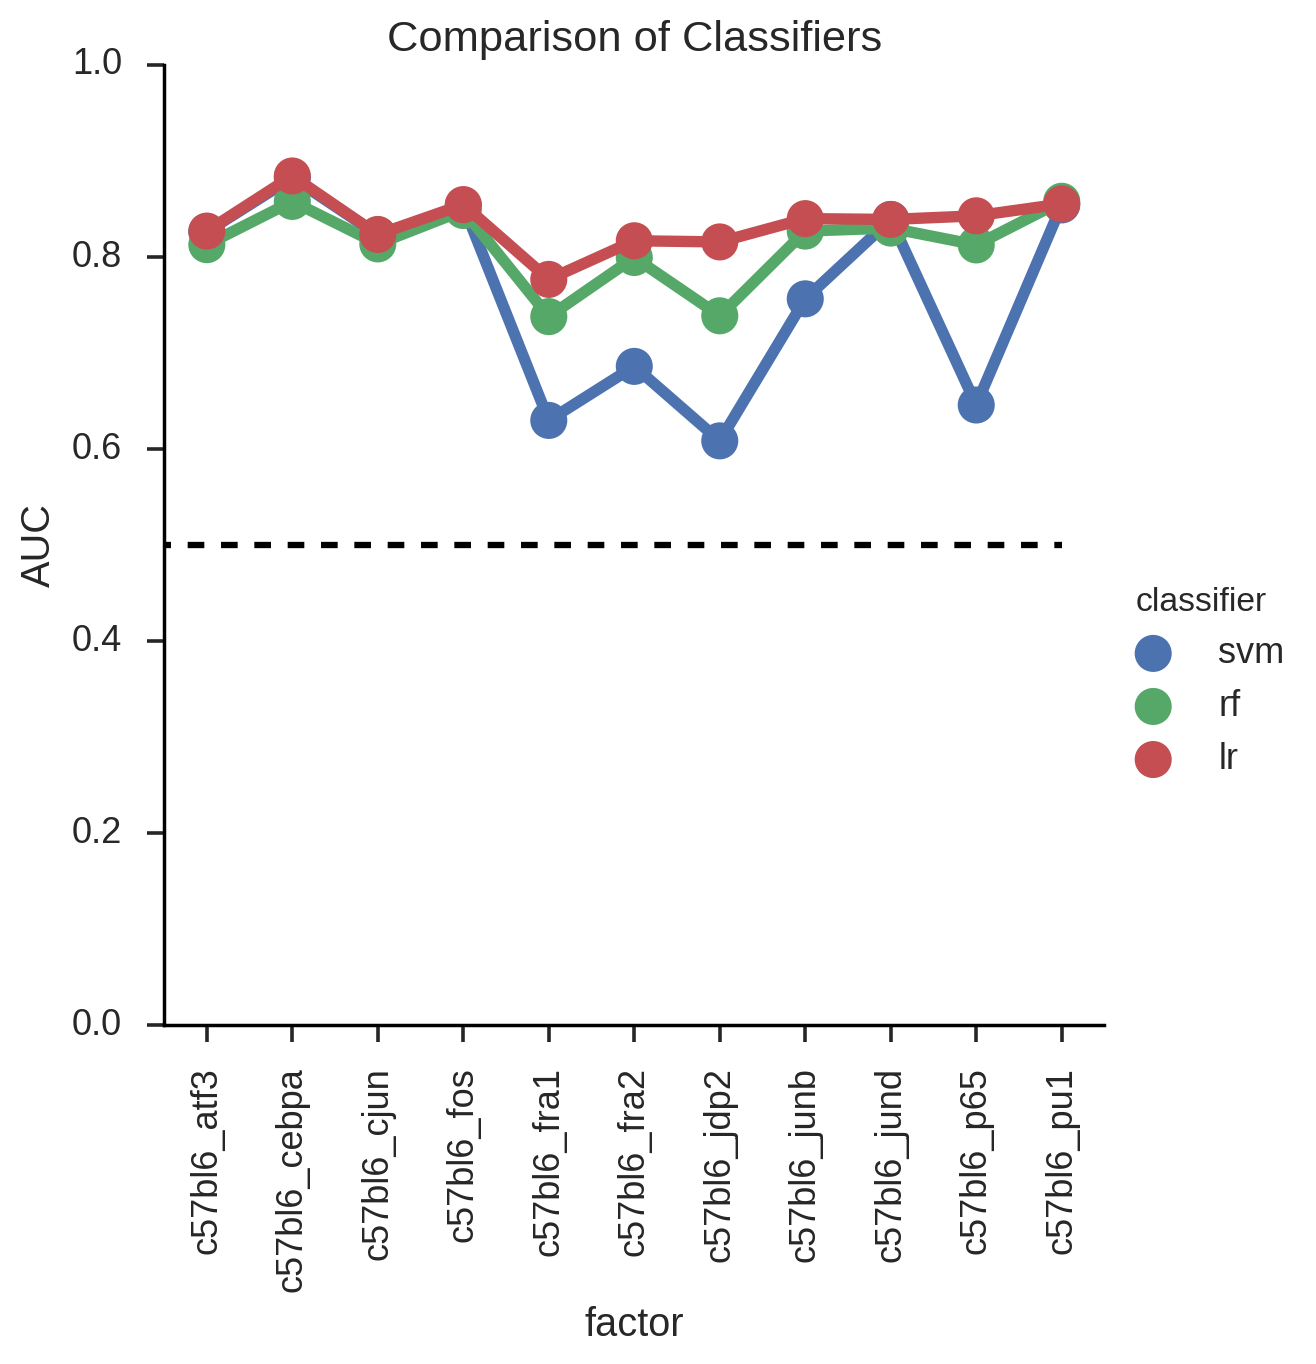

In [102]:
with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                    
                         }):
    sns.factorplot(data = classifier_frame, 
                   x='factor', 
                   y='AUC', 
                   hue='classifier',
                  kind='point', 
                  size=6)
    plt.xticks(rotation=90);
    plt.title('Comparison of Classifiers')
    plt.ylim(0,1)
    plt.hlines(y=0.5, xmin=-1, xmax=10, color='black', linestyle='--')
    plt.show()

## Logistic Regression Binding Predictions

### Different Test Fraction Sizes

#### For Individual factors

In [46]:
### test predictive ability with different test fraction sizes
factor_auc_dict = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values

for factor in [x for x in _factors if not 'atac' in x]:
    factor_auc_dict[factor] = []
    print(factor)
    for test_size in np.arange(0.1,1.0,0.1):
        features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor)


        training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = test_size, tolerance = 0.01)
        print('test fraction:',test_size, 'num training features', len(training_features), 'num test features', len(test_features))


        #  Run classifier
        lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

        lr_classifier.fit(training_features, training_labels)
        # retreive probabilities for each classifier
        probas_lr = lr_classifier.predict_proba(test_features)
      
        fpr_lr, tpr_lr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
        roc_auc_lr = auc(fpr_lr, tpr_lr)
        factor_auc_dict[factor].append(roc_auc_lr)

auc_frame = pd.DataFrame(factor_auc_dict)
auc_frame.index = np.arange(0.1,1.0,0.1)



atf3
total: 81822 filtered: 65246 true gc: 0.47324 false gc: 0.48324 difference: 0.01
test fraction: 0.1 num training features 58721 num test features 6525
total: 81822 filtered: 65234 true gc: 0.47324 false gc: 0.48324 difference: 0.01
test fraction: 0.2 num training features 52186 num test features 13048
total: 81822 filtered: 65333 true gc: 0.47324 false gc: 0.48324 difference: 0.01
test fraction: 0.3 num training features 43555 num test features 21778
total: 81822 filtered: 65309 true gc: 0.47324 false gc: 0.48324 difference: 0.01
test fraction: 0.4 num training features 32654 num test features 32655
total: 81822 filtered: 65448 true gc: 0.47324 false gc: 0.48324 difference: 0.01
test fraction: 0.5 num training features 32724 num test features 32724
total: 81822 filtered: 65435 true gc: 0.47324 false gc: 0.48324 difference: 0.01
test fraction: 0.6 num training features 32718 num test features 32717
total: 81822 filtered: 65234 true gc: 0.47324 false gc: 0.48324 difference: 0.01
tes

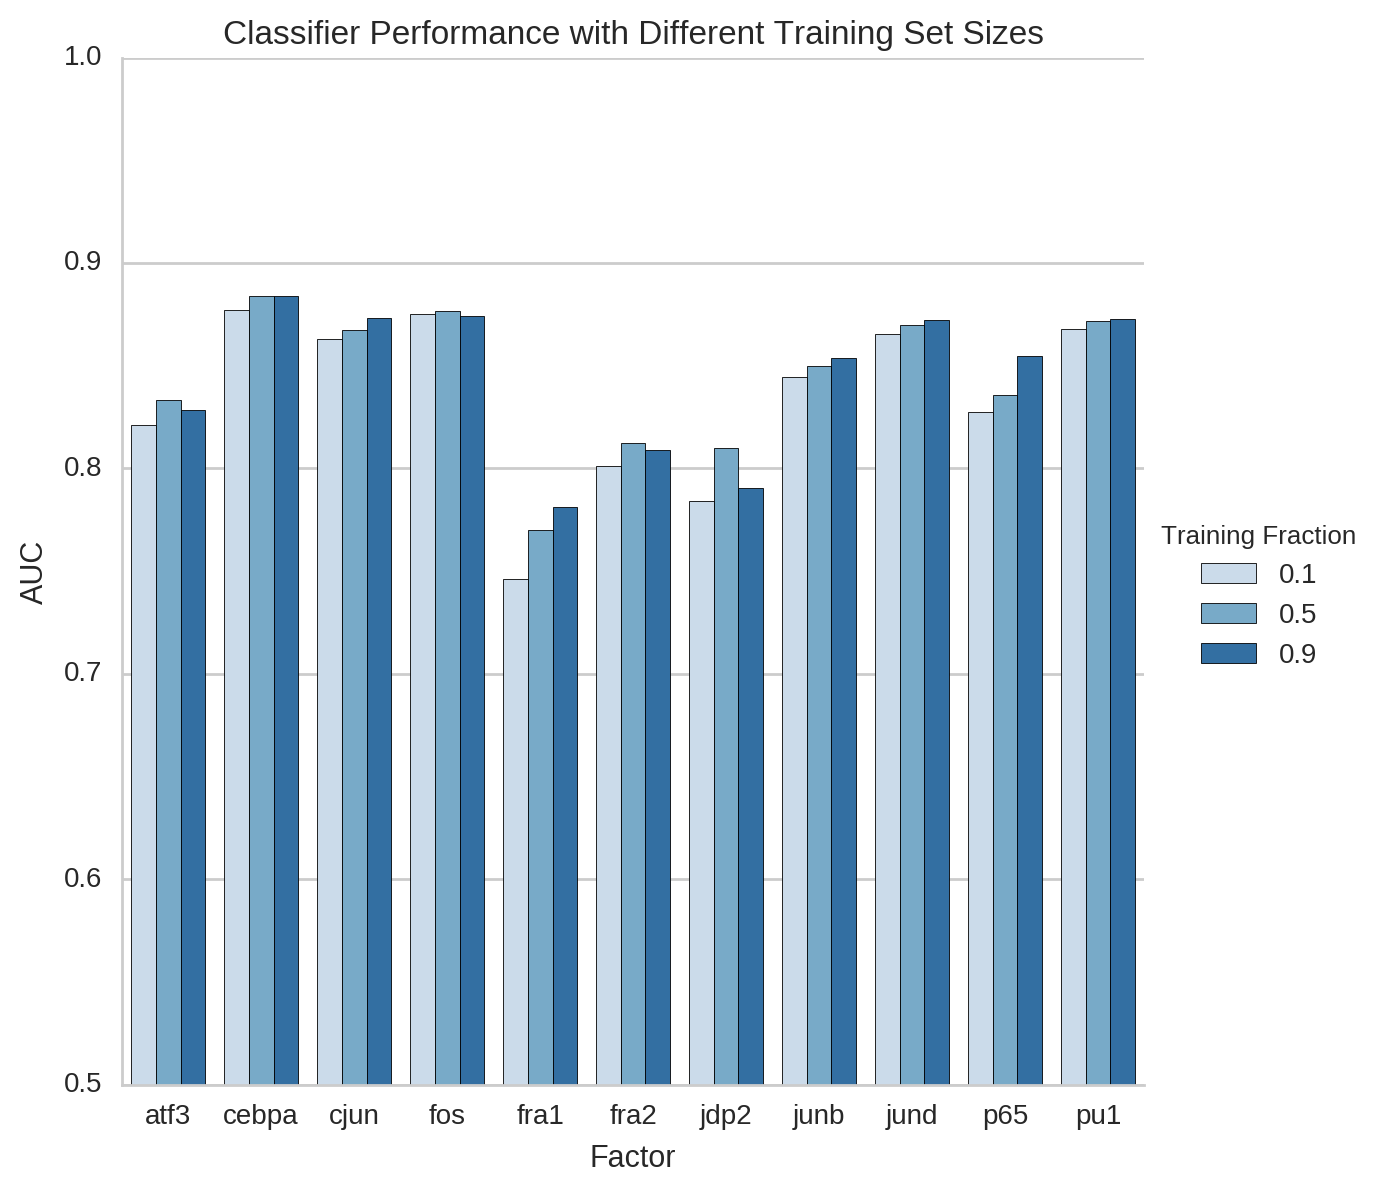

In [47]:
stacked_frame = pd.DataFrame(auc_frame.stack())
stacked_frame['Factor'] = [x[1] for x in stacked_frame.index.values]
stacked_frame['Training Fraction'] = [np.round(1- x[0],3) for x in stacked_frame.index.values]
stacked_frame.columns = ['AUC', 'Factor', 'Training Fraction']
stacked_frame.index = range(stacked_frame.shape[0])
with sns.axes_style('whitegrid'):
    sns.factorplot(data=stacked_frame[stacked_frame['Training Fraction'].isin([0.1,0.5, 0.9])], 
                   x='Factor', y='AUC', hue='Training Fraction', size=6, kind='bar', palette='Blues')
    plt.ylim(0.5,1)
    plt.title('Classifier Performance with Different Training Set Sizes')

#### For AP-1 Dimers

In [48]:
factorPairs = []
ap1_members = ['atf3','cjun', 'fra1','fra2', 'fos', 'jdp2', 'junb','jund']    
for i in range(len(ap1_members)-1):
    for j in range(i+1, len(ap1_members)):
        factorPairs.append(('c57bl6_'+ap1_members[i],'c57bl6_'+ ap1_members[j]))

In [69]:
### for all peaks in vehicle and KLA for all motifs for dimers
factorPair_auc_dict = {}

c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
 
for factorPair in factorPairs:
    
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    kla_labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_kla') & summary_frame['Factors'].str.contains(factorPair[1] +'_kla')
    veh_labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_veh') & summary_frame['Factors'].str.contains(factorPair[1] +'_veh')
    labels = veh_labels + kla_labels
    
    factorPair_auc_dict['_'.join(factorPair).replace('c57bl6_','')] = []

    for test_size in [0.1, 0.5, 0.9]:
        
        training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = test_size, tolerance = 0.01)

        #  Run classifier
        lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

        lr_classifier.fit(training_features, training_labels)
        # retreive probabilities for each classifier
        probas_lr = lr_classifier.predict_proba(test_features)
        # retrieve predictions for each classifier

        fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
        roc_auc = auc(fpr, tpr)
        factorPair_auc_dict['_'.join(factorPair).replace('c57bl6_','')].append(roc_auc)

        print(factorPair, roc_auc)
        
        
auc_pair_frame = pd.DataFrame(factorPair_auc_dict)
auc_pair_frame.index = [0.1, 0.5, 0.9]




total: 81822 filtered: 66847 true gc: 0.47493 false gc: 0.48493 difference: 0.01
('c57bl6_atf3', 'c57bl6_cjun') 0.832699865853
total: 81822 filtered: 66914 true gc: 0.47493 false gc: 0.48493 difference: 0.01
('c57bl6_atf3', 'c57bl6_cjun') 0.831325496247
total: 81822 filtered: 66821 true gc: 0.47493 false gc: 0.48493 difference: 0.00999
('c57bl6_atf3', 'c57bl6_cjun') 0.820681003632
total: 81822 filtered: 81822 true gc: 0.49927 false gc: 0.49932 difference: 6e-05
('c57bl6_atf3', 'c57bl6_fra1') 0.847134849961
total: 81822 filtered: 81822 true gc: 0.49927 false gc: 0.49932 difference: 6e-05
('c57bl6_atf3', 'c57bl6_fra1') 0.846219586328
total: 81822 filtered: 81822 true gc: 0.49927 false gc: 0.49932 difference: 6e-05
('c57bl6_atf3', 'c57bl6_fra1') 0.817999192917
total: 81822 filtered: 80854 true gc: 0.48941 false gc: 0.49941 difference: 0.01
('c57bl6_atf3', 'c57bl6_fra2') 0.848769016611
total: 81822 filtered: 80878 true gc: 0.48941 false gc: 0.49941 difference: 0.01
('c57bl6_atf3', 'c57bl6_

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:184: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


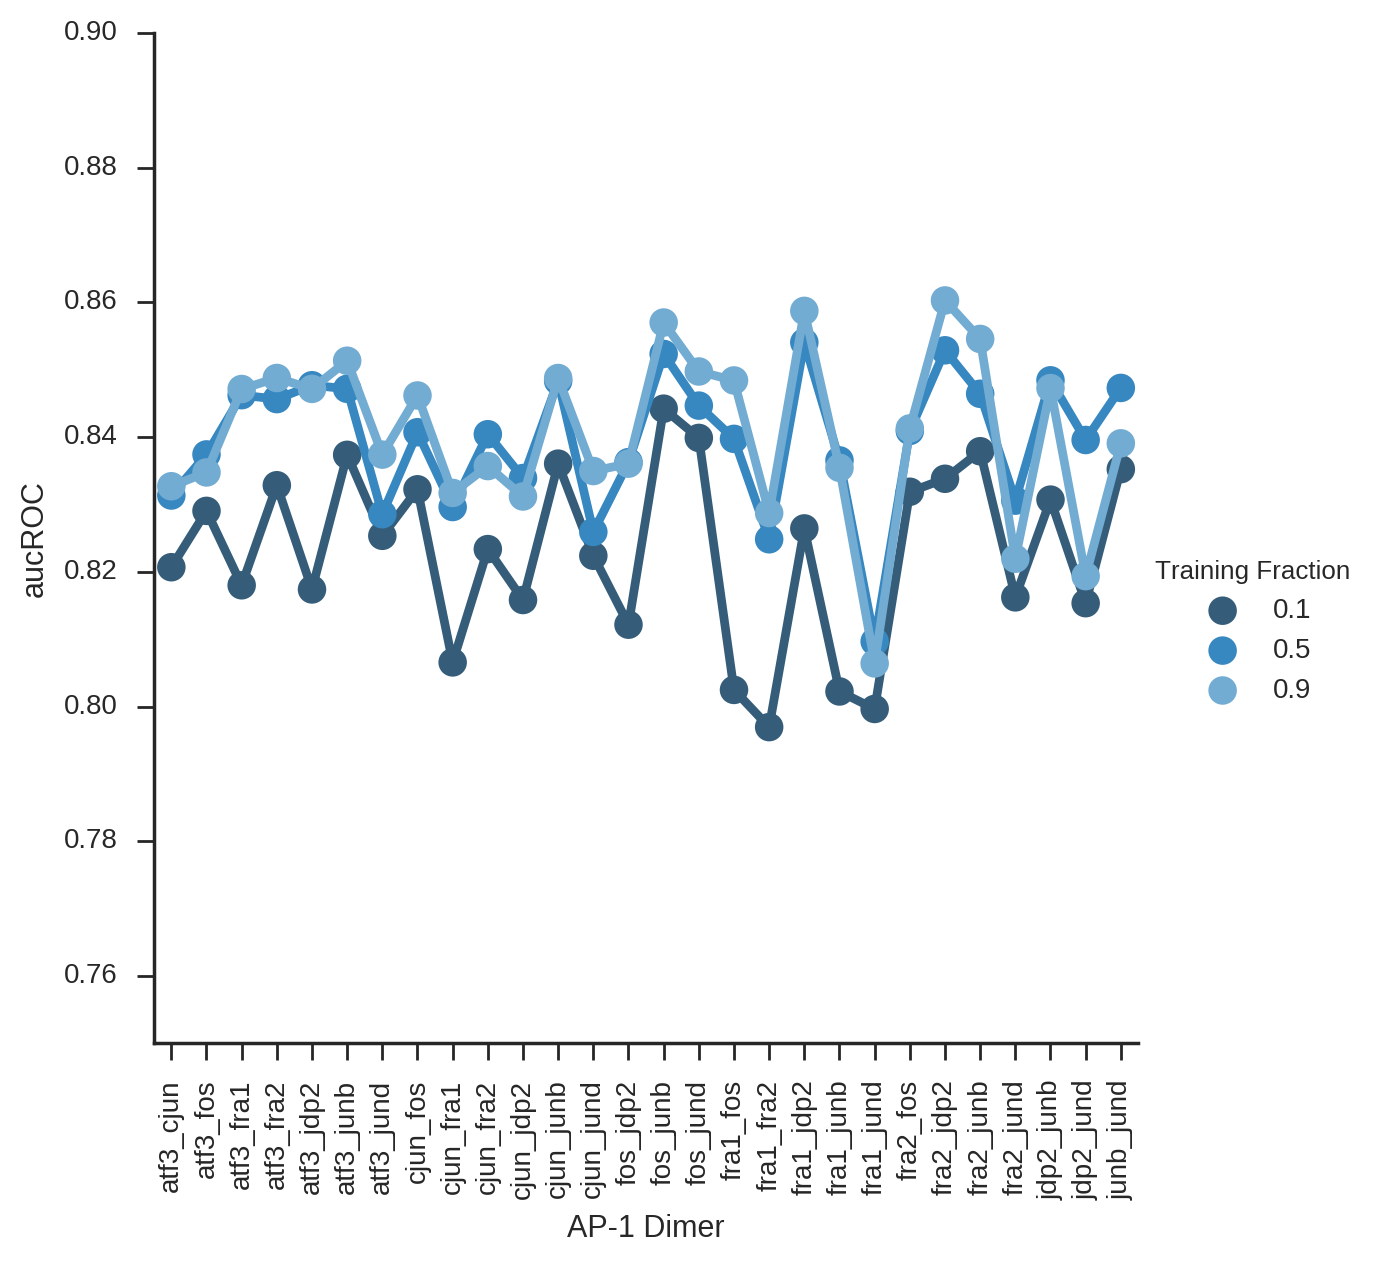

In [97]:
stacked_frame = pd.DataFrame(auc_pair_frame.stack())
stacked_frame['Factor'] = [x[1] for x in stacked_frame.index.values]
stacked_frame['Training Fraction'] = [np.round(1- x[0],3) for x in stacked_frame.index.values]
stacked_frame.columns = ['AUC', 'Factor', 'Training Fraction']
stacked_frame.index = range(stacked_frame.shape[0])
with sns.axes_style('ticks'):
    sns.factorplot(data=stacked_frame[stacked_frame['Training Fraction'].isin([0.1,0.5, 0.9])], 
                   x='Factor', y='AUC', hue='Training Fraction', size=6, kind='point', palette='Blues_d')
    plt.ylim(0.75,0.9)
#     plt.title('Classifier Performance with Different Training Set Sizes')
    plt.ylabel('aucROC')
    plt.xlabel('AP-1 Dimer')
    plt.xticks(rotation=90)

### Regressing on Individual Motifs

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
### for all peaks in vehicle and KLA
factor_coeff_dict = {}
factor_auc_dict = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values
motifs = sorted(normed_motif_frame.columns.values)
for factor in _factors:
    print(factor)
    factor_coeff_dict[factor] = []
    factor_auc_dict[factor] = []
    current_coeffs = factor_coeff_dict[factor]
    current_aucs = factor_auc_dict[factor]
    for motif in motifs:
        # get features and labels
        features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)][motif]
        labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor)
        # split test and training data
        training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = 0.5, tolerance = 0.01)
        training_features = training_features.reshape(training_features.shape[0],1)
        test_features = test_features.reshape(test_features.shape[0],1)
        training_labels = training_labels.reshape(training_labels.shape[0],1)
        test_labels = test_labels.reshape(test_labels.shape[0],1)
        lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
        
        #  Run classifier        
        lr_classifier.fit(training_features, training_labels)
        # retreive probabilities for each classifier
        probas_lr = lr_classifier.predict_proba(test_features)
        # retrieve coefficient
        coefficient = lr_classifier.coef_[0][0]

        fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
        roc_auc = auc(fpr, tpr)

        current_coeffs.append(coefficient)
        current_aucs.append(roc_auc)
        print(motif,coefficient,roc_auc)

coefficients_frame_ind = pd.DataFrame(factor_coeff_dict)
coefficients_frame_ind = coefficients_frame_ind[sorted(_factors)]
coefficients_frame_ind.index = motifs

auc_frame_ind = pd.DataFrame(factor_auc_dict)
auc_frame_ind = auc_frame_ind[sorted(_factors)]
auc_frame_ind.index = motifs

In [168]:
### roc curve for best motif ###
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values

for factor, motif in tuple(zip(auc_frame_ind.idxmax().index.values,auc_frame_ind.idxmax())):
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)][motif]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor)
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    training_features = training_features.reshape(training_features.shape[0],1)
    test_features = test_features.reshape(test_features.shape[0],1)
    training_labels = training_labels.reshape(training_labels.shape[0],1)
    test_labels = test_labels.reshape(test_labels.shape[0],1)
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    with sns.axes_style('whitegrid'):
        fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1],linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(factor+' AUC='+str(np.round(roc_auc,3)))
        plt.gca().set_aspect('equal') 
        plt.show()

NameError: name 'auc_frame_ind' is not defined

In [86]:
### for all peaks in vehicle and KLA
factor_coeff_dict = {}
factor_auc_dict_all = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values
for factor in [x for x in _factors if not 'atac' in x]:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor)
    

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
        
    coefficients = lr_classifier.coef_    
    factor_coeff_dict[factor] = coefficients.flatten()
    factor_auc_dict_all[factor] = roc_auc
    print(factor, roc_auc)
    
coefficients_frame_all = pd.DataFrame(factor_coeff_dict)
coefficients_frame_all = coefficients_frame_all[sorted(_factors)]
coefficients_frame_all.index = motif_score_frame.columns.values[3:]


total: 81822 filtered: 65122 true gc: 0.47324 false gc: 0.48324 difference: 0.01
atf3 0.830744652268
total: 81822 filtered: 62687 true gc: 0.4695 false gc: 0.4795 difference: 0.00999
cebpa 0.88528296406
total: 81822 filtered: 80595 true gc: 0.49458 false gc: 0.50457 difference: 0.01
cjun 0.868092073655
total: 81822 filtered: 78885 true gc: 0.49282 false gc: 0.50282 difference: 0.01
fos 0.877798894485
total: 81822 filtered: 59270 true gc: 0.5283 false gc: 0.5183 difference: 0.01
fra1 0.772101765193
total: 81822 filtered: 81822 true gc: 0.50569 false gc: 0.49784 difference: 0.00784
fra2 0.814494234916
total: 81822 filtered: 81822 true gc: 0.49066 false gc: 0.49979 difference: 0.00913
jdp2 0.80941840502
total: 81822 filtered: 74723 true gc: 0.48689 false gc: 0.49689 difference: 0.01
junb 0.850471506212
total: 81822 filtered: 81822 true gc: 0.50216 false gc: 0.49367 difference: 0.00849
jund 0.869970710772
total: 81822 filtered: 76163 true gc: 0.51219 false gc: 0.50219 difference: 0.01
p65 

In [87]:
### for all peaks in vehicle and KLA using significant motifs
threshold = 2
# mean = np.mean(coefficients_frame_all.values)
# std = np.std(coefficients_frame_all.values)
factor_motifs_dict = {}
significant_motifs = set()
for factor in coefficients_frame_all.columns.values:
    weights = coefficients_frame_all[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    for m in motif_hits:
        significant_motifs.add(m)
    print(factor, mean-threshold*std, mean+threshold*std, len(negative_hits), len(positive_hits))

    factor_motifs_dict[factor] = motif_hits
significant_motifs = sorted(significant_motifs)
    
factor_coeff_dict = {}
factor_auc_dict_all_best = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values

for factor in _factors:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)][significant_motifs]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor)
    

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
        
    coefficients = lr_classifier.coef_    
    factor_coeff_dict[factor] = coefficients.flatten()
    factor_auc_dict_all_best[factor] = roc_auc
    print(factor, roc_auc)
    
coefficients_frame_all_best = pd.DataFrame(factor_coeff_dict)
coefficients_frame_all_best = coefficients_frame_all_best[sorted(_factors)]
coefficients_frame_all_best.index = significant_motifs



atf3 -0.532967820577 0.756539023593 2 7
cebpa -1.22714372378 1.37127103288 0 2
cjun -0.441969725911 0.828564449106 3 7
fos -0.569317962097 0.863620981252 2 6
fra1 -0.444118109377 0.613478202593 3 4
fra2 -0.438097519022 0.612867900523 6 3
jdp2 -0.510294235295 0.688152198083 3 6
junb -0.511838590153 0.784668681444 3 6
jund -0.478302961858 0.85390380022 3 7
p65 -0.607978802643 0.791130170269 2 4
pu1 -0.836014770242 1.11365565695 1 5
total: 81822 filtered: 65244 true gc: 0.47324 false gc: 0.48324 difference: 0.01
atf3 0.812448611995
total: 81822 filtered: 62783 true gc: 0.4695 false gc: 0.4795 difference: 0.01
cebpa 0.87909808467
total: 81822 filtered: 80580 true gc: 0.49458 false gc: 0.50458 difference: 0.01
cjun 0.838952119853
total: 81822 filtered: 78896 true gc: 0.49282 false gc: 0.50282 difference: 0.01
fos 0.859482075085
total: 81822 filtered: 59240 true gc: 0.5283 false gc: 0.5183 difference: 0.01
fra1 0.726623823629
total: 81822 filtered: 81822 true gc: 0.50569 false gc: 0.49784 di

In [88]:
auc_frame_ind.idxmax()

atf3     ap-1
cebpa    cebp
cjun     ap-1
fos      ap-1
fra1      zfx
fra2     ap-1
jdp2     ap-1
junb     ap-1
jund     ap-1
p65       rel
pu1      spib
dtype: object

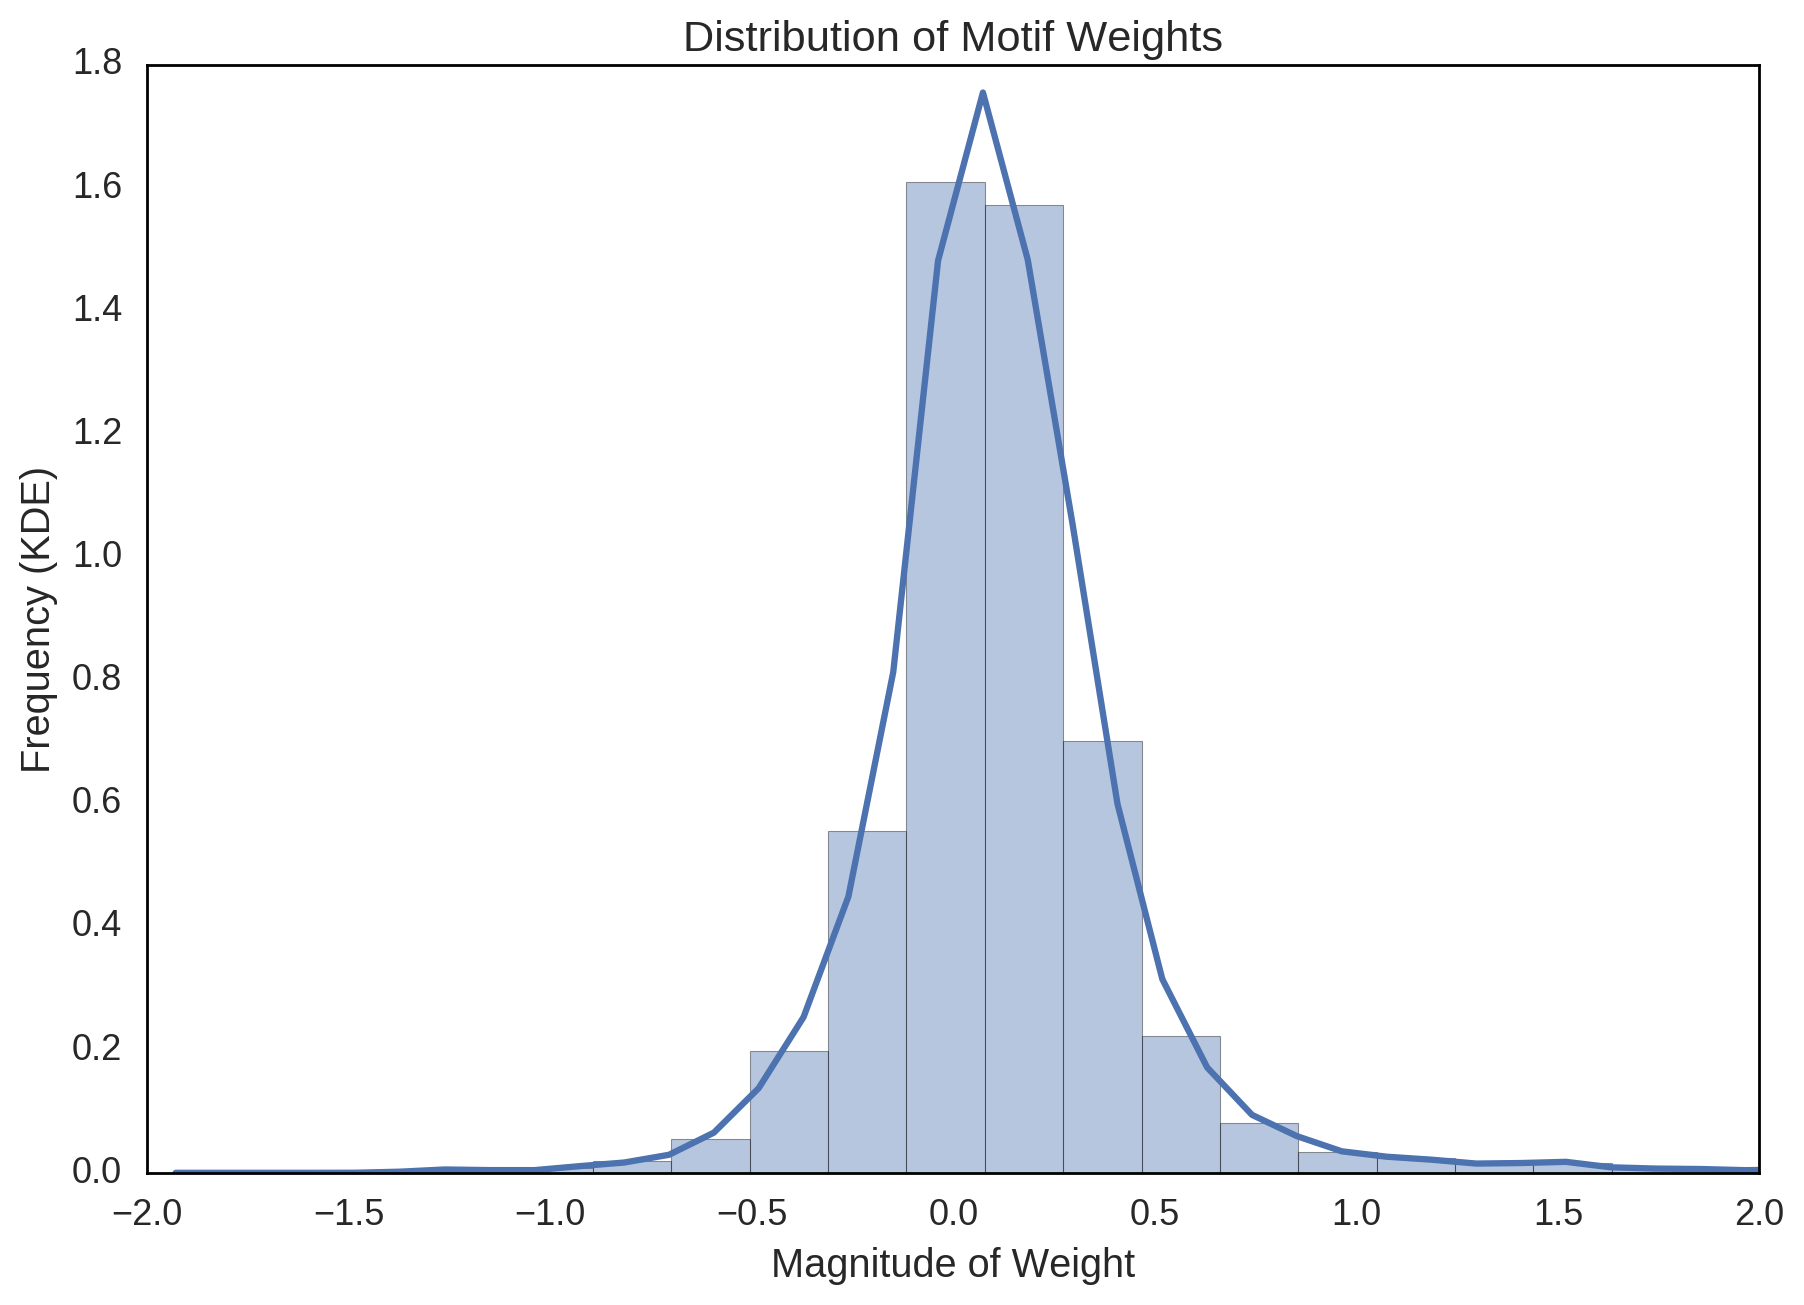

In [97]:
with sns.axes_style('whitegrid',{'axes.grid':False,'axes.edgecolor':'black'}):
    sns.distplot(coefficients_frame_all.values.flatten())
    plt.xlabel('Magnitude of Weight')
    plt.ylabel('Frequency (KDE)')
    plt.xlim(-2,2)
    plt.title('Distribution of Motif Weights')

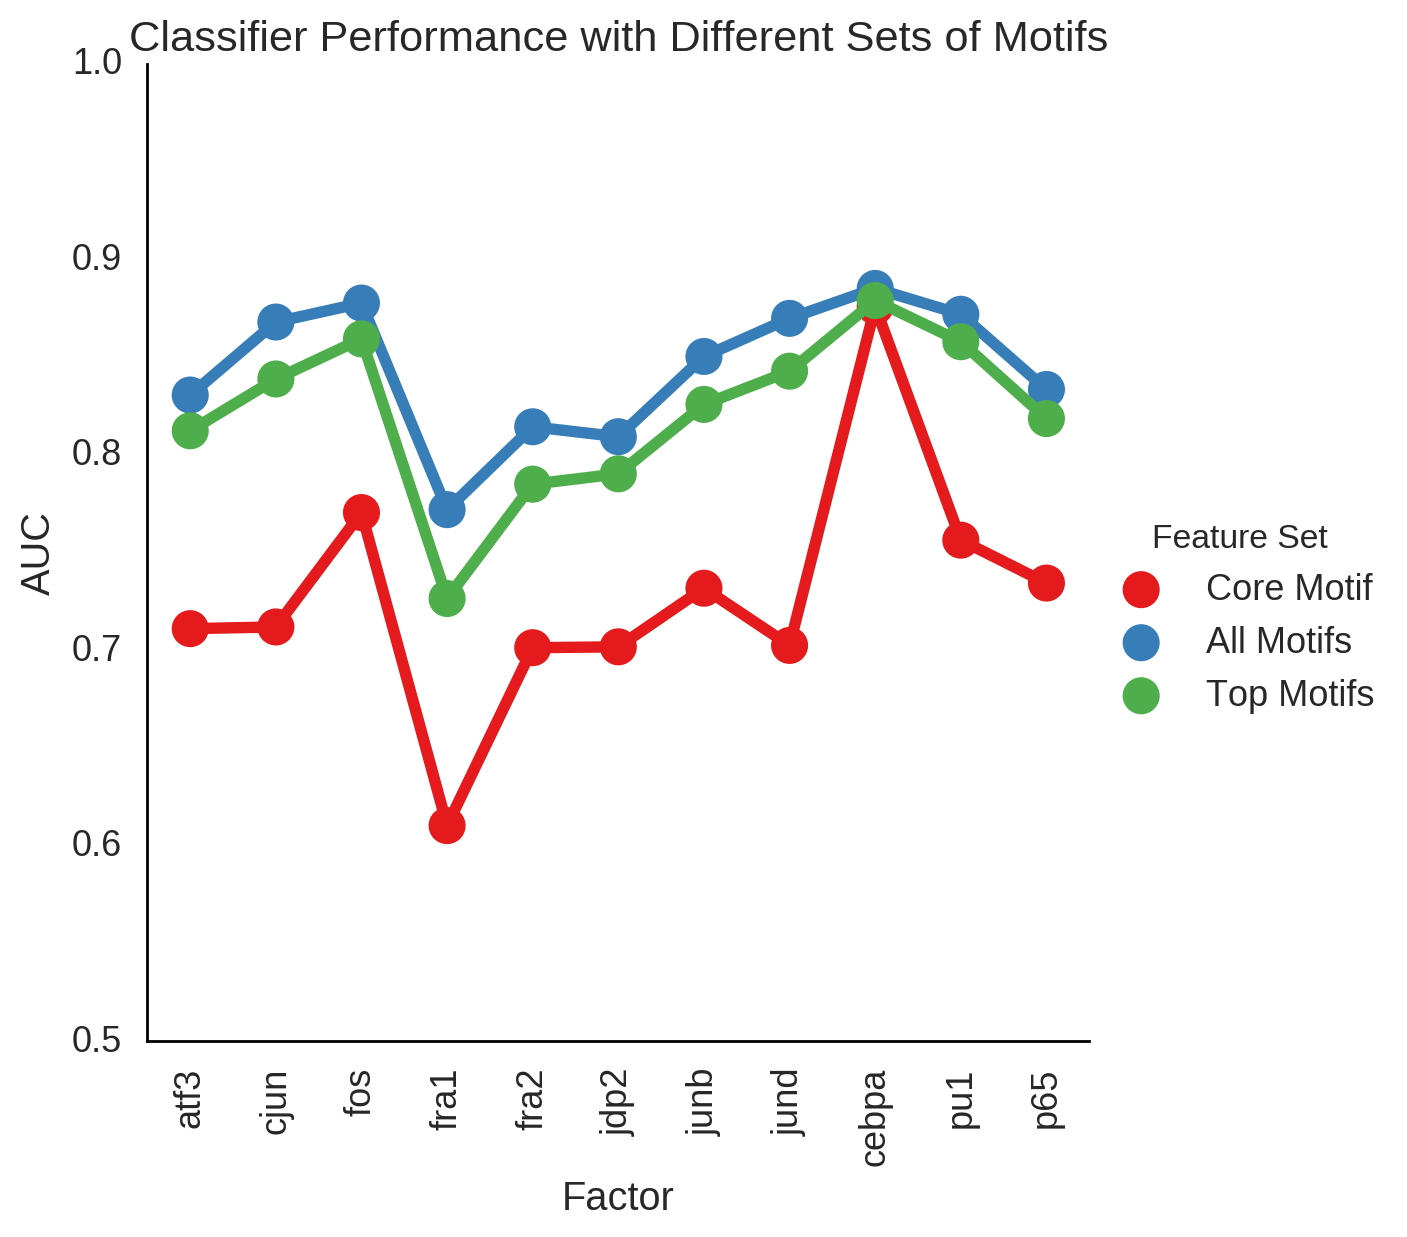

In [98]:
ind_max_aucs = auc_frame_ind.max()
factors = []
aucs = []
features = []
for factor in sorted(factor_auc_dict_all.keys()):
    factors = factors + 3 * [factor]
    features = features + ['Core Motif', 'All Motifs', 'Top Motifs']
    aucs.append(ind_max_aucs[factor])
    aucs.append(factor_auc_dict_all[factor])
    aucs.append(factor_auc_dict_all_best[factor])
with sns.axes_style('whitegrid',{'axes.grid':False,'axes.edgecolor':'black'}):
    plottingFrame = sns.factorplot(data = pd.DataFrame({'Factor':factors,
                                                         'AUC':aucs,
                                                         'Feature Set':features}),
                                x='Factor',
                                y='AUC',
                                hue='Feature Set',
                                palette='Set1',
                                size=6,
                                order = ['atf3', 'cjun', 'fos', 'fra1', 'fra2', 'jdp2', 'junb','jund','cebpa','pu1','p65'])
    plt.xticks(rotation=90)
    plt.ylim(0.5,1)
    plt.title('Classifier Performance with Different Sets of Motifs')

In [ ]:
### for all vehicle peaks
factor_coeff_dict = {}
c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_veh' for x in _factors]].sum(axis=1) > 0].index.values


for factor in _factors:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor + '_veh')
    
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    predictions_lr = lr_classifier.predict(test_features)
    
    coefficients = lr_classifier.coef_
    intercept = lr_classifier.intercept_
    
    factor_coeff_dict[factor] = coefficients.flatten()
coefficients_frame_veh = pd.DataFrame(factor_coeff_dict)
coefficients_frame_veh = coefficients_frame_veh[sorted(_factors)]
coefficients_frame_veh.index = motif_score_frame.columns.values[3:]



In [ ]:
### for all KLA peaks
factor_coeff_dict = {}
c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_kla' for x in _factors]].sum(axis=1) > 0].index.values


for factor in _factors:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(factor + '_kla')

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    predictions_lr = lr_classifier.predict(test_features)
    
    coefficients = lr_classifier.coef_
    intercept = lr_classifier.intercept_
    
    factor_coeff_dict[factor] = coefficients.flatten()
coefficients_frame_kla = pd.DataFrame(factor_coeff_dict)
coefficients_frame_kla = coefficients_frame_kla[sorted(_factors)]
coefficients_frame_kla.index = motif_score_frame.columns.values[3:]




In [ ]:
### plot coefficents for both vehicle and kla
threshold = 2.5
coeff_std = np.std(coefficients_frame_all.values.flatten())
coeff_mean = np.mean(coefficients_frame_all.values.flatten())

cg = sns.clustermap(coefficients_frame_all[(coefficients_frame_all.max(axis=1) > coeff_mean + threshold* coeff_std) |
                                       (coefficients_frame_all.min(axis=1) < coeff_mean - threshold* coeff_std)
                                      ][['atf3', 'cjun', 'fos', 'fra1', 'fra2', 'jdp2', 'junb','jund','cebpa','pu1','p65']],
                   vmax=(coeff_mean + threshold* coeff_std),
                   vmin=(coeff_mean - threshold* coeff_std),
                   center = coeff_mean,
                   annot=True,annot_kws={"size": 8},
                    col_cluster = False
                   )
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);



In [ ]:
coeff_std = np.std(coefficients_frame_veh.values.flatten());
coeff_mean = np.mean(coefficients_frame_veh.values.flatten());
toExclude = ['jund', 'fos', 'junb'];
threshold =2.5;

cg = sns.clustermap(coefficients_frame_veh[
                                       (coefficients_frame_veh[[x for x in _factors if not x in toExclude]].max(axis=1) > coeff_mean + threshold* coeff_std) |
                                       (coefficients_frame_veh[[x for x in _factors if not x in toExclude]].min(axis=1) < coeff_mean - threshold* coeff_std)
                                      ],
                   vmax=(coeff_mean + threshold* coeff_std),
                   vmin=(coeff_mean - threshold* coeff_std),
                   center = coeff_mean,
                   annot=True,annot_kws={"size": 8});

plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);
# plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), fontsize=10, rotation=0);

# hm = cg.ax_heatmap.get_position()
# cg.ax_heatmap.set_position([hm.x0, hm.y0, hm.width, hm.height*2])

# rd_pos = cg.ax_row_dendrogram.get_position()
# cg.ax_row_dendrogram.set_position([rd_pos.x0, rd_pos.y0, rd_pos.width, rd_pos.height*2])

# cd_pos = cg.ax_col_dendrogram.get_position()
# cg.ax_col_dendrogram.set_position([cd_pos.x0, cd_pos.y0+0.62, cd_pos.width, cd_pos.height])



In [ ]:
### plot coefficients for KLA treatment ###
coeff_std = np.std(coefficients_frame_kla.values.flatten())
coeff_mean = np.mean(coefficients_frame_kla.values.flatten())
threshold = 2.5

cg = sns.clustermap(coefficients_frame_kla[(coefficients_frame_kla.max(axis=1) > coeff_mean + threshold* coeff_std) |
                                       (coefficients_frame_kla.min(axis=1) < coeff_mean - threshold* coeff_std)
                                      ],
                   vmax=(coeff_mean + threshold* coeff_std),
                   vmin=(coeff_mean - threshold* coeff_std),
                   center = coeff_mean,
                   annot=True,annot_kws={"size": 8})
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);




## Pairs of transcription factors

In [49]:
factorPairs = []
ap1_members = ['atf3','cjun', 'fra1','fra2', 'fos', 'jdp2', 'junb','jund']

# for i in range(len(_factors)-1):
#     for j in range(i+1, len(_factors)):
#         factorPairs.append(('c57bl6_'+_factors[i],'c57bl6_'+ _factors[j]))
        
        
for i in range(len(ap1_members)-1):
    for j in range(i+1, len(ap1_members)):
        factorPairs.append(('c57bl6_'+ap1_members[i],'c57bl6_'+ ap1_members[j]))

In [ ]:
aucs = []
classifiers = []
metrics = []
factors = []

c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
    
for factorPair in factorPairs:
    print(factorPair)
    
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0]) & summary_frame['Factors'].str.contains(factorPair[1])

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.2, tolerance = 0.01)

    # Run classifier
    svm_classifier = svm.SVC(kernel='linear', probability=True)
    rf_classifier = sklearn.ensemble.RandomForestClassifier(n_estimators=50)
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    svm_classifier.fit(training_features, training_labels)
    rf_classifier.fit(training_features, training_labels)
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_svm = svm_classifier.predict_proba(test_features)
    probas_rf = rf_classifier.predict_proba(test_features)
    probas_lr = lr_classifier.predict_proba(test_features)
    
    # roc curv for svm
    fpr_svm, tpr_svm, thresholds_roc_svm = sklearn.metrics.roc_curve(test_labels, probas_svm[:, 1])
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    aucs.append(roc_auc_svm)
    
    # roc curv for rf
    fpr_rf, tpr_rf, thresholds_roc_rf = sklearn.metrics.roc_curve(test_labels, probas_rf[:, 1])
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    aucs.append(roc_auc_rf)
   
    # roc curv for lr
    fpr_lr, tpr_lr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    aucs.append(roc_auc_lr)
       
    print('training set|', 'num samples:', len(training_labels), 'num True:', np.sum(training_labels))
    print('test set    |', 'num samples:', len(test_labels), 'num True:', np.sum(test_labels))
    print('lr_auc', roc_auc_lr)
    
    classifiers = classifiers + ['svm', 'rf', 'lr']
    factors = factors + ['_'.join(factorPair)] * 3
classifier_frame = pd.DataFrame({'factor':factors, 
                                 'AUC':aucs,
                                'classifier':classifiers})


('c57bl6_atf3', 'c57bl6_cjun')
total:

In [ ]:
sns.factorplot(data = classifier_frame, 
               x='factor', 
               y='AUC', 
               hue='classifier',
              kind='point', size =10)
plt.xticks(rotation=90);
plt.title('ROC AUC')
plt.show()

In [60]:
### for all peaks in vehicle and KLA for all motifs
factor_coeff_dict = {}
factor_auc_dict_pairs = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
 
for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    kla_labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_kla') & summary_frame['Factors'].str.contains(factorPair[1] +'_kla')
    veh_labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_veh') & summary_frame['Factors'].str.contains(factorPair[1] +'_veh')
    labels = veh_labels + kla_labels
    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_pairs['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)
coefficients_frame_all_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_all_pairs.index = motif_score_frame.columns.values[3:]

total: 81822 filtered: 66841 true gc: 0.47493 false gc: 0.48493 difference: 0.01
('c57bl6_atf3', 'c57bl6_cjun') 0.831578260385
total: 81822 filtered: 81822 true gc: 0.49927 false gc: 0.49932 difference: 6e-05
('c57bl6_atf3', 'c57bl6_fra1') 0.848821987214
total: 81822 filtered: 80885 true gc: 0.48941 false gc: 0.49941 difference: 0.01
('c57bl6_atf3', 'c57bl6_fra2') 0.845359749598
total: 81822 filtered: 68529 true gc: 0.47674 false gc: 0.48674 difference: 0.01
('c57bl6_atf3', 'c57bl6_fos') 0.838563616326
total: 81822 filtered: 73038 true gc: 0.48079 false gc: 0.49079 difference: 0.01
('c57bl6_atf3', 'c57bl6_jdp2') 0.845352817689
total: 81822 filtered: 74651 true gc: 0.48325 false gc: 0.49325 difference: 0.01
('c57bl6_atf3', 'c57bl6_junb') 0.847912211829
total: 81822 filtered: 67194 true gc: 0.4752 false gc: 0.4852 difference: 0.01
('c57bl6_atf3', 'c57bl6_jund') 0.832473839635
total: 81822 filtered: 70702 true gc: 0.51741 false gc: 0.50741 difference: 0.01
('c57bl6_cjun', 'c57bl6_fra1') 0

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:184: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


In [61]:
coefficients_frame_all_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_all_pairs = coefficients_frame_all_pairs[sorted(coefficients_frame_all_pairs.columns.values)]
coefficients_frame_all_pairs.index = motif_score_frame.columns.values[3:]

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/seaborn-0.7.0-py3.4.egg/seaborn/matrix.py:134: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


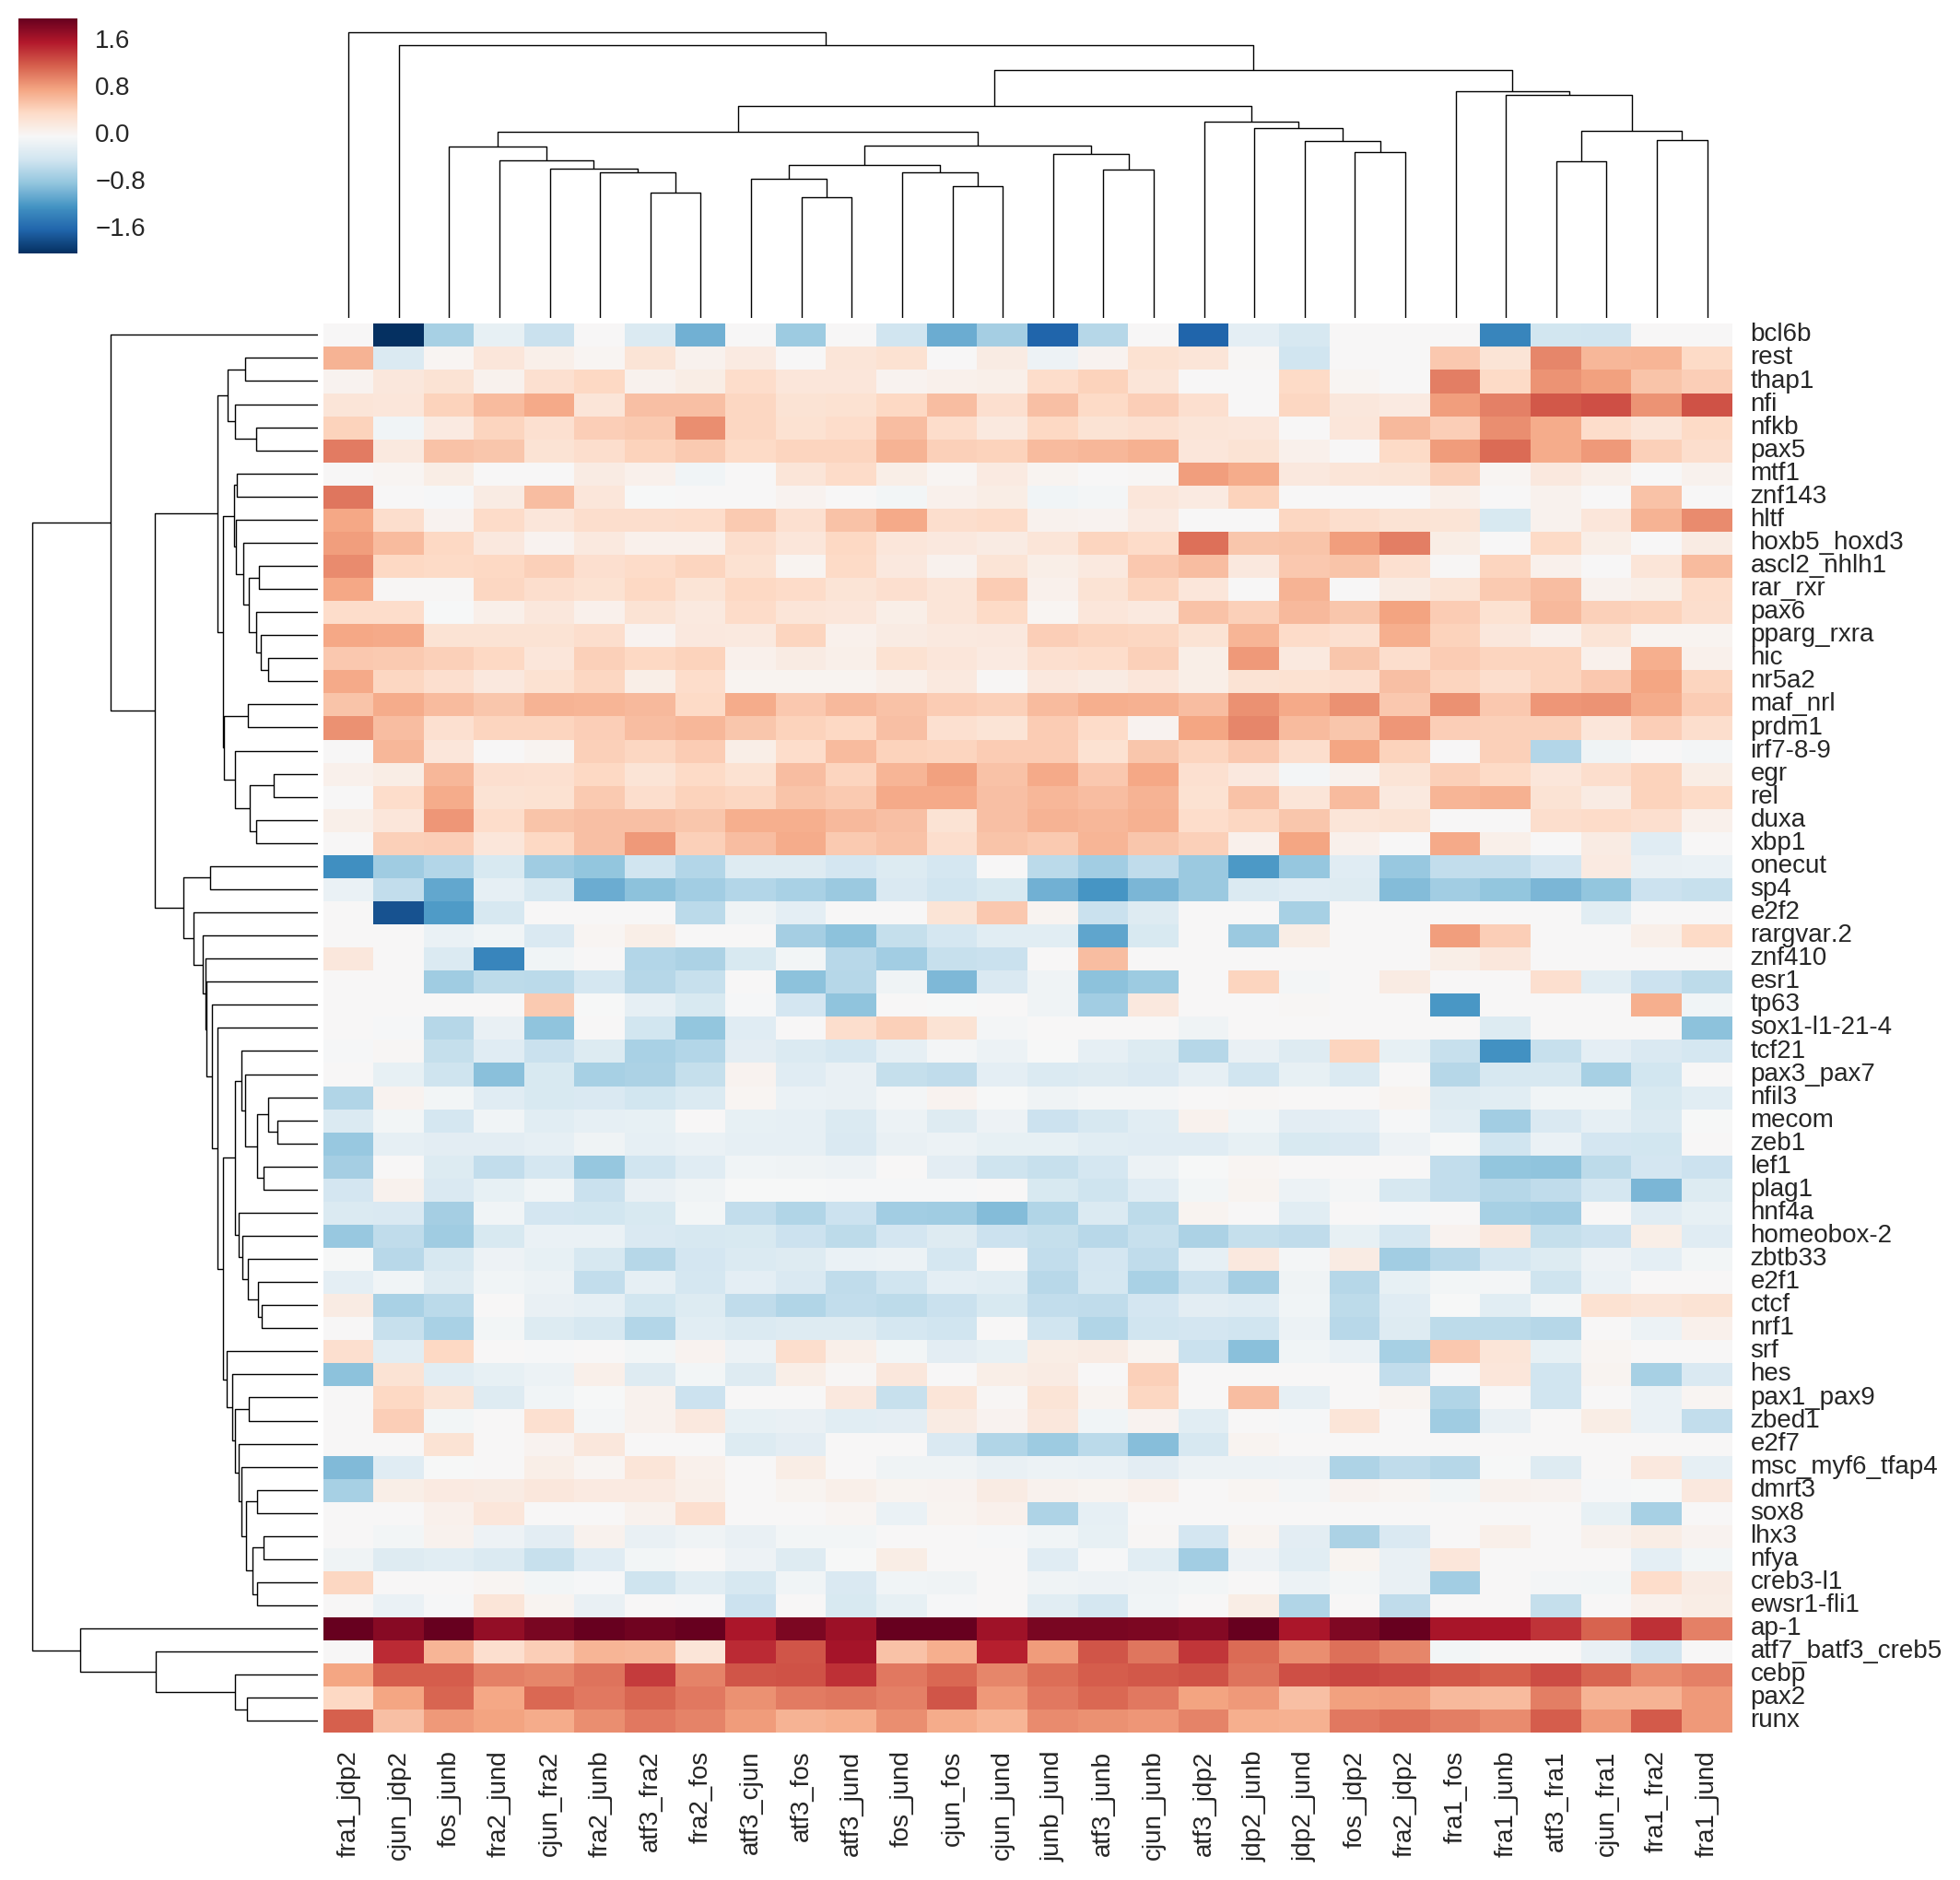

In [62]:
### plot coefficents for both vehicle and kla
threshold = 2.0
coeff_std = np.std(coefficients_frame_all_pairs.values.flatten())
coeff_mean = np.mean(coefficients_frame_all_pairs.values.flatten())

cg = sns.clustermap(coefficients_frame_all_pairs[(coefficients_frame_all_pairs.max(axis=1) > coeff_mean + threshold* coeff_std) |
                                       (coefficients_frame_all_pairs.min(axis=1) < coeff_mean - threshold* coeff_std)
                                      ],
                   vmax=-2,
                   vmin=2,
                   center = 0.0,
#                    annot=True,annot_kws={"size": 4},
                   figsize=(12,12),
                   xticklabels=[x.replace('c57bl6_','') for x in coefficients_frame_all_pairs.columns.values])
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);

plt.savefig('/home/jtao/analysis/scratch/Figure 12 - Signficant Dimer Motifs.pdf', bbox_inches='tight')


In [63]:
### for all peaks in vehicle and KLA for top motifs
factor_coeff_dict = {}
factor_auc_dict_pairs_top = {}
# motifs = ['ap-1','cebp','rel','spi1-c']
motifs = ['ap-1']
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
 
for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)][motifs]
    kla_labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_kla') & summary_frame['Factors'].str.contains(factorPair[1] +'_kla')
    veh_labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_veh') & summary_frame['Factors'].str.contains(factorPair[1] +'_veh')
    labels = veh_labels + kla_labels

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_pairs_top['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)


coefficients_frame_all_pairs_top = pd.DataFrame(factor_coeff_dict)
coefficients_frame_all_pairs_top.index = motifs

total: 81822 filtered: 66966 true gc: 0.47493 false gc: 0.48493 difference: 0.01
('c57bl6_atf3', 'c57bl6_cjun') 0.717714446451
total: 81822 filtered: 81822 true gc: 0.49927 false gc: 0.49932 difference: 6e-05
('c57bl6_atf3', 'c57bl6_fra1') 0.72611544573
total: 81822 filtered: 80826 true gc: 0.48941 false gc: 0.49941 difference: 0.01
('c57bl6_atf3', 'c57bl6_fra2') 0.749947207084
total: 81822 filtered: 68565 true gc: 0.47674 false gc: 0.48674 difference: 0.01
('c57bl6_atf3', 'c57bl6_fos') 0.74045609275
total: 81822 filtered: 73171 true gc: 0.48079 false gc: 0.49078 difference: 0.01
('c57bl6_atf3', 'c57bl6_jdp2') 0.734369475855
total: 81822 filtered: 74631 true gc: 0.48325 false gc: 0.49325 difference: 0.01
('c57bl6_atf3', 'c57bl6_junb') 0.743526957723
total: 81822 filtered: 67079 true gc: 0.4752 false gc: 0.4852 difference: 0.01
('c57bl6_atf3', 'c57bl6_jund') 0.7200213341
total: 81822 filtered: 70830 true gc: 0.51741 false gc: 0.50741 difference: 0.01
('c57bl6_cjun', 'c57bl6_fra1') 0.689

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:184: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


In [64]:
### for all peaks in vehicle and KLA using significant motifs

threshold  = 2.0
factor_motifs_dict = {}
significant_motifs = set()
# std = np.std(coefficients_frame_all_pairs.values)
# mean = np.mean(coefficients_frame_all_pairs.values)

for factor in coefficients_frame_all_pairs.columns.values:
    weights = coefficients_frame_all_pairs[factor]
    std = np.std(weights)
    mean = np.mean(weights)
    positive_hits = list(weights[weights >= mean + threshold*std].index.values)
    negative_hits = list(weights[weights <= mean - threshold*std].index.values)
    motif_hits = negative_hits + positive_hits
    for m in motif_hits:
        significant_motifs.add(m)
    print(factor, mean-threshold*std, mean+threshold*std)

    factor_motifs_dict[factor] = motif_hits
significant_motifs = sorted(significant_motifs)
    
factor_coeff_dict = {}
factor_auc_dict_all_pairs_best = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values

for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)][significant_motifs]
    kla_labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_kla') & summary_frame['Factors'].str.contains(factorPair[1] +'_kla')
    veh_labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_veh') & summary_frame['Factors'].str.contains(factorPair[1] +'_veh')
    labels = veh_labels + kla_labels

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_all_pairs_best['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)
coefficients_frame_all_pairs_best = pd.DataFrame(factor_coeff_dict)
coefficients_frame_all_pairs_best.index = significant_motifs




c57bl6_atf3_c57bl6_cjun -0.478987233375 0.694062174878
c57bl6_atf3_c57bl6_fos -0.551955918051 0.736267106227
c57bl6_atf3_c57bl6_fra1 -0.625108391521 0.807115208594
c57bl6_atf3_c57bl6_fra2 -0.580378502357 0.763853813577
c57bl6_atf3_c57bl6_jdp2 -0.625608758492 0.806570610588
c57bl6_atf3_c57bl6_junb -0.646008791945 0.810199203555
c57bl6_atf3_c57bl6_jund -0.555613251764 0.754136789934
c57bl6_cjun_c57bl6_fos -0.519415546769 0.716750896185
c57bl6_cjun_c57bl6_fra1 -0.47722190288 0.684500342771
c57bl6_cjun_c57bl6_fra2 -0.49658177198 0.699251197022
c57bl6_cjun_c57bl6_jdp2 -0.651467428858 0.833794092232
c57bl6_cjun_c57bl6_junb -0.568105316347 0.782182075105
c57bl6_cjun_c57bl6_jund -0.462527956701 0.699627133143
c57bl6_fos_c57bl6_jdp2 -0.527306100008 0.737943440377
c57bl6_fos_c57bl6_junb -0.651805312129 0.8046276416
c57bl6_fos_c57bl6_jund -0.514060661311 0.735266392275
c57bl6_fra1_c57bl6_fos -0.615343332062 0.815550775744
c57bl6_fra1_c57bl6_fra2 -0.544914647942 0.730562891464
c57bl6_fra1_c57bl6_j

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:184: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


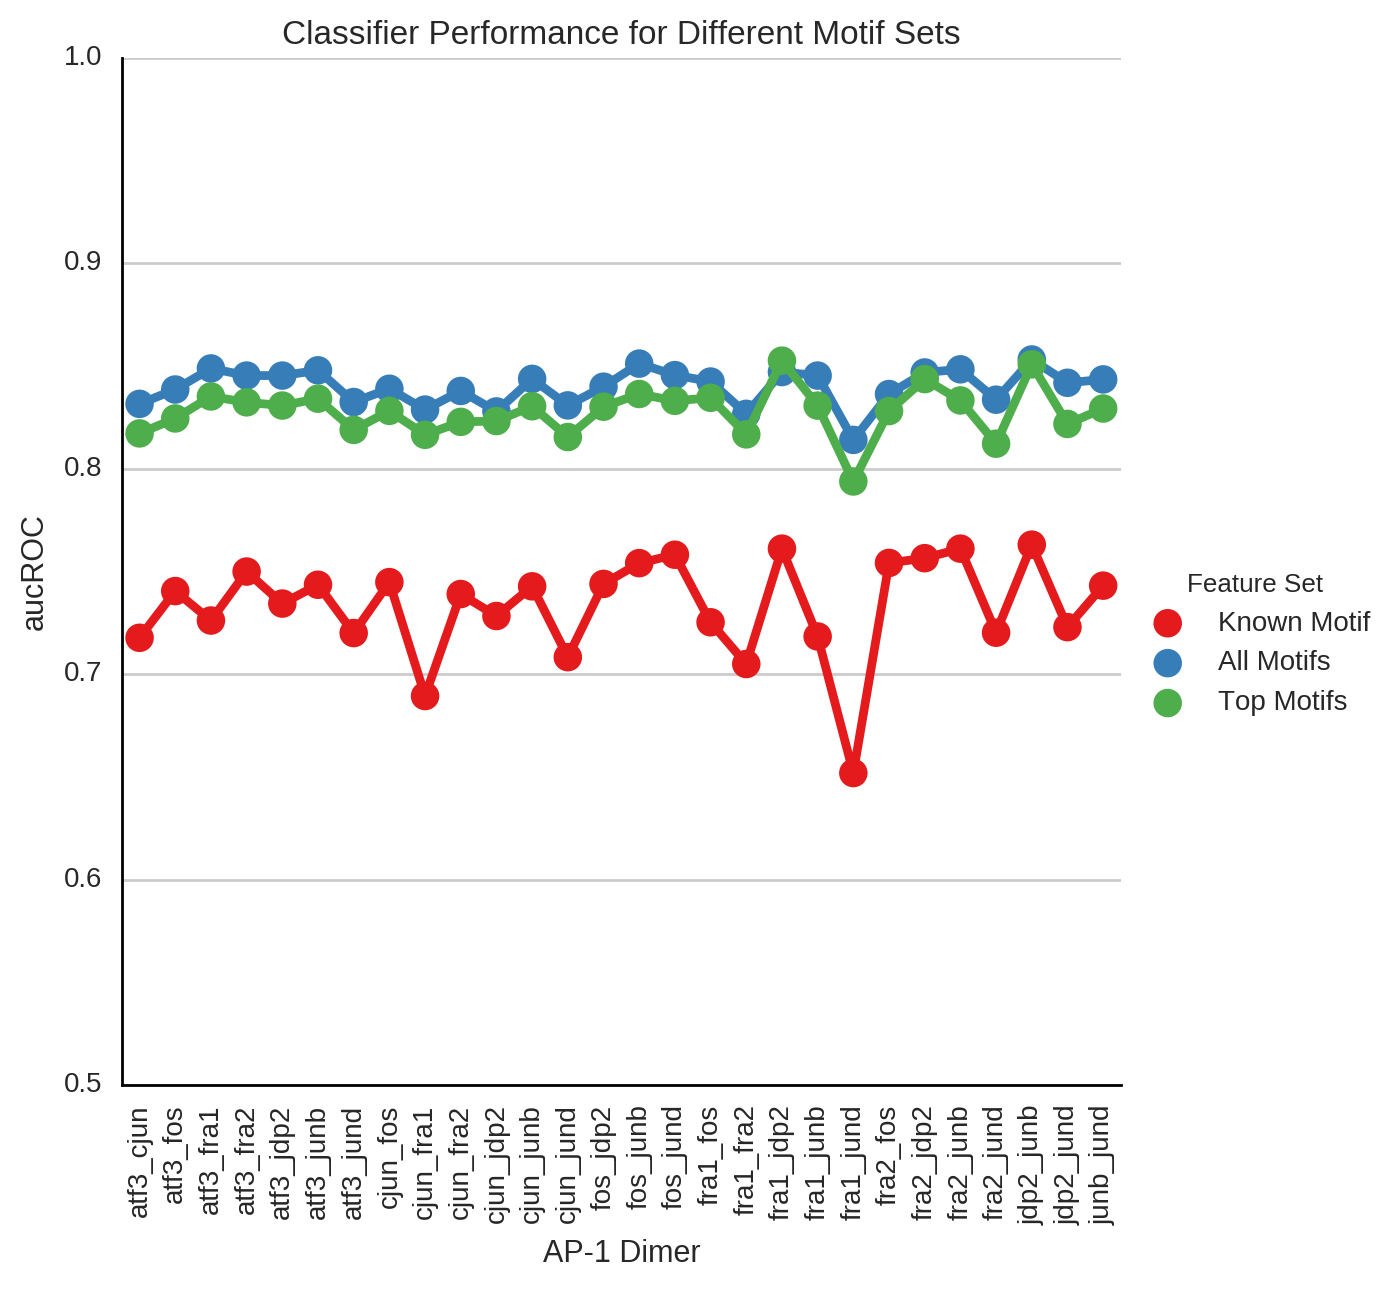

In [65]:
factors = []
aucs = []
features = []
for factor in sorted(factor_auc_dict_pairs.keys()):
#     if factor.split('_')[0] in ap1_members and factor.split('_')[1] in ap1_members:
    if True:
        factors = factors + 3 * [factor]
        features = features + ['Known Motif', 'All Motifs', 'Top Motifs']
        aucs.append(factor_auc_dict_pairs_top[factor])
        aucs.append(factor_auc_dict_pairs[factor])
        aucs.append(factor_auc_dict_all_pairs_best[factor])
with sns.axes_style('whitegrid', {'axes.edgecolor': 'black'}):
    plottingFrame = sns.factorplot(data = pd.DataFrame({'Factor':factors,
                                                         'AUC':aucs,
                                                         'Feature Set':features}),
                                x='Factor',
                                y='AUC',
                                hue='Feature Set',
                                palette='Set1',
                                size=6)
    sns.despine()
    plt.xticks(rotation=90)
    plt.ylabel('aucROC')
    plt.xlabel('AP-1 Dimer')
    plt.ylim(0.5,1)
    plt.title('Classifier Performance for Different Motif Sets')
    plt.savefig('/home/jtao/analysis/scratch/Figure 11 - Classifier Performance for Dimers.pdf', bbox_inches='tight')

In [113]:
### for all peaks in vehicle for all motifs
factor_coeff_dict = {}
factor_auc_dict_pairs = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
 
for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_veh') & summary_frame['Factors'].str.contains(factorPair[1] + '_veh')

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_pairs['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)
coefficients_frame_veh_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_veh_pairs.index = motif_score_frame.columns.values[3:]

total: 81822 filtered: 67118 true gc: 0.47422 false gc: 0.48422 difference: 0.01
('c57bl6_atf3', 'c57bl6_cjun') 0.831410491
total: 81822 filtered: 81822 true gc: 0.50378 false gc: 0.49924 difference: 0.00454
('c57bl6_atf3', 'c57bl6_fra1') 0.836345856888
total: 81822 filtered: 81822 true gc: 0.49941 false gc: 0.49932 difference: 9e-05
('c57bl6_atf3', 'c57bl6_fra2') 0.858967638191
total: 81822 filtered: 65551 true gc: 0.52259 false gc: 0.51259 difference: 0.01
('c57bl6_atf3', 'c57bl6_fos') 0.901603630411
total: 81822 filtered: 81822 true gc: 0.4963 false gc: 0.49936 difference: 0.00306
('c57bl6_atf3', 'c57bl6_jdp2') 0.848965061416
total: 81822 filtered: 76584 true gc: 0.51311 false gc: 0.50311 difference: 0.01
('c57bl6_atf3', 'c57bl6_junb') 0.828189358861
total: 81822 filtered: 81822 true gc: 0.49383 false gc: 0.49968 difference: 0.00584
('c57bl6_atf3', 'c57bl6_jund') 0.84651312778
total: 81822 filtered: 60247 true gc: 0.52762 false gc: 0.51762 difference: 0.01
('c57bl6_cjun', 'c57bl6_fr

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/seaborn-0.7.0-py3.4.egg/seaborn/matrix.py:134: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


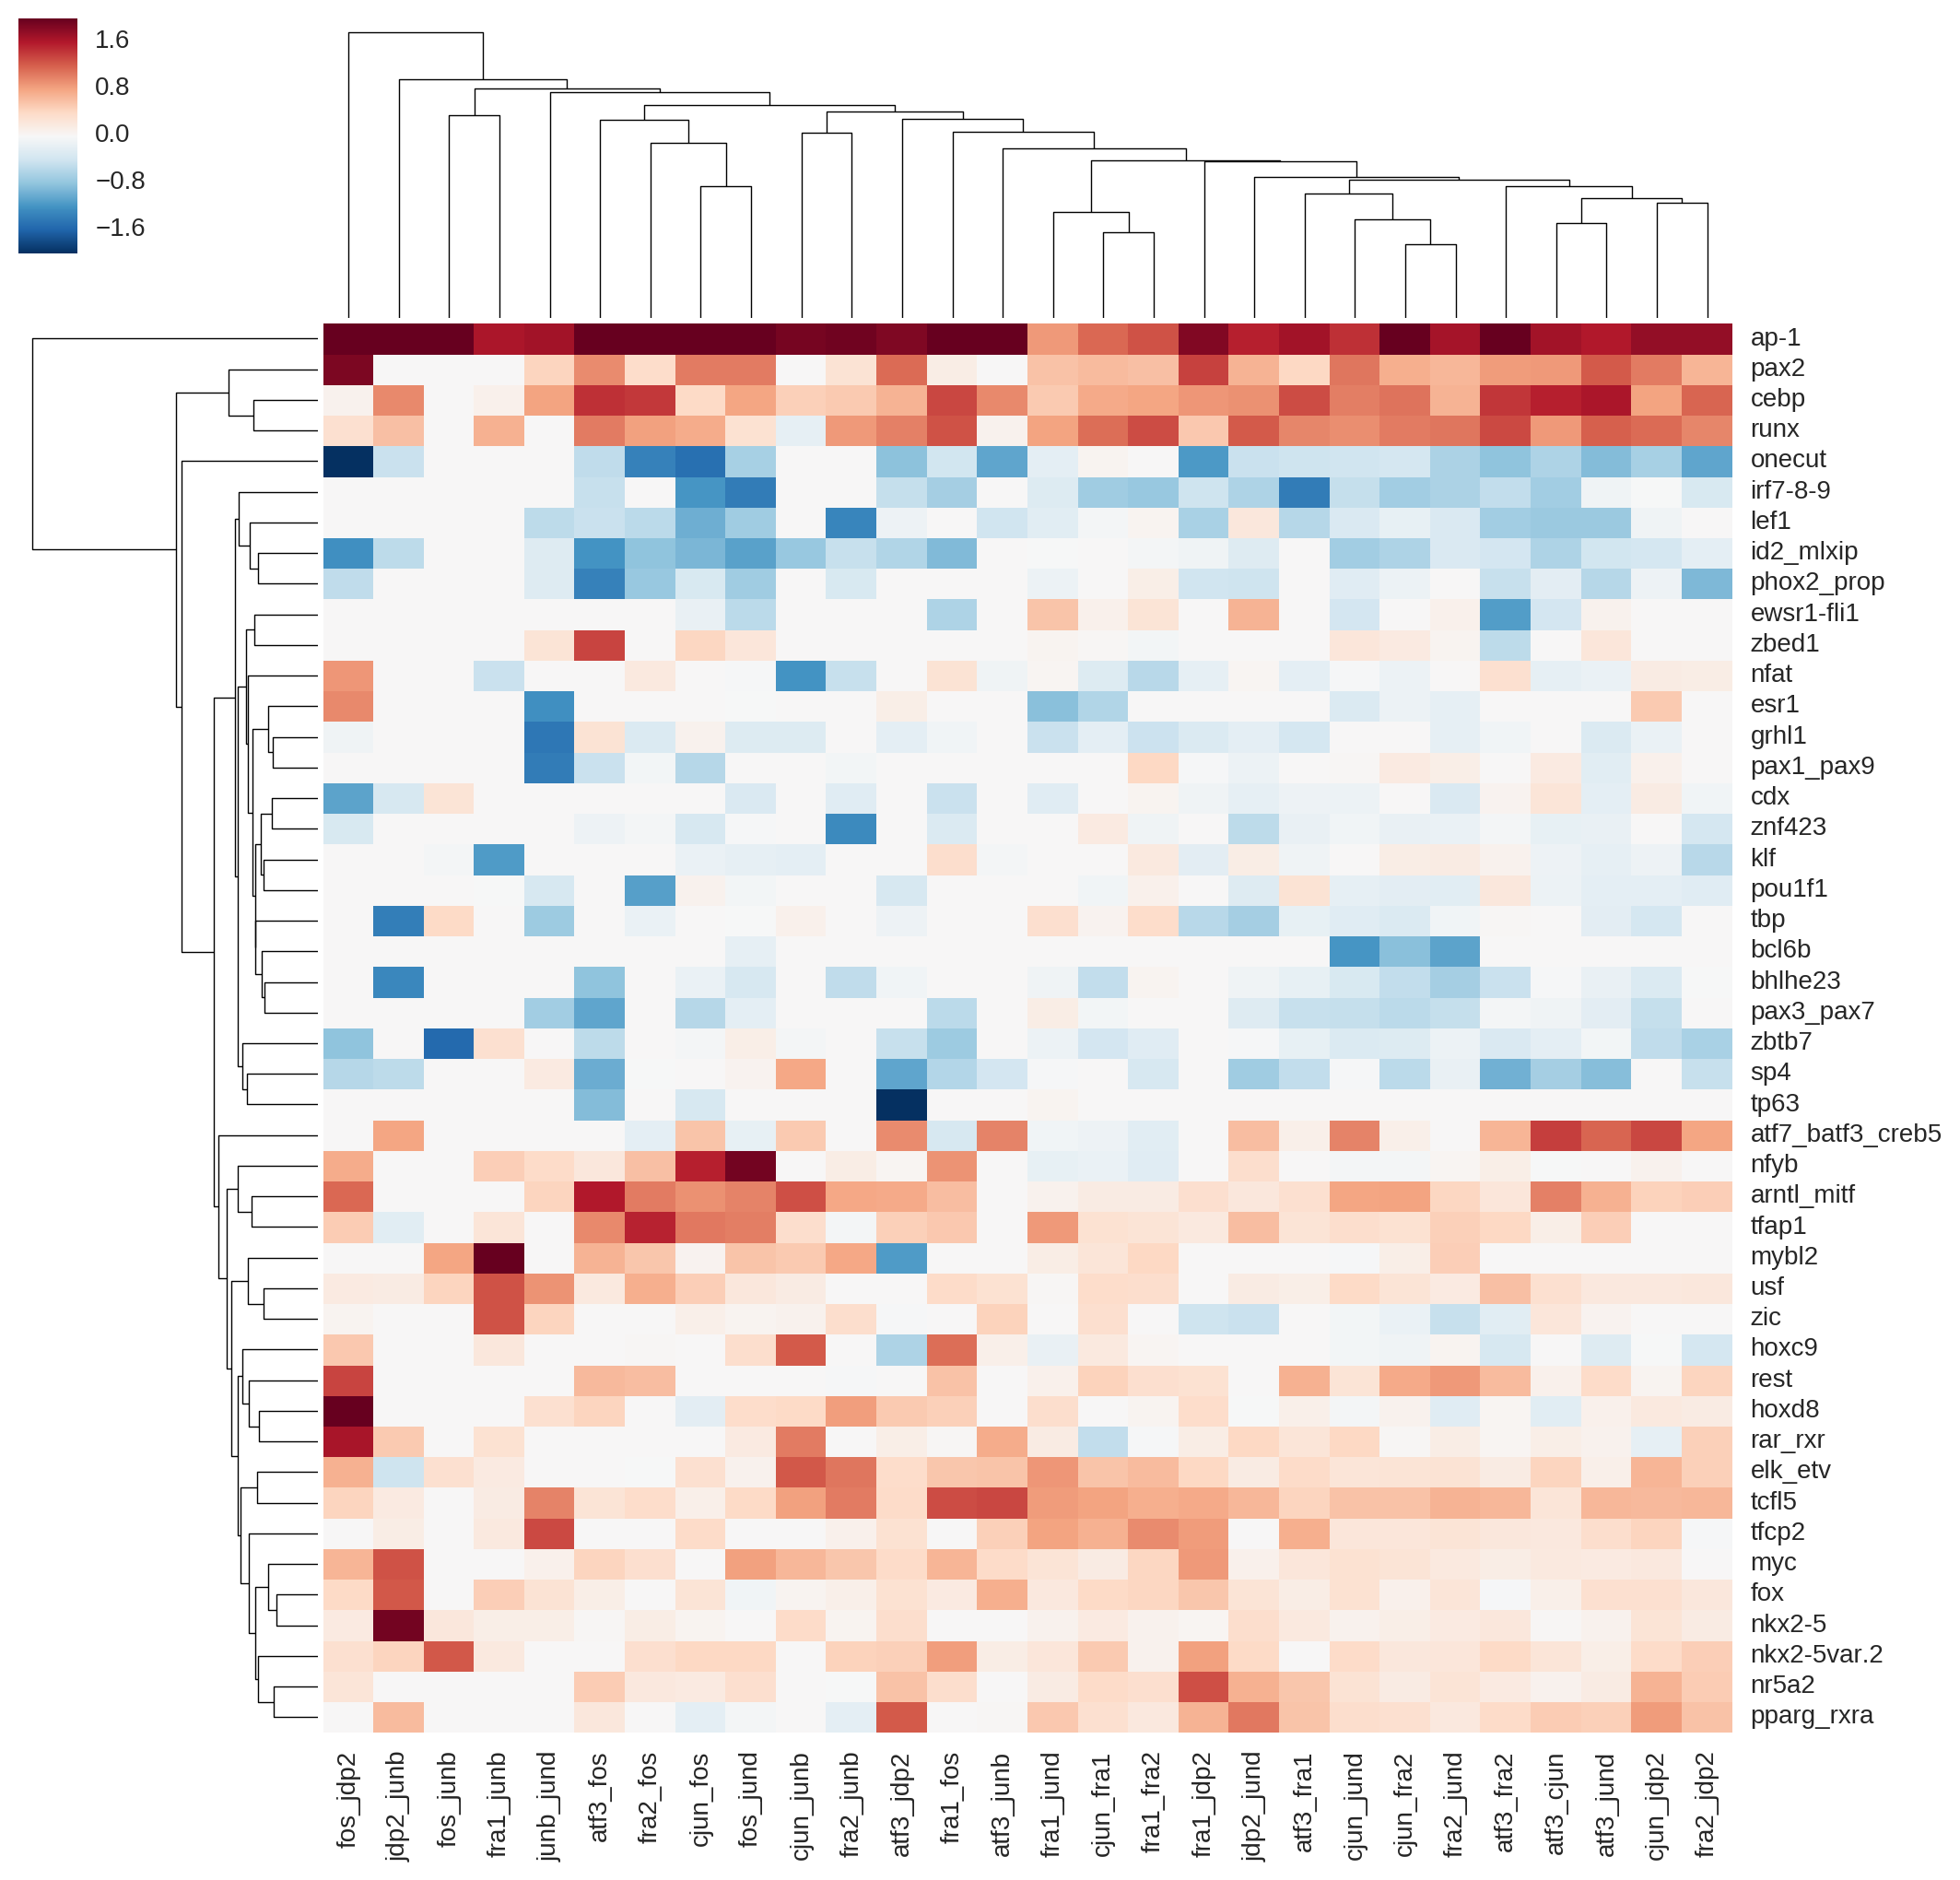

In [127]:
### plot coefficents for vehicle
threshold = 3.0
coeff_std = np.std(coefficients_frame_veh_pairs.values.flatten())
coeff_mean = np.mean(coefficients_frame_veh_pairs.values.flatten())

cg = sns.clustermap(coefficients_frame_veh_pairs[(coefficients_frame_veh_pairs.max(axis=1) > coeff_mean + threshold* coeff_std) |
                                       (coefficients_frame_veh_pairs.min(axis=1) < coeff_mean - threshold* coeff_std)
                                      ],
                   vmax=-2,
                   vmin=2,
                   center = 0.0,
#                    annot=True,annot_kws={"size": 4},
                   figsize=(12,12),
                   xticklabels=[x.replace('c57bl6_','') for x in coefficients_frame_veh_pairs.columns.values])
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);

In [114]:
### for all peaks in KLA for all motifs
factor_coeff_dict = {}
factor_auc_dict_pairs = {}
c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
 
for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]
    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_kla') & summary_frame['Factors'].str.contains(factorPair[1] + '_kla')

    training_features, test_features, training_labels, test_labels = get_GC_matched_split(
        features, labels, test_size = 0.5, tolerance = 0.01)
    
    #  Run classifier
    lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')
    
    lr_classifier.fit(training_features, training_labels)
    # retreive probabilities for each classifier
    probas_lr = lr_classifier.predict_proba(test_features)
    # retrieve predictions for each classifier
    
    fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
    roc_auc = auc(fpr, tpr)
    factor_auc_dict_pairs['_'.join(factorPair).replace('c57bl6_','')]= roc_auc
    coefficients = lr_classifier.coef_
    
    factor_coeff_dict['_'.join(factorPair)] = coefficients.flatten()
    print(factorPair, roc_auc)
coefficients_frame_kla_pairs = pd.DataFrame(factor_coeff_dict)
coefficients_frame_kla_pairs.index = motif_score_frame.columns.values[3:]

total: 81822 filtered: 67042 true gc: 0.47512 false gc: 0.48511 difference: 0.01
('c57bl6_atf3', 'c57bl6_cjun') 0.831310301636
total: 81822 filtered: 81822 true gc: 0.49653 false gc: 0.49938 difference: 0.00286
('c57bl6_atf3', 'c57bl6_fra1') 0.846230959354
total: 81822 filtered: 79240 true gc: 0.48767 false gc: 0.49767 difference: 0.01
('c57bl6_atf3', 'c57bl6_fra2') 0.84110146662
total: 81822 filtered: 68185 true gc: 0.47639 false gc: 0.48639 difference: 0.01
('c57bl6_atf3', 'c57bl6_fos') 0.832555854634
total: 81822 filtered: 68326 true gc: 0.47556 false gc: 0.48556 difference: 0.01
('c57bl6_atf3', 'c57bl6_jdp2') 0.835921851554
total: 81822 filtered: 74459 true gc: 0.48308 false gc: 0.49308 difference: 0.01
('c57bl6_atf3', 'c57bl6_junb') 0.841289405678
total: 81822 filtered: 66149 true gc: 0.47396 false gc: 0.48395 difference: 0.00999
('c57bl6_atf3', 'c57bl6_jund') 0.830778354797
total: 81822 filtered: 81822 true gc: 0.5049 false gc: 0.49918 difference: 0.00572
('c57bl6_cjun', 'c57bl6_

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/seaborn-0.7.0-py3.4.egg/seaborn/matrix.py:134: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


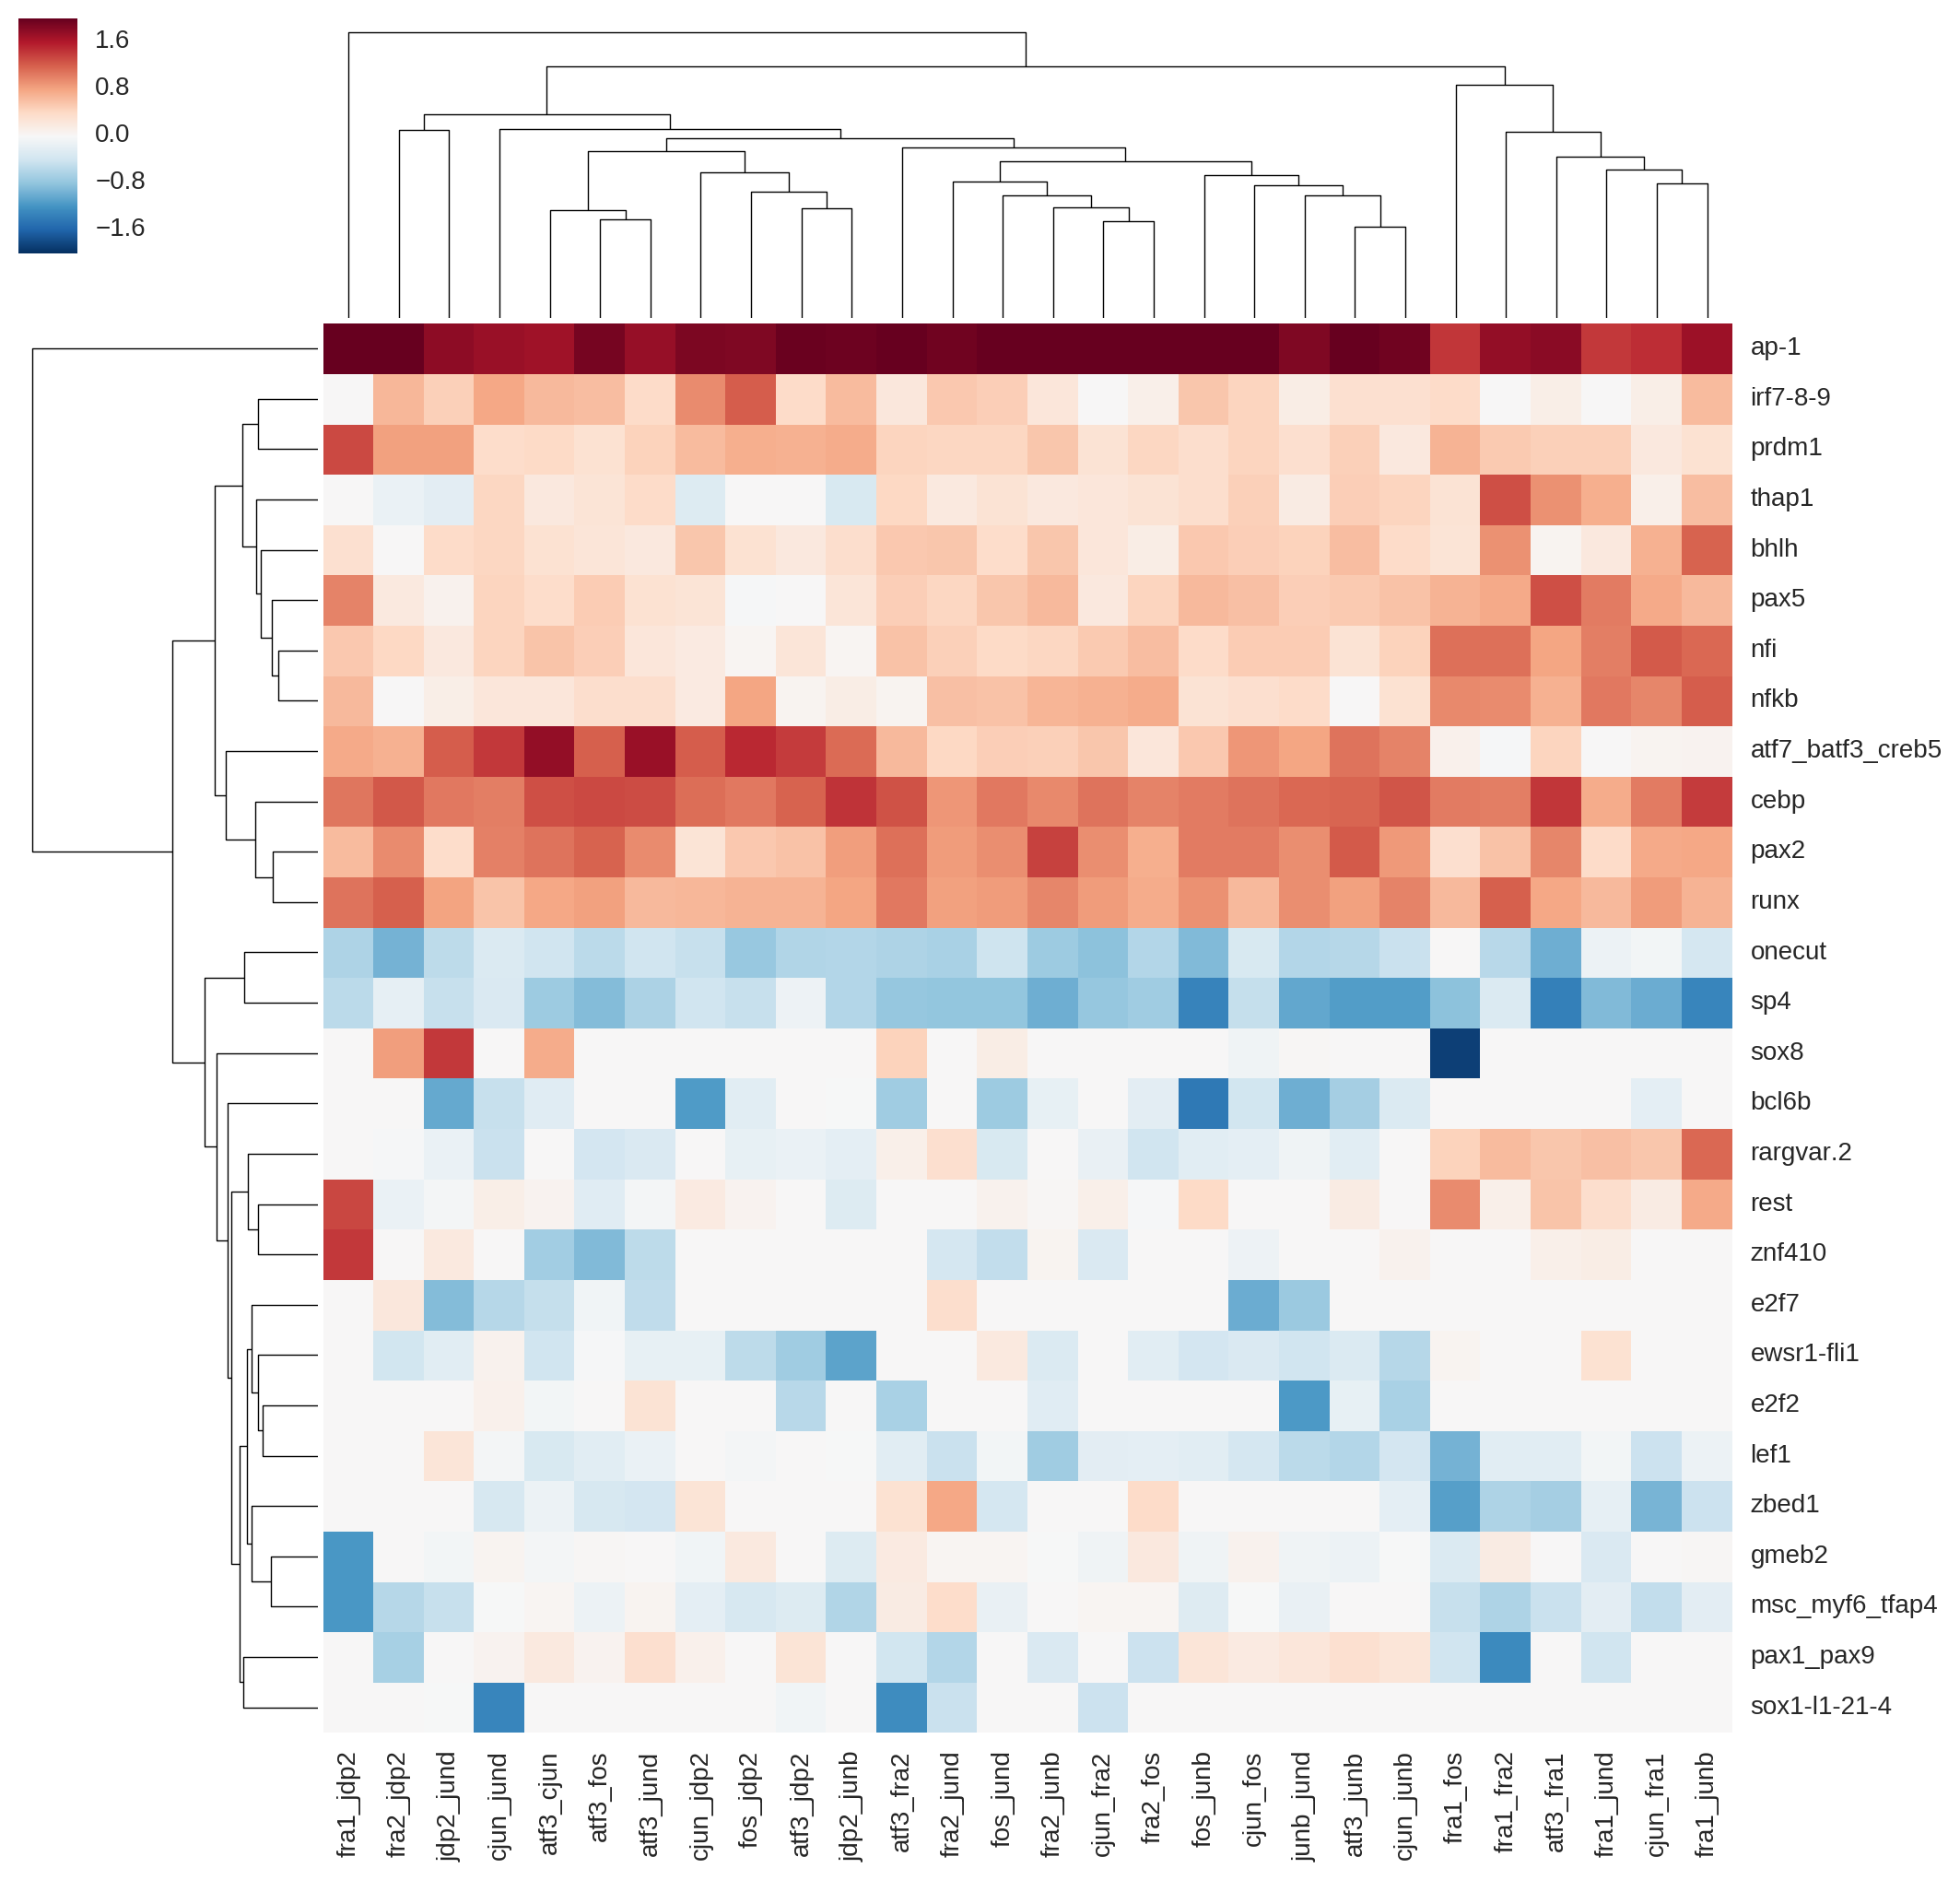

In [132]:
### plot coefficents for klaicle
threshold = 3.0
coeff_std = np.std(coefficients_frame_kla_pairs.values.flatten())
coeff_mean = np.mean(coefficients_frame_kla_pairs.values.flatten())

cg = sns.clustermap(coefficients_frame_kla_pairs[(coefficients_frame_kla_pairs.max(axis=1) > coeff_mean + threshold* coeff_std) |
                                       (coefficients_frame_kla_pairs.min(axis=1) < coeff_mean - threshold* coeff_std)
                                      ],
                   vmax=-2,
                   vmin=2,
                   center = 0.0,
#                    annot=True,annot_kws={"size": 4},
                   figsize=(12,12),
                   xticklabels=[x.replace('c57bl6_','') for x in coefficients_frame_kla_pairs.columns.values])
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=10, rotation=0);

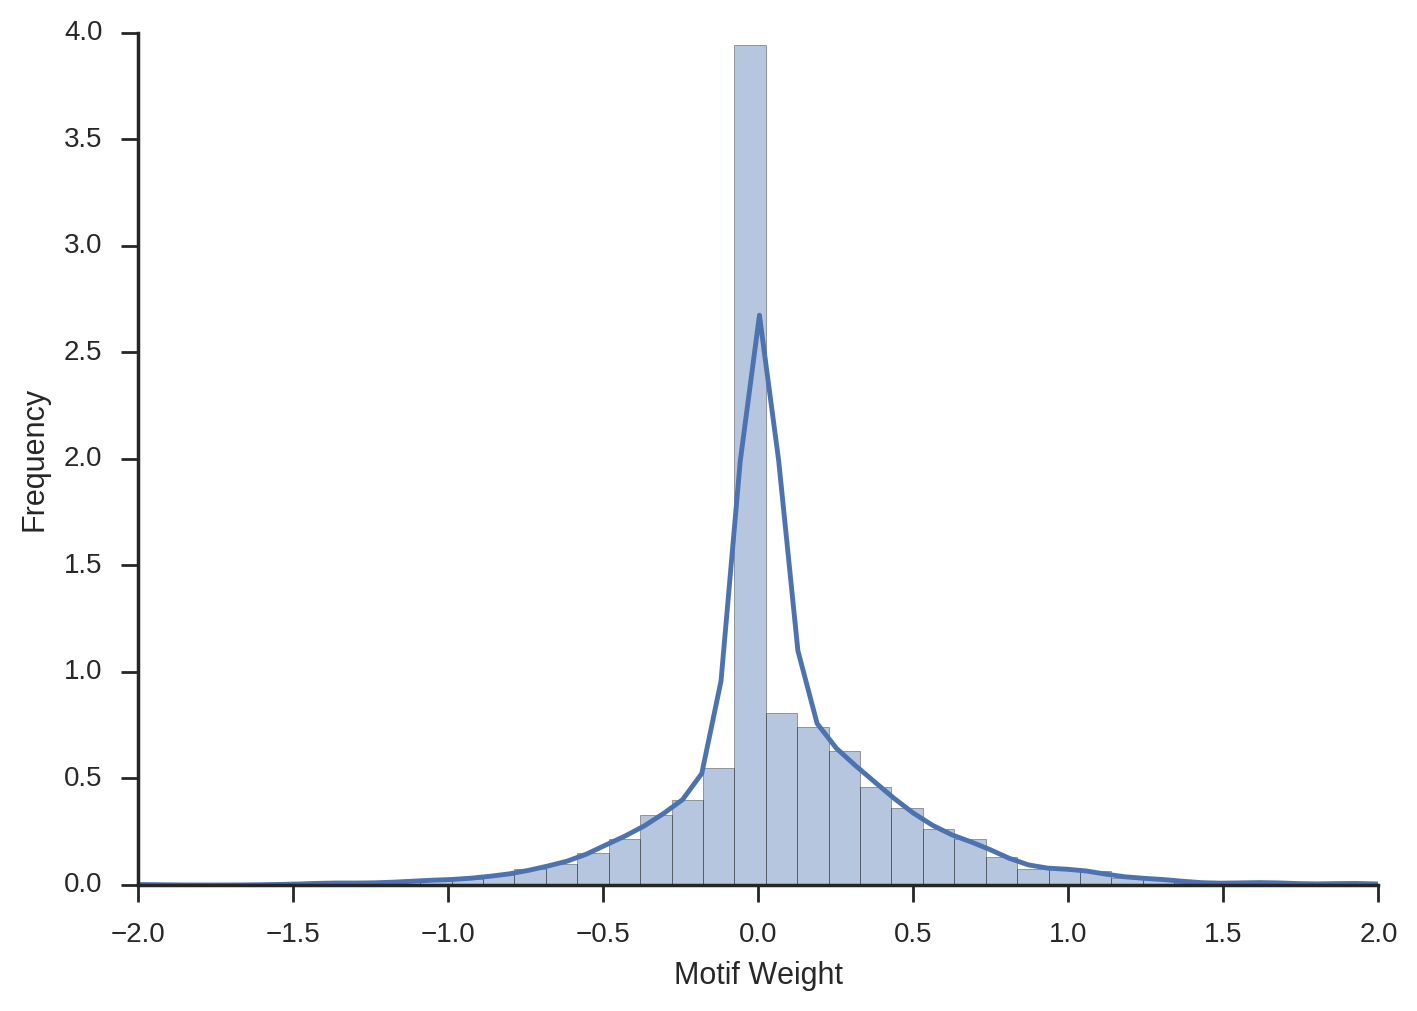

In [167]:
with sns.axes_style('ticks'):
    sns.distplot(coefficients_frame_veh_pairs.values.flatten())
    plt.ylabel('Frequency')
    plt.xlabel('Motif Weight')
    plt.xlim(-2,2)
    sns.despine()

### scatter plots of motif weights

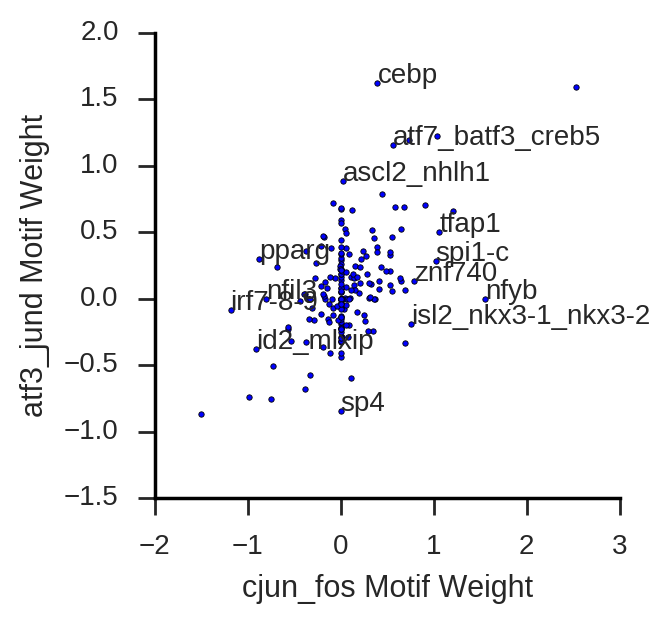

In [159]:
# scatterplot of weights
factor1 = 'c57bl6_cjun_c57bl6_fos'
factor2 = 'c57bl6_atf3_c57bl6_jund'
fold_threshold = 2.0
targets = ['ap-1, cebp', 'spi1-c', 'ctcf', 'irf1']
targets = []
plt.figure(figsize=(3,3))
motifs = coefficients_frame_veh_pairs.index.values
with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                         }):
    x_vals = coefficients_frame_veh_pairs[factor1]
    y_vals = coefficients_frame_veh_pairs[factor2]
    # calculate colors
    plt.scatter(x_vals,
                y_vals,
                marker = '.', 
                s=15)
    plt.xlabel(factor1.replace('c57bl6_','') + ' Motif Weight')
    plt.ylabel(factor2.replace('c57bl6_','') + ' Motif Weight')
    sns.despine()
    

    # calculate labels
    for i in range(len(x_vals)):
        x = x_vals[i]
        y = y_vals[i]
        if abs(x) >= 0.75 or abs(y) >= 0.75:
            fold_change = abs(y_vals[i] + 0.01)/abs(x_vals[i] + 0.01)
            if fold_change >= fold_threshold or fold_change <= 1/fold_threshold or motifs[i] in targets:
                plt.annotate(motifs[i], xy=(x,y) , size=10)
                    
    # Fix axes
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    plt.savefig('/home/jtao/analysis/cobinding_motif_analysis/atf3-jund_cjun-fos_scatterPlot.pdf', bbox_inches='tight')



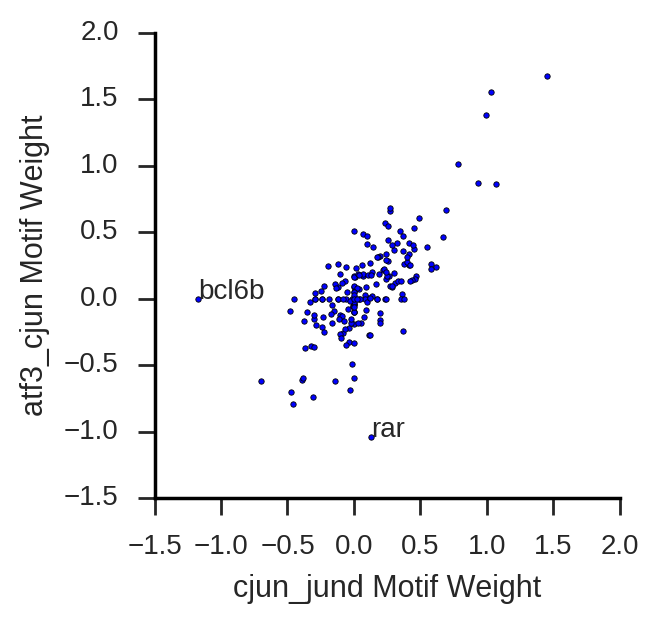

In [158]:
# scatterplot of weights
factor1 = 'c57bl6_cjun_c57bl6_jund'
factor2 = 'c57bl6_atf3_c57bl6_cjun'
fold_threshold = 2.0
targets = ['ap-1, cebp', 'spi1-c', 'ctcf', 'irf1']
targets = []
plt.figure(figsize=(3,3))
motifs = coefficients_frame_veh_pairs.index.values
with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                         }):
    x_vals = coefficients_frame_veh_pairs[factor1]
    y_vals = coefficients_frame_veh_pairs[factor2]
    # calculate colors
    plt.scatter(x_vals,
                y_vals,
                marker = '.', 
                s=15)
    plt.xlabel(factor1.replace('c57bl6_','') + ' Motif Weight')
    plt.ylabel(factor2.replace('c57bl6_','') + ' Motif Weight')
    sns.despine()
    

    # calculate labels
    for i in range(len(x_vals)):
        x = x_vals[i]
        y = y_vals[i]
        if abs(x) >= 0.75 or abs(y) >= 0.75:
            fold_change = abs(y_vals[i] + 0.01)/abs(x_vals[i] + 0.01)
            if fold_change >= fold_threshold or fold_change <= 1/fold_threshold or motifs[i] in targets:
                plt.annotate(motifs[i], xy=(x,y) , size=10)
                    
    # Fix axes
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    plt.savefig('/home/jtao/analysis/cobinding_motif_analysis/atf3-cjun_cjun-jund_scatterPlot.pdf', bbox_inches='tight')


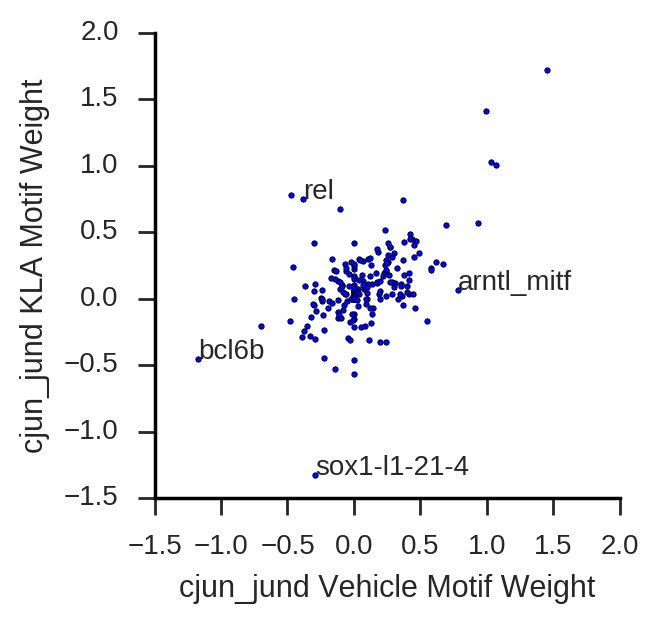

In [157]:
# scatterplot of weights
factor1 = 'c57bl6_cjun_c57bl6_jund'
factor2 = 'c57bl6_cjun_c57bl6_jund'
fold_threshold = 2.0
targets = ['ap-1, cebp', 'spi1-c', 'ctcf', 'irf1']
targets = []
plt.figure(figsize=(3,3))
motifs = coefficients_frame_veh_pairs.index.values
with sns.axes_style('ticks',{'axes.edgecolor': 'black',
                         }):
    x_vals = coefficients_frame_veh_pairs[factor1]
    y_vals = coefficients_frame_kla_pairs[factor2]
    # calculate colors
    plt.scatter(x_vals,
                y_vals,
                marker = '.', 
                s=15)
    plt.xlabel(factor1.replace('c57bl6_','') + ' Vehicle Motif Weight')
    plt.ylabel(factor2.replace('c57bl6_','') + ' KLA Motif Weight')
    sns.despine()
    

    # calculate labels
    for i in range(len(x_vals)):
        x = x_vals[i]
        y = y_vals[i]
        if abs(x) >= 0.75 or abs(y) >= 0.75:
            fold_change = abs(y_vals[i] + 0.01)/abs(x_vals[i] + 0.01)
            if fold_change >= fold_threshold or fold_change <= 1/fold_threshold or motifs[i] in targets:
                plt.annotate(motifs[i], xy=(x,y) , size=10)
                    
    # Fix axes
    ax = plt.gca()
    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    plt.savefig('/home/jtao/analysis/cobinding_motif_analysis/cjun-jund_veh-kla_scatterPlot.pdf', bbox_inches='tight')



## Visualization of Overlaps

In [ ]:
import networkx as nx
current_palette = sns.color_palette()


In [ ]:
### create network representation for VEH ###
cols = [x for x in bool_frame.columns if 'veh' in x]
veh_frame = bool_frame[cols]
network = nx.Graph()
for g in cols:
    factor = g.split('_')[0]
    network.add_node(factor, factor=factor)
#     network.add_node(g, environment=environmentDict[g], expression_veh=expressionDict_veh[g], expression_kla = expressionDict_kla[g])

for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        factor1 = cols[i].split('_')[0]
        factor2 = cols[j].split('_')[0]
        current_frame = bool_frame[[cols[i], cols[j]]]
        shared_motifs = current_frame[current_frame.sum(axis=1) == 2].index.values
        num_shared_motifs = float(len(shared_motifs)) + 1
        network.add_edge(factor1, factor2, sharedMotifs=num_shared_motifs)
# nx.draw_circular(network, edges=edges, width=weights)
edgewidth=[]
for (u,v,d) in network.edges(data=True):
    edgewidth.append(network.get_edge_data(u,v)['sharedMotifs'])
edgewidth = np.array(edgewidth)/15
  
nx.draw_circular(network, 
                node_size=2000, 
                node_color=current_palette[0],
                width=edgewidth,
                )

plt.gca().set_aspect('equal')
nx.write_graphml(network,'veh_graphml.xml')


In [ ]:
### create network representation for KLA ###
cols = [x for x in bool_frame.columns if 'kla' in x]
veh_frame = bool_frame[cols]
network = nx.Graph()
for g in cols:
    factor = g.split('_')[0]
    network.add_node(factor, factor=factor)
#     network.add_node(g, environment=environmentDict[g], expression_veh=expressionDict_veh[g], expression_kla = expressionDict_kla[g])

for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        factor1 = cols[i].split('_')[0]
        factor2 = cols[j].split('_')[0]
        current_frame = bool_frame[[cols[i], cols[j]]]
        shared_motifs = current_frame[current_frame.sum(axis=1) == 2].index.values
        num_shared_motifs = float(len(shared_motifs)) + 1
        network.add_edge(factor1, factor2, sharedMotifs=num_shared_motifs)
# nx.draw_circular(network, edges=edges, width=weights)
edgewidth=[]
for (u,v,d) in network.edges(data=True):
    edgewidth.append(network.get_edge_data(u,v)['sharedMotifs'])
edgewidth = np.array(edgewidth)/25
  
nx.draw_circular(network, 
                node_size=2000, 
                node_color=current_palette[1],
                width=edgewidth,
                )

plt.gca().set_aspect('equal')
nx.write_graphml(network,'kla_graphml.xml')



In [ ]:
### plot how significant motifs overlap with one another

cols = [x for x in bool_motif_frame.columns if 'veh' in x]
matrix = np.zeros((len(cols), len(cols)))

for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        factor1 = cols[i].split('_')[0]
        factor2 = cols[j].split('_')[0]
        current_frame = bool_motif_frame[[cols[i], cols[j]]]
        shared_motifs = current_frame[current_frame.sum(axis=1) == 2].index.values
        num_shared_motifs = float(len(shared_motifs))
        matrix[i][j] = num_shared_motifs
        matrix[j][i] = num_shared_motifs
mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
#     sns.heatmap(matrix, xticklabels = cols, yticklabels=cols, cmap='Blues', mask=mask, vmax=100)
    sns.heatmap(matrix, xticklabels = cols, yticklabels=cols, cmap='Blues', vmax=100)

    plt.xticks(rotation=90);
    plt.title('Overlap of Significant Motifs for Vehicle Peaks')
    plt.show()
    
# for KLA
cols = [x for x in bool_motif_frame.columns if 'kla' in x]
matrix = np.zeros((len(cols), len(cols)))

for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        factor1 = cols[i].split('_')[0]
        factor2 = cols[j].split('_')[0]
        current_frame = bool_motif_frame[[cols[i], cols[j]]]
        shared_motifs = current_frame[current_frame.sum(axis=1) == 2].index.values
        num_shared_motifs = float(len(shared_motifs))
        matrix[i][j] = num_shared_motifs
        matrix[j][i] = num_shared_motifs
mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
#     sns.heatmap(matrix, xticklabels = cols, yticklabels=cols, cmap='Blues', mask=mask, vmax=100)
    sns.heatmap(matrix, xticklabels = cols, yticklabels=cols, cmap='Blues', vmax=100)
    plt.xticks(rotation=90);
    plt.title('Overlap of Significant Motifs for KLA Peaks')

In [ ]:
### plot how significant motifs overlap with one another

cols = [x for x in bool_frame.columns if 'veh' in x]
matrix = np.zeros((len(cols), len(cols)))

for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        factor1 = cols[i].split('_')[0]
        factor2 = cols[j].split('_')[0]
        current_frame = bool_frame[[cols[i], cols[j]]]
        shared_motifs = current_frame[current_frame.sum(axis=1) == 2].index.values
        num_shared_motifs = float(len(shared_motifs))
        matrix[i][j] = num_shared_motifs
        matrix[j][i] = num_shared_motifs

with sns.axes_style("white"):
    sns.heatmap(np.log2(matrix+1), xticklabels = cols, yticklabels=cols, cmap='Greens', square=True)
    plt.xticks(rotation=90);
    plt.title('Overlap of Significant Motifs for Vehicle Peaks')
    plt.show()
    
# for KLA
cols = [x for x in bool_frame.columns if 'kla' in x]
matrix = np.zeros((len(cols), len(cols)))

for i in range(len(cols)-1):
    for j in range(i+1, len(cols)):
        factor1 = cols[i].split('_')[0]
        factor2 = cols[j].split('_')[0]
        current_frame = bool_frame[[cols[i], cols[j]]]
        shared_motifs = current_frame[current_frame.sum(axis=1) == 2].index.values
        num_shared_motifs = float(len(shared_motifs))
        matrix[i][j] = num_shared_motifs
        matrix[j][i] = num_shared_motifs
with sns.axes_style("white"):
    sns.heatmap(np.log2(matrix+1), xticklabels = cols, yticklabels=cols, cmap='Greens', square = True)
    plt.xticks(rotation=90);
    plt.title('Overlap of Significant Motifs for KLA Peaks')

## Strains Stuff

In [21]:
### read in strains SNPs ###

# filter away SNPS that didn't pass all qc metrics
!grep PASS ./strains_snps/BALB_cJ.mgp.v5.snps.dbSNP142.vcf  > ./strains_snps/balbcj_passed_snps.txt
!grep PASS ./strains_snps/BALB_cJ.mgp.v5.snps.dbSNP142.vcf  > ./strains_snps/nod_passed_snps.txt

In [22]:
chrom_size_dict = {
    '1':196,
'2':182,
'3':160,
'4':157,
'5':152,
'6':150,
'7':145,
'8':129,
'9':125,
'10':131,
'11':122,
'12':120,
'13':120,
'14':125,
'15':104,
'16':91,
'17':95,
'18':91,
'19':61,
'X':10,
'Y':10,
'MT':10,
}

In [25]:
balbcj_chr_snp_dict = {}
for chr in [str(x) for x in range(1,20)] + ['X','Y','MT']:
#     balb_chr_snp_dict[chr] = np.array([False] * (chrom_size_dict[chr]*100000))
    balbcj_chr_snp_dict[chr] = np.array([False] * (200*1000000))

print('reading balbcj snps')
with open('./strains_snps/balbcj_passed_snps.txt') as f:
    data = f.readlines()
for line in data[1:]:
    tokens = line.split('\t')
    chr = tokens[0]
    position = int(tokens[1])
    
    balbcj_chr_snp_dict[chr][position] = True

    
motif_balbcj_snp_frame = motif_start_frame[['ID', 'Factors', 'chr']]
motif_balbcj_snp_frame.index = motif_balbcj_snp_frame['ID'].values
for motif in motif_start_frame.columns[3:]:
    print(motif)
    starts = motif_start_frame[motif]
    ends = motif_end_frame[motif]
    chromosomes = motif_balbcj_snp_frame['chr']
    num_snp_list =  []
    for i in range(len(starts)):
        current_start = starts[i]
        current_end = ends[i]
        current_chr = chromosomes[i].replace('chr','')
        if current_start * current_end > 0:
            num_snp_list.append(np.sum(balbcj_chr_snp_dict[current_chr][current_start:current_end+1]))
        else:
            num_snp_list.append(0)
    motif_balbcj_snp_frame[motif] = num_snp_list

motif_balbcj_snp_frame.to_pickle('./motif_balbcj_snp_frame.pickle')



reading balbcj snps
alx1_alx4_arx


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ap-1
ar_nr3c1_nr3c2
arid3a
arid3b
arid5a
arnt_mycn
arntl_mitf
ascl2_nhlh1
atf7_batf3_creb5
bcl6
bcl6b
bhlh
bhlha15
bhlhe23
cdx
cebp
cenpb
creb3-l1
crem
ctcf
cux
dbp_hlf_tef
dmbx1
dmrt3
dux
dux4
duxa
e2f1
e2f2
e2f4_e2f6
e2f7
e2f8
ebf1
ebox
egr
elf
elk_etv
esr1
esr2
esrr
ewsr1-fli1
figla_id4_snai2_tcf3_tcf4
fox
gata
gcm
gfi1
gfi1b
gli2
glis
gmeb2
grhl1
gsc
hes
hic
hinfp
hltf
hnf1
hnf4a
hnf4g
homeobox-1
homeobox-2
homeobox-3
homeobox-4
homeobox-5
hoxa11
hoxa5
hoxa9
hoxb5_hoxd3
hoxc13
hoxc9
hoxd8
hsf
id2_mlxip
insm1
irf1
irf2
irf7-8-9
isl2_nkx3-1_nkx3-2
klf
lef1
lhx3
lin54
maf_nrl
mafg
mecom
mef2a-b-d
mef2c
meis
mga_tbx
msc_myf6_tfap4
mtf1
myb
mybl1
mybl2
myc
myog_tcf12
mzf1
mzf1var.2
nfat
nfi
nfil3
nfkb
nfya
nfyb
nkx2-3_nkx2-8
nkx2-5
nkx2-5var.2
nr2_rxr
nr2e1
nr2e3
nr2f1
nr4a2
nr5a2
nrf1
onecut
pax1_pax9
pax2
pax3_pax7
pax5
pax6
pbx1
phox2_prop
pknox_tgif
plag1
pou1f1
pou2-3-5
pou4
pou6f2
pparg
pparg_rxra
prdm1
prox1
rar
rar_rxr
rargvar.2
rel
rest
rfx
rhox11
rora
roravar.2
rreb1
runx
rxra

In [37]:
nod_chr_snp_dict = {}
for chr in [str(x) for x in range(1,20)] + ['X','Y','MT']:

    nod_chr_snp_dict[chr] = np.array([False] * (200*1000000))

print('reading nod snps')
with open('./strains_snps/nod_passed_snps.txt') as f:
    data = f.readlines()
for line in data:
    tokens = line.split('\t')
    chr = tokens[0]
    position = int(tokens[1])
    
    nod_chr_snp_dict[chr][position] = True
    
motif_nod_snp_frame = motif_start_frame[['ID', 'Factors', 'chr']]
motif_nod_snp_frame.index = motif_balbcj_snp_frame['ID'].values
for motif in motif_start_frame.columns[3:]:
    print(motif)
    starts = motif_start_frame[motif]
    ends = motif_end_frame[motif]
    chromosomes = motif_nod_snp_frame['chr']
    num_snp_list =  []
    for i in range(len(starts)):
        current_start = starts[i]
        current_end = ends[i]
        current_chr = chromosomes[i].replace('chr','')
        if current_start * current_end > 0:
            num_snp_list.append(np.sum(nod_chr_snp_dict[current_chr][current_start:current_end+1]))
        else:
            num_snp_list.append(0)
    motif_nod_snp_frame[motif] = num_snp_list

reading nod snps
alx1_alx4_arx
ap-1
ar_nr3c1_nr3c2
arid3a
arid3b
arid5a
arnt_mycn
arntl_mitf
ascl2_nhlh1
atf7_batf3_creb5
bcl6
bcl6b
bhlh
bhlha15
bhlhe23
cdx
cebp
cenpb
creb3-l1
crem
ctcf
cux
dbp_hlf_tef
dmbx1
dmrt3
dux
dux4
duxa
e2f1
e2f2
e2f4_e2f6
e2f7
e2f8
ebf1
ebox
egr
elf
elk_etv
esr1
esr2
esrr
ewsr1-fli1
figla_id4_snai2_tcf3_tcf4
fox
gata
gcm
gfi1
gfi1b
gli2
glis
gmeb2
grhl1
gsc
hes
hic
hinfp
hltf
hnf1
hnf4a
hnf4g
homeobox-1
homeobox-2
homeobox-3
homeobox-4
homeobox-5
hoxa11
hoxa5
hoxa9
hoxb5_hoxd3
hoxc13
hoxc9
hoxd8
hsf
id2_mlxip
insm1
irf1
irf2
irf7-8-9
isl2_nkx3-1_nkx3-2
klf
lef1
lhx3
lin54
maf_nrl
mafg
mecom
mef2a-b-d
mef2c
meis
mga_tbx
msc_myf6_tfap4
mtf1
myb
mybl1
mybl2
myc
myog_tcf12
mzf1
mzf1var.2
nfat
nfi
nfil3
nfkb
nfya
nfyb
nkx2-3_nkx2-8
nkx2-5
nkx2-5var.2
nr2_rxr
nr2e1
nr2e3
nr2f1
nr4a2
nr5a2
nrf1
onecut
pax1_pax9
pax2
pax3_pax7
pax5
pax6
pbx1
phox2_prop
pknox_tgif
plag1
pou1f1
pou2-3-5
pou4
pou6f2
pparg
pparg_rxra
prdm1
prox1
rar
rar_rxr
rargvar.2
rel
rest
rfx
rhox11

In [38]:
motif_nod_snp_frame.to_pickle('./motif_nod_snp_frame.pickle')

In [ ]:
motif_1 = 'spi1-c'
motif_2 = 'ap-1'
factor_1 = 'c57bl6_pu1_veh'
factor_2 = 'c57bl6_cjun_veh'

motif_state_1s = []
motif_state_2s = []
peak_state_1s = []
peak_state_2s = []
counts = []
for peak_state_1 in [True, False]:
    for peak_state_2 in [True, False]:
        for motif_state_1 in [True, False]:
            for motif_state_2 in [True, False]:
#                 if np.sum([peak_state_1, peak_state_2]) > 0:
                if True:
                    motif_state_1s.append(motif_state_1)
                    motif_state_2s.append(motif_state_2)
                    peak_state_1s.append(peak_state_1)
                    peak_state_2s.append(peak_state_2)
                    peak_indices = summary_frame[(summary_frame['Factors'].str.contains(factor_1) == peak_state_1) &
                                                 (summary_frame['Factors'].str.contains(factor_2) == peak_state_2)].index.values
                    current_motif_frame = motif_score_frame[motif_score_frame.index.isin(peak_indices)]
                    motif_indices = current_motif_frame[((current_motif_frame[motif_1] > 0) == motif_state_1) &
                                                        ((current_motif_frame[motif_2] > 0) == motif_state_2)].index.values                   
                    count = len(motif_indices)
                    counts.append(count)
current_count_frame = pd.DataFrame({factor_1 +' binding':peak_state_1s,
                                   factor_2 +' binding':peak_state_2s,
                                   motif_1 + ' motif':motif_state_1s,
                                   motif_2 + ' motif':motif_state_2s,
                                   'num peaks': counts})               
current_count_frame = current_count_frame[[factor_1 +' binding',
                                   factor_2 +' binding',
                                   motif_1 + ' motif',
                                   motif_2 + ' motif',
                                   'num peaks']]